# Load Dataset

In [2]:
import os
import time
import numpy as np
import torch
import math
import matplotlib.pyplot as plt
import tqdm

from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.distributions import MultivariateNormal, Categorical, Normal
from models_modules import MLP, CNNFastEncoder, CNNFastDecoder
from model_neuralmsm import NeuralMSM
from sklearn.decomposition import PCA

In [1]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

In [3]:
seed = 24 # 23 24 25 26 27
num_states = 3
dim_obs = 2
dim_latent = 2
T = 200
data_size = 5000
sparsity_prob = 0.0
data_type = 'cosine'
degree = 3
restarts_num = 10
images = False

path = '../../../vol/bitbucket/am9923/datasets/latent_variables/obs_train_N_{}_T_{}_dim_latent_{}_dim_obs_{}_state_{}_sparsity_{}_net_{}_seed_{}.npy'.format(data_size,T, dim_latent, dim_obs, num_states, sparsity_prob, data_type, seed)
test_path = '../../../vol/bitbucket/am9923/datasets/latent_variables/obs_test_N_{}_T_{}_dim_latent_{}_dim_obs_{}_state_{}_sparsity_{}_net_{}_seed_{}.npy'.format(data_size//10,T, dim_latent, dim_obs, num_states, sparsity_prob, data_type, seed)

dl = TensorDataset(torch.from_numpy(np.load(path)))
exp_name = 'inferred_params_N_{}_T_{}_dim_latent_{}_dim_obs_{}_state_{}_sparsity_{}_net_{}_seed_{}'.format(data_size,
        T, dim_latent, dim_obs, num_states, sparsity_prob, data_type, seed)
test_dl = TensorDataset(torch.from_numpy(np.load(test_path)))
final_temperature = 1

        
pre_train_check = 5
init_temperature = 5
iter_update_temp = 50
iter_check_temp = 1000
epoch_num = 100
learning_rate = 5e-4
gamma_decay = 0.5
scheduler_epochs = 40
decay_rate = 0.9

best_elbo = -torch.inf
if images:
    dataloader = DataLoader(dl, batch_size=32, shuffle=True)
else:
    dataloader = DataLoader(dl, batch_size=64, shuffle=True)  
    test_dataloader = DataLoader(test_dl, batch_size=50, shuffle=False)

# Visualize

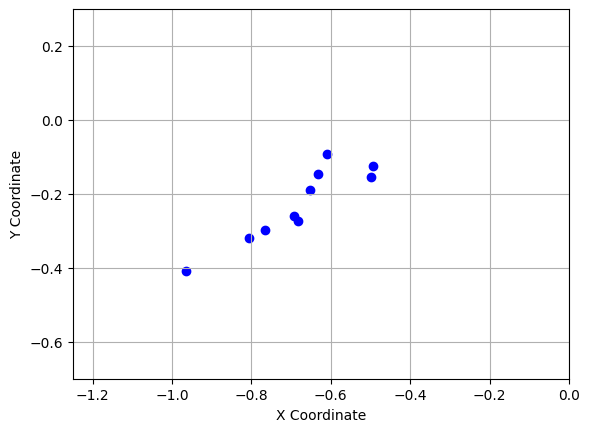

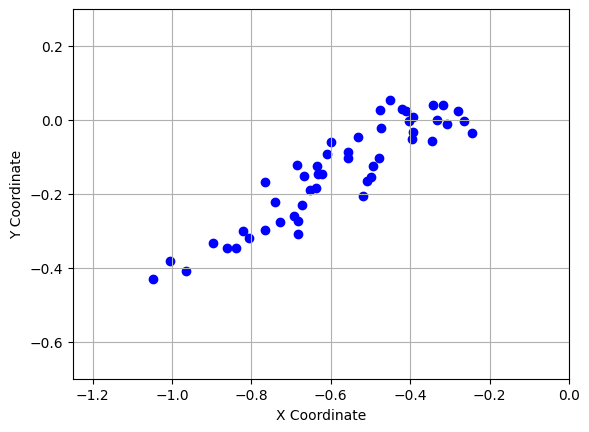

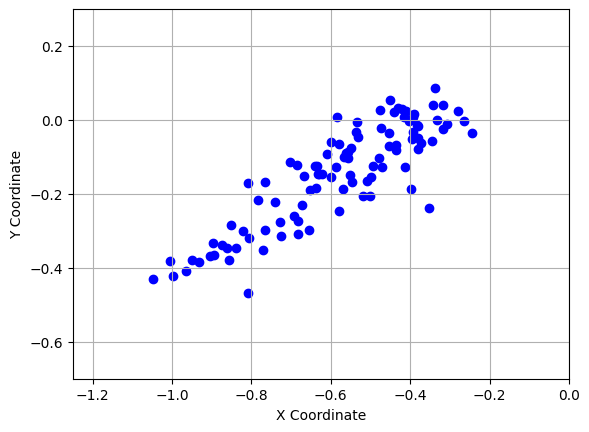

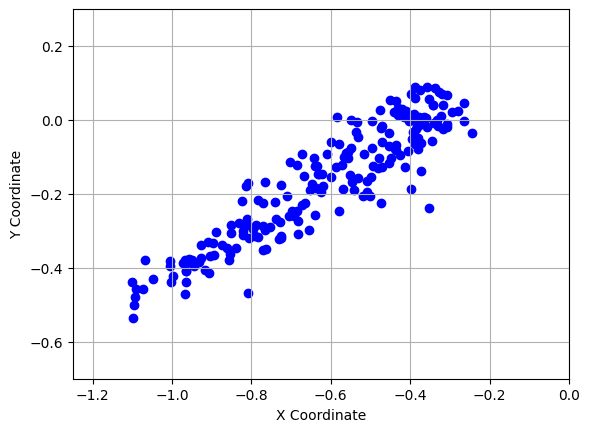

In [7]:
def visualize_coordinates(coordinates):
    # Unzip the list of tuples into two lists: x and y coordinates
    x_coords, y_coords = zip(*coordinates)
    
    # Create a scatter plot
    plt.scatter(x_coords, y_coords, c='blue', marker='o')
    
    # Set the axis labels
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.xlim(-1.25,0.0)
    plt.ylim(-0.7,0.3)
    
    # Display a grid
    plt.grid(True)
    
    # Display the plot
    plt.show()

visualize_coordinates(dataloader.dataset[1][0][0:10])
visualize_coordinates(dataloader.dataset[1][0][0:50])
visualize_coordinates(dataloader.dataset[1][0][0:100])
visualize_coordinates(dataloader.dataset[1][0][0:200])

In [8]:
def plot_predictions(gt, preds, step=25):
    # Number of timesteps
    T = gt.shape[0]
    
    # Generate colors for each step timestep
    num_colors = (T + step - 1) // step  # Number of colors needed
    colors = plt.cm.jet(np.linspace(0, 1, num_colors))
    
    # Plot each 10th timestep
    for i in range(0, T, step):
        x1, y1 = gt[i]
        x2, y2 = preds[i]

        plt.scatter(x1, y1, color=colors[i // step], label=f't={i}')
        plt.scatter(x2, y2, color=colors[i // step], marker='x')

        plt.plot([x1, x2], [y1, y2], color=colors[i // step], linestyle='--', linewidth=1, alpha=0.3)

    
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title('Predictions at Each 10th Timestep')
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.grid(True)
    plt.show()

def plot_models(gamma, gamma2, gamma3, latents_states, xtick_labels=None):
    # gamma: [B, T, num_states]
    # latents_states: [B, num_states]
    N = 10
    T = gamma.shape[1]
    states = torch.zeros(T, 3)
    states[range(T), latents_states[N, :].long()] = 1    

    # Plotting
    fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(15, 3.5), sharex=True)

    # Plotting Model 1
    im1 = axes[0].imshow(states[:T, :].T, vmin=0, vmax=1)

    # Plotting Model 2
    im2 = axes[1].imshow(gamma[N, :T, :].T.cpu().numpy(), vmin=0, vmax=1)

    # Plotting Model 3
    im3 = axes[2].imshow(gamma2[N, :T, :].T.cpu().numpy(), vmin=0, vmax=1)

    # Plotting Model 4
    im4 = axes[3].imshow(gamma3[N, :T, :].T.cpu().numpy(), vmin=0, vmax=1)

    for ax in axes:
        ax.set_yticks([])
        ax.spines['top'].set_visible(False)     # Hide the top spine
        ax.spines['right'].set_visible(False)   # Hide the right spine
        ax.spines['bottom'].set_visible(False)  # Hide the bottom spine
        ax.spines['left'].set_visible(False)    # Hide the left spine
        ax.grid(False)
        # Remove tick marks
        ax.tick_params(axis='x', which='both', length=0, width=0)  # Remove x-axis ticks
        ax.tick_params(axis='y', which='both', length=0, width=0)  # Remove y-axis ticks

    # Adding model names to the left of each subplot
    axes[0].text(-0.01, 0.5, 'Ground Truth', va='center', ha='right', transform=axes[0].transAxes, fontsize=10)
    axes[1].text(-0.01, 0.5, 'ELBO', va='center', ha='right', transform=axes[1].transAxes, fontsize=10)
    axes[2].text(-0.01, 0.5, 'IWAE', va='center', ha='right', transform=axes[2].transAxes, fontsize=10)
    axes[3].text(-0.01, 0.5, 'FIVO', va='center', ha='right', transform=axes[3].transAxes, fontsize=10)

    # Adjust layout to remove space between subplots
    plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1, hspace=0.1)

    # Add a colorbar to the center right of the plot
    cbar_ax = fig.add_axes([0.92, 0.15, 0.01, 0.7])  # [left, bottom, width, height]
    fig.colorbar(im2, cax=cbar_ax)

    axes[0].set_xlim((0, T))

    # Set the x-axis label on the bottom plot only
    axes[3].set_xlabel('Timestep')
    current_xticks = axes[1].get_xticks()  # Get the current x-tick positions
    new_labels = np.linspace(xtick_labels[0], xtick_labels[1], num=len(current_xticks))
    axes[3].set_xticklabels([f'{int(label)}' for label in new_labels])
    
    plt.show()

In [ ]:
import numpy as np
from itertools import permutations
from sklearn.metrics import f1_score

def best_f1_score(ground_truth, posterior_probs):
    """
    Calculate the best F1 score for the given ground truth and posterior probabilities tensors.

    Parameters:
    - ground_truth: A numpy array of shape [B, T] with integers 0, 1, 2 representing the ground truth states.
    - posterior_probs: A numpy array of shape [B, T, 3] with posterior probabilities for each state.

    Returns:
    - best_f1: The best F1 score after testing all permutations of the states.
    """
    # Find the predicted states by taking the argmax over the last dimension
    predicted_states = np.argmax(posterior_probs, axis=-1)

    # List all possible permutations of (0, 1, 2)
    state_permutations = list(permutations([0, 1, 2]))

    best_f1 = 0.0
    
    # Iterate over all permutations
    for perm in state_permutations:
        # Map predicted states according to the current permutation
        mapped_predictions = np.copy(predicted_states)
        for original_state, new_state in enumerate(perm):
            mapped_predictions[predicted_states == original_state] = new_state
        
        # Calculate F1 score for this permutation
        f1 = f1_score(ground_truth.flatten(), mapped_predictions.flatten(), average='macro')
        
        # Update best F1 score
        if f1 > best_f1:
            best_f1 = f1
    
    return best_f1


def best_cross_entropy_loss(ground_truth, posterior_probs):
    """
    Calculate the best cross-entropy loss for the given ground truth and posterior probabilities tensors.

    Parameters:
    - ground_truth: A numpy array of shape [B, T] with integers 0, 1, 2 representing the ground truth states.
    - posterior_probs: A numpy array of shape [B, T, 3] with posterior probabilities for each state.

    Returns:
    - best_cross_entropy: The lowest cross-entropy loss after testing all permutations of the states.
    """
    ground_truth = ground_truth.astype(int)

    # List all possible permutations of (0, 1, 2)
    state_permutations = list(permutations([0, 1, 2]))

    best_cross_entropy = np.inf
    
    # Iterate over all permutations
    for perm in state_permutations:
        # Map the posterior probabilities according to the current permutation
        mapped_probs = np.zeros_like(posterior_probs)
        for i, new_state in enumerate(perm):
            mapped_probs[..., new_state] = posterior_probs[..., i]
        
        # Calculate cross-entropy loss for this permutation
        # One-hot encode the ground truth
        ground_truth_one_hot = np.eye(3)[ground_truth]
        
        # Clip the mapped probabilities to avoid log(0)
        clipped_probs = np.clip(mapped_probs, 1e-12, 1 - 1e-12)
        
        # Calculate cross-entropy loss
        cross_entropy = -np.sum(ground_truth_one_hot * np.log(clipped_probs)) / ground_truth.size
        
        # Update best cross-entropy loss
        if cross_entropy < best_cross_entropy:
            best_cross_entropy = cross_entropy
    
    return best_cross_entropy


# Create Model

### Helper Functions

In [5]:
def normal_logprob(x,mu,sigma):
    """
    Function that calculates the log probability of a multivariate normal distribution
    with diagonal covariance matrix.
    
    Args:
        x (torch.Tensor): Value at which the log probability is evaluated. Shape: [B,d]
        mu (torch.Tensor): Mean of the multivariate distribution. Shape: [B,d]
        sigma (torch.Tensor): Diagonal values of the covariance matrix of the
                              multivariate distribution. Shape: [B,d]
    """
    dev = x.device
    B,d = mu.shape
    
    if len(sigma.shape) == 0:
        sigma = sigma.repeat(B,d)

    a = torch.tensor(([-(d/2) * torch.log(torch.tensor(2)*torch.pi)]*B), device=dev)
    b = - 0.5 * torch.log(sigma).sum(1)
    c = - 0.5 * (((x - mu)**2/sigma).sum(1))
    return a+b+c

def resample(x,weights,N):
    """
    Modified from https://github.com/ZoneMS/EnKO/blob/main/SVAE/model/system/fivo.py
    Function that resamples N particles based on their weight
    Args: 
        x (torch.Tensor): Shape is [P,B,H]
        weights (torch.Tensor): Log weights. Shape is [P,B]
        N (int): Number of particles to resample
    Returns:
        torch.Tensor: Resampled particles of shape [P,B,H] 
    """
    weights = weights - torch.logsumexp(weights, dim=0) # Normalise log weights
    categorical = Categorical(logits=weights.permute([1,0]))    
    indices = categorical.sample(torch.Size([N])) # shape [P,B]
    x = torch.gather(x, 0, indices.unsqueeze(2).repeat(1,1,x.size(2)))
    return x

### Model Definition

In [6]:
class VariationalSNLDS(nn.Module):
    ## Class could be combined with Abstract class MSM for code efficiency
    ## The model allows different settings where annealing=True implements schedule from
    ## Dong et al. (2020) https://proceedings.mlr.press/v119/dong20e.html;
    ## and inference=='alpha' implements Ansari et al. (2023) loss function
    ## https://arxiv.org/abs/2110.13878
    ## We recommend the setting with annealing=False and inference='alpha' and recurent encoder
    ## which is the best that worked for estimation.
    def __init__(self, obs_dim, latent_dim, hidden_dim, num_states, beta=1, encoder_type='recurent', device='cpu', annealing=False, inference='alpha'):
        super(VariationalSNLDS, self).__init__()
        self.obs_dim = obs_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.num_states = num_states
        self.device = device
        self.beta = beta
        self.var = torch.tensor(5e-4).to(device)
        self.scaling = 0
        self.temperature = 1
        self.annealing = annealing
        self.inference = inference
        if annealing:
            self.scaling = 1e6
            self.temperature = 1e6
        self.encoder_type = encoder_type
        n_feat = 64
        n_layers = 2
        ## Neural net params
        # Transitions p(z_t|z_t-1,s_t)
        self.transitions = nn.ModuleList([MLP(latent_dim, latent_dim, hidden_dim, 'softplus') for _ in range(self.num_states)]).to(device).float()
        # Encoder q(z|x)
        if self.encoder_type=='factored':
            #self.encoder = nn.Linear(obs_dim, 2*latent_dim).to(device).float()
            self.encoder = MLP(obs_dim, 2*latent_dim, hidden_dim, 'leakyrelu').to(device).float()
        elif self.encoder_type=='video':
            self.img_embedding = CNNFastEncoder(3, hidden_dim, n_feat, n_layers=n_layers).to(device).float()
            self.encoder = nn.LSTM(hidden_dim, hidden_dim, num_layers=2, batch_first=True, bidirectional=True).to(device).float()
            self.encoder_causal = nn.LSTM(hidden_dim*2, hidden_dim, num_layers=2, batch_first=True, bidirectional=False).to(device).float()
            self.encoder_mean_var = nn.Linear(hidden_dim, 2*latent_dim).to(device).float()
        else:
            self.encoder = nn.LSTM(obs_dim, hidden_dim, num_layers=2, batch_first=True, bidirectional=True).to(device).float()
            self.encoder_causal = nn.LSTM(hidden_dim*2, hidden_dim, num_layers=2, batch_first=True, bidirectional=False).to(device).float()
            self.encoder_mean_var = nn.Linear(hidden_dim, 2*latent_dim).to(device).float()
        # Decoder p(x|z)
        if self.encoder_type=='video':
            self.decoder = CNNFastDecoder(latent_dim, 3, n_feat, n_layers=n_layers).to(device).float()
        else:
            self.decoder = MLP(latent_dim, obs_dim, hidden_dim, 'leakyrelu').to(device).float()
        #self.decoder = nn.Linear(latent_dim, obs_dim).to(device)
        ## MSM params
        # logits of p(s_t|s_t-1)
        self.Q = nn.Parameter(torch.zeros(self.num_states, self.num_states).to(device).float())
        # logits of p(s_1)
        self.pi = nn.Parameter(torch.zeros(num_states).to(device).float())
        #self.pi = torch.zeros(num_states).to(device)
        # Init mean and covariances
        self.init_mean = nn.Parameter(torch.randn(self.num_states, self.latent_dim).to(device).float())
        self.init_cov = nn.Parameter(((torch.rand(self.num_states,1,1)*torch.eye(self.latent_dim)[None,:,:])*5).to(device).float())
        self.covs = nn.Parameter((torch.eye(self.latent_dim)[None,:,:]).repeat(self.num_states,1,1).to(device).float()) # identity covariance
    
    def _encode_obs(self, x):
        if self.encoder_type=='factored':
            (B, T, D) = x.shape
            (z_mu, z_log_var) = self.encoder(x.reshape(B*T,-1)).split(self.latent_dim, dim=-1)
        elif self.encoder_type=='video':
            (B, T, C, W, H) = x.shape
            x = self.img_embedding(x.reshape(B*T,C,W,H)).reshape(B,T,-1)
            output, _ = self.encoder(x)
            # output contains h^x_{1:T}
            output, _ = self.encoder_causal(output)
            (z_mu, z_log_var) = self.encoder_mean_var(output).split(self.latent_dim, dim=-1)
        else:
            output, _ = self.encoder(x)
            # output contains h^x_{1:T}
            output, _ = self.encoder_causal(output)
            (z_mu, z_log_var) = self.encoder_mean_var(output).split(self.latent_dim, dim=-1)
        eps = torch.normal(mean=torch.zeros_like(z_mu)).to(x.device)
        z_std = (z_log_var*0.5).exp()
        sample = z_mu + z_std*eps
        return sample, z_mu, z_log_var

    def _compute_local_evidence(self, z):
        T = z.size(1)
        init_distrib_ = torch.distributions.MultivariateNormal(self.init_mean, torch.matmul(self.init_cov,self.init_cov.transpose(1,2)) + 1e-6*torch.eye(self.latent_dim)[None,:,:].to(self.device))
        log_local_evidence_1 = init_distrib_.log_prob(z[:,0:1,None,:].repeat(1,1,self.num_states,1)) # shape [B,1,num_states]
        if T==1:
            return log_local_evidence_1
        means_ = torch.cat([self.transitions[i](z[:,:-1, None,:]) for i in range(self.num_states)], dim=2) # shape [B,T-1,num_states,latent_dim]
        covs = torch.matmul(self.covs,self.covs.transpose(1,2)) + 1e-6*torch.eye(self.latent_dim)[None,:,:].to(self.device) # [num_states,latent_dim,2]
        distribs = [torch.distributions.MultivariateNormal(means_[:,:,i,:], covs[i,:,:]) for i in range(self.num_states)]
        log_local_evidence_T = torch.cat([distribs[i].log_prob(z[:,1:,:])[:,:,None] for i in range(self.num_states)], dim=2) # [B,T-1,num_states]
        return torch.cat([log_local_evidence_1, log_local_evidence_T], dim=1) # [B,T,num_states]
    
    def next_evidence(self,z):
        T = z.size(1)
        means_ = torch.cat([self.transitions[i](z[:,:-1, None,:]) for i in range(num_states)], dim=2) # shape [B,T-1,num_states,latent_dim]
        covs = torch.matmul(self.covs,self.covs.transpose(1,2)) + 1e-6*torch.eye(self.latent_dim)[None,:,:].to(device) # [num_states,latent_dim,2]
        distribs = [torch.distributions.MultivariateNormal(means_[:,:,i,:], covs[i,:,:]) for i in range(num_states)]  
        log_local_evidence_T = torch.cat([distribs[i].log_prob(z[:,1:,:])[:,:,None] for i in range(num_states)], dim=2) # [B,T-1,num_states]
        return log_local_evidence_T      

    def _alpha(self, local_evidence):
        N, T, _ = local_evidence.shape
        log_Z = torch.zeros((N,T)).to(self.device)
        log_alpha = torch.zeros((N, T, self.num_states)).to(self.device)
        # softmax is just to normalise the probabilities
        # shape: [B,num_states]
        log_prob = local_evidence[:,0,:] + torch.log((self.pi/self.temperature).softmax(-1)) # log p(z_1|s_1) - log p(s_1)
        log_Z[:,0] = torch.logsumexp(log_prob, dim=-1) # log p(z_1), [B]
        log_alpha[:,0,:] = log_prob - log_Z[:,0,None] # log p(s_1|z_1) [B,num_states]
        Q = (self.Q[None,None,:,:].expand(N,T,-1,-1)/self.temperature).softmax(-1).transpose(2,3).log() # [B,T,num_states,num_states]
        for t in range(1, T):
            #log_prob = local_evidence[:,t,:] + torch.log(torch.matmul((Q.transpose(2,3))[:,t,:,:],alpha[:,t-1,:,None]))[:,:,0]
            log_prob = torch.logsumexp(local_evidence[:,t,:, None] + Q[:,t,:,:] + log_alpha[:,t-1,None,:], dim=-1) 
            
            log_Z[:,t] = torch.logsumexp(log_prob, dim=-1)
            log_alpha[:,t,:] = log_prob - log_Z[:,t,None]
        return log_alpha, log_Z # shapes [B,T,num_states], [B,T] // log_Z: p(z_t|z_{1:t-1}) 

    def next_z(self,local_evidence,log_alpha,log_Z):
        """
        Function that updates the log_Z for the next T timesteps.
        Args:
            local_evidence (torch.Tensor): Shape [B,T,num_states]
            log_alpha (torch.Tensor): Shape [B,num_states]
            log_Z (torch.Tensor): Shape [B]
        """
        B, T, _ = local_evidence.shape
        log_Z_new = torch.zeros((B,T+1)).to(device)
        log_alpha_new = torch.zeros((B, T+1, num_states)).to(device)

        log_Z_new[:,0] = log_Z
        log_alpha_new[:,0,:] = log_alpha

        Q = (self.Q[None,None,:,:].expand(B,T,-1,-1)/self.temperature).softmax(-1).transpose(2,3).log() # [B,T,num_states,num_states]
        for t in range(1,T+1):
            log_prob = torch.logsumexp(local_evidence[:,t-1,:, None] + Q[:,t-1,:,:] + log_alpha_new[:,t-1,None,:], dim=-1) 
            log_Z_new[:,t] = torch.logsumexp(log_prob, dim=-1)
            log_alpha_new[:,t,:] = log_prob - log_Z_new[:,t,None]

        return log_alpha_new[:,1:], log_Z_new[:,1:]             

    def _beta(self, local_evidence, log_Z):
        N, T, _ = local_evidence.shape
        log_beta = torch.zeros((N, T, self.num_states)).to(self.device)
        Q = (self.Q[None,None,:,:].expand(N,T,-1,-1)/self.temperature).softmax(-1).log()
        for t in reversed(range(1, T)):
            #beta_ = torch.matmul(Q[:,t,:,:], (torch.exp(local_evidence[:,t,:])*beta[:,t,:])[:,:,None])[:,:,0]
            beta_ = torch.logsumexp(Q[:,t,:,:] + local_evidence[:,t,None,:] + log_beta[:,t,None,:], dim=-1)
            log_beta[:,t-1,:] = beta_ - log_Z[:,t,None]
        return log_beta
    
    def _compute_posteriors(self, log_evidence):
        log_alpha, log_Z = self._alpha(log_evidence)
        log_beta = self._beta(log_evidence, log_Z)
        log_gamma = log_alpha + log_beta
        B, T, _ = log_evidence.shape
        #alpha_beta_evidence = torch.matmul(alpha[:,:T-1,:,None], (beta*torch.exp(log_evidence))[:,1:,None,:])
        log_alpha_beta_evidence = log_alpha[:,:T-1,:,None] + log_beta[:,1:,None,:] + log_evidence[:,1:,None,:]
        Q = (self.Q[None,None,:,:].expand(B,T,-1,-1)/self.temperature).softmax(-1).log()
        #paired_marginals = Q[:,1:,:,:]*(alpha_beta_evidence/torch.exp(log_Z[:,1:,None,None])).float()
        log_paired_marginals = Q[:,1:,:,:] + log_alpha_beta_evidence - log_Z[:,1:,None,None]
        
        return log_gamma.exp().detach(), log_paired_marginals.exp().detach()

    def _decode(self, z):
        return self.decoder(z)

    def _compute_elbo(self, x, x_hat, z_mu, z_log_var, z_sample, log_Z=None, gamma=None, paired_marginals=None, log_evidence=None):

        (B, T, D) = x.size()
        # max: ELBO = log p(x_t|z_t) - (log q(z) + log q(s) - log p(z_t | s_t) - log p(s_t| s_t-1))
        # min: -ELBO =  - log p(x_t|z_t) + log q(z) + log q(s) - log p(z_t | s_t) - log p(s_t| s_t-1)
        # Fixed variance
        # Reconstruction Loss p(x_t | z_t)
        #decoder_x_1 = MultivariateNormal(x_hat, covariance_matrix=torch.eye(D).to(self.device)*self.var)
        #p_x_1 = (decoder_x_1.log_prob(x)).sum(-1)
        #recon_loss = (p_x_1).sum()/B


        decoder_x_2 = Normal(x_hat, torch.sqrt(self.var))
        p_x_2 = (decoder_x_2.log_prob(x)).sum(-1)
        recon_loss = (p_x_2).sum()/(B)

        ## KL terms
        q_z = MultivariateNormal(z_mu, torch.diag_embed(torch.exp(z_log_var)))
        entropy_q = -(q_z.log_prob(z_sample)).sum()/B
        if self.beta==0:
            msm_loss = 0
            CE_term = 0
        else:
            if self.inference=='alpha':
                msm_loss = log_Z.sum()/B
            else:
                # pi
                msm_loss = (gamma[:,0,:]*torch.log((self.pi/self.temperature).softmax(-1)[None,:])).sum()/B
                # Q
                Q = (self.Q[None,None,:,:].expand(B,T,-1,-1)/self.temperature).softmax(-1)
                msm_loss += (paired_marginals*torch.log(Q[:,1:,:,:])).sum()/B
                # p(z_t|z_t-1)
                msm_loss += (gamma[:,:]*log_evidence[:,:]).sum()/B
            CE_term = 0
            if self.annealing:
                CE_term = self.scaling*self.kl_categorical_uniform(gamma)# +  self.scaling*self.kl_categorical_uniform((self.pi).softmax(-1))
        elbo = recon_loss + entropy_q + self.beta*msm_loss
        losses = {
            'kld': entropy_q,
            'elbo': elbo,
            'loss': -elbo + CE_term,
            'recon_loss': recon_loss,
            'msm_loss': msm_loss,
            'CE': CE_term
        }
        return losses
    
    def kl_categorical_uniform(self, gamma, eps=1e-16):
        """Based on https://github.com/ethanfetaya/NRI (MIT License)."""
        prob = (1/self.num_states)
        kl_div = prob * (torch.log(torch.tensor(prob)) - torch.log(gamma + eps))
        return kl_div.sum() / (gamma.size(0))

    def forward(self, x):
        # input is [B, T, D]
        (B, T, *_) = x.shape
        z_sample, z_mu, z_log_var = self._encode_obs(x)
        z_sample = z_sample.reshape(B,T,-1)
        z_mu = z_mu.reshape(B,T,-1)
        z_log_var = z_log_var.reshape(B,T,-1)
        if self.beta==0:
            log_evidence, gamma, paired_marginals, log_Z = None, None, None, None
        else:
            log_evidence = self._compute_local_evidence(z_sample)
            if self.inference=='alpha':
                if self.annealing:
                    log_alpha, log_Z = self._alpha(log_evidence)
                    log_beta = self._beta(log_evidence, log_Z)
                    gamma = (log_alpha + log_beta).exp()
                else:
                    log_Z = self._alpha(log_evidence)[1].sum(-1)
                    gamma = None
                paired_marginals = None
            else:
                with torch.no_grad():
                    gamma, paired_marginals = self._compute_posteriors(log_evidence)
                    log_Z = None
        x_hat = self._decode(z_sample.reshape(B*T,-1)).reshape(B,T,-1)
        # ELBO
        losses = self._compute_elbo(x.reshape(B,T,-1), x_hat, z_mu, z_log_var, z_sample, log_Z, gamma, paired_marginals, log_evidence)
        return x_hat, z_sample, gamma, losses

    def gamma(self, x):
        # input is [B, T, D]
        (B, T, *_) = x.shape
        z_sample, _, _ = self._encode_obs(x)
        z_sample = z_sample.reshape(B,T,-1)  
        log_evidence = self._compute_local_evidence(z_sample)   
        gamma, _ = self._compute_posteriors(log_evidence)
        return gamma # shape [B,T,num_states]

    def iwae(self, x, N):
        # input is [B, T, D]

        if len(x.shape) == 3:
            (B, T, D) = x.shape
            inputs = x.unsqueeze(1).repeat(1,N,1,1) # [B,T,D] --> [B,N,T,D]
            inputs = inputs.reshape((B*N,T,D))
        else:
            (B, T, C, H, W) = x.shape
            inputs = x.unsqueeze(1).repeat(1,N,1,1,1) # [B,T,C,H,W] --> [B,N,T,C,H,W]
            inputs = inputs.reshape((B*N,T,C,H,W))            
        log_p_x = torch.ones((T,N,B))
        prod_1 = torch.ones((T,N,B))
        log_q = torch.ones((T,N,B))
        z = [torch.zeros((B*N,self.latent_dim)).to(device) for _ in range(T)]
        for t in range(T):
            # Encode
            z_sample, z_mu, z_log_var = self._encode_obs(inputs[:,t]) # shape [B*N,latent_dim]

            z_sample = z_sample.reshape(B*N,-1)
            z_mu = z_mu.reshape(B*N,-1)
            z_log_var = z_log_var.reshape(B*N,-1)

            q_z = MultivariateNormal(z_mu, torch.diag_embed(torch.exp(z_log_var)))
            log_q_t = q_z.log_prob(z_sample)

            z[t] = z[t] + z_sample

            # Calculate the products
            current_z = torch.stack(z[:(t+1)],dim=1) # (t+1) * [B*N,latent_dim] --> [B*N,T,latent_dim]
            local_evidence = self._compute_local_evidence(current_z)
            _, log_Z = self._alpha(local_evidence)
            prod_1_t = log_Z[:,t]

            # Decode
            x_hat = self._decode(z_sample).reshape(B*N,-1)
            decoder_x_2 = Normal(x_hat, torch.sqrt(self.var))
            log_p_x_t = decoder_x_2.log_prob(inputs[:,t].reshape(B*N,-1)).sum(-1) # [B*N,D] --> [B*N]            

            # Change logprobs to appropriate dimensions and save them
            log_q_t = log_q_t.reshape((B,N)).transpose(1,0) # shape is now [N,B]
            prod_1_t = prod_1_t.reshape((B,N)).transpose(1,0)
            log_p_x_t = log_p_x_t.reshape((B,N)).transpose(1,0)

            log_p_x[t] = log_p_x_t
            prod_1[t] = prod_1_t
            log_q[t] = log_q_t

        logW = torch.logsumexp((log_p_x+prod_1-log_q).sum(axis=0), dim=0).mean() - math.log(N)
        return -logW, (log_p_x, prod_1, log_q) # Note the minus in front of logW  

    def iwae_efficient(self,x,N):
        # input is [B, T, D]

        if len(x.shape) == 3:
            (B, T, D) = x.shape
            inputs = x.unsqueeze(1).repeat(1,N,1,1) # [B,T,D] --> [B,P,T,D]
            inputs = inputs.reshape((B*N,T,D))
        else:
            (B, T, C, H, W) = x.shape
            inputs = x.unsqueeze(1).repeat(1,N,1,1,1) # [B,T,C,H,W] --> [B,P,T,C,H,W]
            inputs = inputs.reshape((B*N,T,C,H,W))            

        z_sample, z_mu, z_log_var = self._encode_obs(inputs)
        local_evidence = self._compute_local_evidence(z_sample)
        _, log_Z = self._alpha(local_evidence) # shape [B*N,T]

        q_z = MultivariateNormal(z_mu, torch.diag_embed(torch.exp(z_log_var)))
        log_q = q_z.log_prob(z_sample)       

        x_hat = self._decode(z_sample.reshape(B*T*N,-1)).reshape(B*N,T,-1)

        decoder_x_2 = Normal(x_hat, torch.sqrt(self.var))
        log_p_x = (decoder_x_2.log_prob(inputs)).sum(-1) # shape is [B*N,T]

        log_p_x = log_p_x.reshape((T,N,B))
        log_q = log_q.reshape((T,N,B))
        log_Z = log_Z.reshape((B,N,T)).transpose(0,2)

        logW = torch.logsumexp((log_p_x+log_Z-log_q).sum(axis=0), dim=0).mean() - math.log(N)
        return -logW, (log_p_x,log_Z,log_q) # Note the minus in front of logW  

    def fivo(self, x, N):
        # input is [B, T, D]
        # the log incremental weights are:
        # log p(x_t|z_t) + p(z_t|z_{1:t-1}) - log q(z_t|x_t)

        if len(x.shape) == 3:
            (B, T, D) = x.shape
            inputs = x.unsqueeze(1).repeat(1,N,1,1) # [B,T,D] --> [B,N,T,D]
            inputs = inputs.reshape((B*N,T,D))
        else:
            (B, T, C, H, W) = x.shape
            inputs = x.unsqueeze(1).repeat(1,N,1,1,1) # [B,T,C,H,W] --> [B,N,T,C,H,W]
            inputs = inputs.reshape((B*N,T,C,H,W))            
        log_p_x = torch.ones((T,N,B))
        prod_1 = torch.ones((T,N,B))
        log_q = torch.ones((T,N,B))
        z = [torch.zeros((B*N,self.latent_dim)).to(device) for _ in range(T)]
        for t in range(T):
            # Encode
            z_sample, z_mu, z_log_var = self._encode_obs(inputs[:,t]) # shape [B*N,latent_dim]

            z_sample = z_sample.reshape(B*N,-1)
            z_mu = z_mu.reshape(B*N,-1)
            z_log_var = z_log_var.reshape(B*N,-1)

            q_z = MultivariateNormal(z_mu, torch.diag_embed(torch.exp(z_log_var)))
            log_q_t = q_z.log_prob(z_sample)

            z[t] = z[t] + z_sample

            # Calculate the products 

            current_z = torch.stack(z[:(t+1)],dim=1) # (t+1) * [B*N,latent_dim] --> [B*N,T,latent_dim]
            local_evidence = self._compute_local_evidence(current_z)
            _, log_Z = self._alpha(local_evidence)
            prod_1_t = log_Z[:,t]

            # Decode
            x_hat = self._decode(z_sample).reshape(B*N,-1)
            decoder_x_2 = Normal(x_hat, torch.sqrt(self.var))
            log_p_x_t = decoder_x_2.log_prob(inputs[:,t].reshape(B*N,-1)).sum(-1) # [B*N,D] --> [B*N]            

            # Change logprobs to appropriate dimensions and save them
            log_q_t = log_q_t.reshape((B,N)).transpose(1,0) # shape is now [N,B]
            prod_1_t = prod_1_t.reshape((B,N)).transpose(1,0)
            log_p_x_t = log_p_x_t.reshape((B,N)).transpose(1,0)

            # Resampling step
            log_W_t = log_p_x_t + prod_1_t - log_q_t - math.log(N)

            z_sample = z_sample.reshape((N,B,-1))
            z_sample = resample(z_sample,log_W_t,N)
            z_sample = z_sample.reshape((N*B,-1))

            log_p_x[t] = log_p_x_t
            prod_1[t] = prod_1_t
            log_q[t] = log_q_t

        logW = torch.logsumexp(log_p_x+prod_1-log_q-math.log(N), dim=1).sum(axis=0).mean()
        return -logW, (log_p_x, prod_1, log_q) # Note the minus in front of logW                

    def fivo_efficient(self, x, N):
        # input is [B, T, D]
        # the log incremental weights are:
        # log p(x_t|z_t) + p(z_t|z_{1:t-1}) - log q(z_t|x_t)

        if len(x.shape) == 3:
            (B, T, D) = x.shape
            inputs = x.unsqueeze(1).repeat(1,N,1,1) # [B,T,D] --> [B,N,T,D]
            inputs = inputs.reshape((B*N,T,D))
        else:
            (B, T, C, H, W) = x.shape
            inputs = x.unsqueeze(1).repeat(1,N,1,1,1,1) # [B,T,C,H,W] --> [B,N,T,C,H,W]
            inputs = inputs.reshape((B*N,T,C,H,W))            
        log_p_x = torch.ones((T,N,B))
        prod_1 = torch.ones((T,N,B))
        log_q = torch.ones((T,N,B))
        # Encode
        z_sample, z_mu, z_log_var = self._encode_obs(inputs) 
        z = [torch.zeros((B*N,self.latent_dim)).to(device) for _ in range(T)]
        for t in range(T):
            q_z = MultivariateNormal(z_mu[:,t], torch.diag_embed(torch.exp(z_log_var[:,t])))
            log_q_t = q_z.log_prob(z_sample[:,t])

            z[t] = z[t] + z_sample[:,t]

            # Calculate the products
            if t < 2:
                current_z = torch.stack(z[:(t+1)],dim=1) # (t+1) * [B*N,latent_dim] --> [B*N,T,latent_dim]
                local_evidence = self._compute_local_evidence(current_z)
                log_alpha, log_Z = self._alpha(local_evidence)
            else:    
                current_z = torch.stack(z[(t-2):(t+1)],dim=1)
                local_evidence = self.next_evidence(current_z)
                log_alpha, log_Z = self.next_z(local_evidence,log_alpha[:,-2],log_Z[:,-2]) 
            prod_1_t = log_Z[:,-1]   

            # Decode
            x_hat = self._decode(z_sample[:,t]).reshape(B*N,-1)
            decoder_x_2 = Normal(x_hat, torch.sqrt(self.var))
            log_p_x_t = decoder_x_2.log_prob(inputs[:,t].reshape(B*N,-1)).sum(-1) # [B*N,D] --> [B*N]            

            # Change logprobs to appropriate dimensions and save them
            log_q_t = log_q_t.reshape((B,N)).transpose(1,0) # shape is now [N,B]
            prod_1_t = prod_1_t.reshape((B,N)).transpose(1,0)
            log_p_x_t = log_p_x_t.reshape((B,N)).transpose(1,0)

            # Resampling step
            log_W_t = log_p_x_t + prod_1_t - log_q_t - math.log(N)

            new_z = z_sample[:,t]
            new_z = new_z.reshape((N,B,-1))
            new_z = resample(new_z,log_W_t,N)
            new_z = new_z.reshape((N*B,-1))

            z[t] = z[t] - z_sample[:,t] + new_z

            log_p_x[t] = log_p_x_t
            prod_1[t] = prod_1_t
            log_q[t] = log_q_t

        logW = torch.logsumexp(log_p_x+prod_1-log_q-math.log(N), dim=1).sum(axis=0).mean()
        return -logW, (log_p_x, prod_1, log_q) # Note the minus in front of logW 

    def predict_sequence(self, input, seq_len=None):
        (B, T, *_) = input.size()
        if seq_len is None:
            seq_len = T
        z_sample, _, _ = self._encode_obs(input)
        z_sample = z_sample.reshape(B,T,-1)
        log_evidence = self._compute_local_evidence(z_sample)
        gamma, _ = self._compute_posteriors(log_evidence)
        #last_discrete = Categorical(gamma[:,-1,:]).sample()
        last_discrete = gamma[:,-1,:].argmax(-1)
        last_continous = z_sample[:,-1,:]
        latent_seq = torch.zeros(B,seq_len,self.latent_dim).to(input.device)
        Q = self.Q
        for t in range(seq_len):
            # next discrete state
            last_discrete_distrib = torch.cat([Q[last_discrete[b].long(),:][None,:] for b in range(B)], dim=0)
            last_discrete = Categorical(logits=last_discrete_distrib).sample()
            # next observation mean
            last_continous = torch.cat([self.transitions[last_discrete[b]](last_continous[b,None,:]) for b in range(B)], dim=0)
            latent_seq[:,t,:] = last_continous
        # decode
        return self._decode(latent_seq.reshape(B*seq_len,-1)).reshape(B,seq_len,-1)

# Train Functions

### VI

In [8]:
def train(model, optimizer, num_states, dim_latent, T):
    # Save in memory for plots
    elbo_losses = []
    test_mse_losses = [] 
    predict_mse_losses = [] 

    # Useful for setting a smaller transition network to avoid overfitting
    model.transitions = torch.nn.ModuleList([MLP(dim_latent, dim_latent, 16, 'cos') for _ in range(num_states)]).to(device).float()
    model.temperature = init_temperature

    #############################################################################################
    # obs = np.load(path)
    # # We initialise the SDS with a linear PCA followed by the MSM (not used in  the paper)
    # best_log_likeli = -np.inf
    # obs_new = PCA(n_components=dim_latent).fit_transform(obs.reshape(-1, dim_obs)).reshape(-1,T,dim_latent)
    # for i in range(10):
    #     ## Random restarts
    #     print("MSM Restart", i)
    #     n_model = NeuralMSM(num_states, dim_latent, hid_dim=16, device=device, lr=7e-3, causal=False, l1_penalty=0, l2_penalty=0, activation='cos')
    #     log_likeli, _, _ = n_model.fit(torch.from_numpy(obs_new), 1000, batch_size=100, early_stopping=2, max_scheduling_steps=2)
    #     n_model.to('cpu')
    #     print(n_model.Q)
    #     if best_log_likeli < log_likeli:
    #         best_model = n_model
    #         best_log_likeli = log_likeli
    #         print("Best model is currently: LL:", best_log_likeli)
    # # Useful for setting a smaller transition network to avoid overfitting
    # model.transitions = best_model.transitions.to(device)
    # model.Q = torch.nn.Parameter(best_model.Q.log()).to(device)
    # model.pi = torch.nn.Parameter(best_model.pi.log().to(device))
    # model.init_cov = torch.nn.Parameter(best_model.init_cov.to(device))
    # model.init_mean = torch.nn.Parameter(best_model.init_mean.to(device))
    #############################################################################################
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_epochs, gamma=gamma_decay)
    iterations = 0
    model.beta = 0
    mse = 1e5
    model.Q.requires_grad_(False)
    model.pi.requires_grad_(False)
    for epoch in range(0, epoch_num):
        if epoch >= pre_train_check and mse > 6e3:
            break
        if epoch >= pre_train_check and epoch < scheduler_epochs//4:
            model.beta = 1
            if images: # With images we will use high temperature annealing. No need for long warmups
                model.Q.requires_grad_(True)
                model.pi.requires_grad_(True)
        elif epoch >= scheduler_epochs//4:
            model.Q.requires_grad_(True)
            model.pi.requires_grad_(True)
        end = time.time()
        for i, (sample,) in enumerate(dataloader, 1):
            if images:
                B, T, C, H, W = sample.size()
            else:
                B, T, D = sample.size()
            obs_var = sample.float().to(device) # float64 to float32
            optimizer.zero_grad()
            x_hat, _, _, losses = model(obs_var)
            # Compute loss and optimize params
            losses['loss'].backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            if images:
                mse = torch.nn.functional.mse_loss(x_hat.reshape(B, T, C, H, W), obs_var, reduction='sum')/(B)
            else:
                mse = torch.nn.functional.mse_loss(x_hat, obs_var, reduction='sum')/(B)
            batch_time = time.time() - end
            end = time.time()   
            iterations +=1
            elbo_losses.append(losses['loss'].item())
            if iterations%iter_update_temp==0 and iterations >= iter_check_temp:
                model.temperature = model.temperature*decay_rate
                model.temperature = max(model.temperature, final_temperature)
            if i%50==0:
                print('Epoch: [{0}][{1}/{2}]\t'
                    'Time {batch_time:.3f}\t'
                    'ELBO {loss:.4e}\t MSE: {mse:.4e}\t MSM: {msm:.4e}'.format(
                    epoch, i, len(dataloader), batch_time=batch_time, 
                    loss=losses['elbo'], mse=mse, msm=losses['msm_loss']))

        if epoch%2==0:
            print((model.Q/model.temperature).softmax(-1))
            print((model.pi/model.temperature).softmax(-1))
            print(model.temperature)

        if epoch%1 == 0:
            with torch.inference_mode():
                mse_values = []
                predict_mse = []
                for (sample,) in test_dataloader:                   
                    obs_var = sample.float().to(device)
                    x_hat, _, _, _ = model(obs_var)
                    preds = model.predict_sequence(obs_var[:,:3], seq_len=197)
                    obs_var, x_hat = obs_var.cpu().numpy(), x_hat.cpu().numpy()
                    preds = preds.cpu().numpy()
                    mse = np.mean(((x_hat - obs_var) ** 2))
                    pred_mse = np.mean(((preds - obs_var[:,3:]) ** 2))
                    mse_values.append(mse)
                    predict_mse.append(pred_mse)
                mse_val = sum(mse_values) / len(mse_values)
                pred_val = sum(predict_mse) / len(predict_mse)
                test_mse_losses.append(mse_val.item())
                predict_mse_losses.append(pred_val.item())
                print(f"MSE: {mse_val:.5f}")
                print(f"Pred MSE: {pred_val:.5f}")
        if epoch%5 == 0:
            plot_predictions(obs_var[0], preds[0])                               
        scheduler.step()
    return elbo_losses, test_mse_losses, predict_mse_losses

### IWAE

In [9]:
def train_iwae(N, model, optimizer, num_states, dim_latent, T):
    # Save in memory for plots
    iwae_losses = []
    test_mse_losses = []  
    predict_mse_losses = []  
    # Useful for setting a smaller transition network to avoid overfitting
    model.transitions = torch.nn.ModuleList([MLP(dim_latent, dim_latent, 16, 'cos') for _ in range(num_states)]).to(device).float()

    model.temperature = init_temperature
    #############################################################################################
    # obs = np.load(path)
    # # We initialise the SDS with a linear PCA followed by the MSM (not used in  the paper)
    # best_log_likeli = -np.inf
    # obs_new = PCA(n_components=dim_latent).fit_transform(obs.reshape(-1, dim_obs)).reshape(-1,T,dim_latent)
    # for i in range(10):
    #     ## Random restarts
    #     print("MSM Restart", i)
    #     n_model = NeuralMSM(num_states, dim_latent, hid_dim=16, device=device, lr=7e-3, causal=False, l1_penalty=0, l2_penalty=0, activation='cos')
    #     log_likeli, _, _ = n_model.fit(torch.from_numpy(obs_new), 1000, batch_size=100, early_stopping=2, max_scheduling_steps=2)
    #     n_model.to('cpu')
    #     print(n_model.Q)
    #     if best_log_likeli < log_likeli:
    #         best_model = n_model
    #         best_log_likeli = log_likeli
    #         print("Best model is currently: LL:", best_log_likeli)
    # # Useful for setting a smaller transition network to avoid overfitting
    # model.transitions = best_model.transitions.to(device)
    # model.Q = torch.nn.Parameter(best_model.Q.log()).to(device)
    # model.pi = torch.nn.Parameter(best_model.pi.log().to(device))
    # model.init_cov = torch.nn.Parameter(best_model.init_cov.to(device))
    # model.init_mean = torch.nn.Parameter(best_model.init_mean.to(device))
    ############################################################################################
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_epochs, gamma=gamma_decay)
    iterations = 0
    model.beta = 0
    mse = 1e5
    model.Q.requires_grad_(False)
    model.pi.requires_grad_(False)
    for epoch in range(0, epoch_num):
        if epoch >= pre_train_check and mse > 6e3:
            break
        if epoch >= pre_train_check and epoch < scheduler_epochs//4:
            model.beta = 1
            if images: # With images we will use high temperature annealing. No need for long warmups
                model.Q.requires_grad_(True)
                model.pi.requires_grad_(True)
        elif epoch >= scheduler_epochs//4:
            model.Q.requires_grad_(True)
            model.pi.requires_grad_(True)
        end = time.time()
        for i, (sample,) in enumerate(dataloader, 1):
            if images:
                B, T, C, H, W = sample.size()
            else:
                B, T, D = sample.size()
            obs_var = sample.float().to(device) # float64 to float32
            optimizer.zero_grad()
            iwae_loss, incr_weight_terms = model.iwae_efficient(obs_var,N)
            # Compute loss and optimize params
            iwae_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            batch_time = time.time() - end
            end = time.time()   
            iterations +=1
            iwae_losses.append(iwae_loss.item())
            if iterations%iter_update_temp==0 and iterations >= iter_check_temp:
                model.temperature = model.temperature*decay_rate
                model.temperature = max(model.temperature, final_temperature)
            if i%20==0:
                print('Epoch: [{0}][{1}/{2}]\t'
                    'Time {batch_time:.3f}\t'
                    'Loss {loss:.4f}\t '.format(
                    epoch, i, len(dataloader), batch_time=batch_time, 
                    loss=iwae_loss))

        if epoch%2==0:
            print((model.Q/model.temperature).softmax(-1))
            print((model.pi/model.temperature).softmax(-1))
            print(model.temperature)

        if epoch%1 == 0:
            with torch.inference_mode():
                mse_values = []
                predict_mse = []
                for (sample,) in test_dataloader:                   
                    obs_var = sample.float().to(device)
                    x_hat, _, _, _ = model(obs_var)
                    preds = model.predict_sequence(obs_var[:,:3], seq_len=197)
                    obs_var, x_hat = obs_var.cpu().numpy(), x_hat.cpu().numpy()
                    preds = preds.cpu().numpy()
                    mse = np.mean(((x_hat - obs_var) ** 2))
                    pred_mse = np.mean(((preds - obs_var[:,3:]) ** 2))
                    mse_values.append(mse)
                    predict_mse.append(pred_mse)
                mse_val = sum(mse_values) / len(mse_values)
                pred_val = sum(predict_mse) / len(predict_mse)
                test_mse_losses.append(mse_val.item())
                predict_mse_losses.append(pred_val.item())
                print(f"MSE: {mse_val:.5f}")
                print(f"Pred MSE: {pred_val:.5f}")
        if epoch%5 == 0:
            plot_predictions(obs_var[0], preds[0])                               
        scheduler.step()
    return iwae_losses, test_mse_losses, predict_mse_losses

### FIVO

In [10]:
def train_fivo(N, model, optimizer, num_states, dim_latent, T):
    # Save in memory for plots
    fivo_losses = []
    test_mse_losses = []
    predict_mse_losses = []

    # Useful for setting a smaller transition network to avoid overfitting
    model.transitions = torch.nn.ModuleList([MLP(dim_latent, dim_latent, 16, 'cos') for _ in range(num_states)]).to(device).float()

    model.temperature = init_temperature
    ###########################################################################################
    # obs = np.load(path)
    # # We initialise the SDS with a linear PCA followed by the MSM (not used in  the paper)
    # best_log_likeli = -np.inf
    # obs_new = PCA(n_components=dim_latent).fit_transform(obs.reshape(-1, dim_obs)).reshape(-1,T,dim_latent)
    # for i in range(10):
    #     ## Random restarts
    #     print("MSM Restart", i)
    #     n_model = NeuralMSM(num_states, dim_latent, hid_dim=16, device=device, lr=7e-3, causal=False, l1_penalty=0, l2_penalty=0, activation='cos')
    #     log_likeli, _, _ = n_model.fit(torch.from_numpy(obs_new), 1000, batch_size=100, early_stopping=2, max_scheduling_steps=2)
    #     n_model.to('cpu')
    #     print(n_model.Q)
    #     if best_log_likeli < log_likeli:
    #         best_model = n_model
    #         best_log_likeli = log_likeli
    #         print("Best model is currently: LL:", best_log_likeli)
    # # Useful for setting a smaller transition network to avoid overfitting
    # model.transitions = best_model.transitions.to(device)
    # model.Q = torch.nn.Parameter(best_model.Q.log()).to(device)
    # model.pi = torch.nn.Parameter(best_model.pi.log().to(device))
    # model.init_cov = torch.nn.Parameter(best_model.init_cov.to(device))
    # model.init_mean = torch.nn.Parameter(best_model.init_mean.to(device))
    ###########################################################################################
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=scheduler_epochs, gamma=gamma_decay)
    iterations = 0
    model.beta = 0
    mse = 1e5
    model.Q.requires_grad_(False)
    model.pi.requires_grad_(False)
    for epoch in range(0, epoch_num):
        if epoch >= pre_train_check and mse > 6e3:
            break
        if epoch >= pre_train_check and epoch < scheduler_epochs//4:
            model.beta = 1
            if images: # With images we will use high temperature annealing. No need for long warmups
                model.Q.requires_grad_(True)
                model.pi.requires_grad_(True)
        elif epoch >= scheduler_epochs//4:
            model.Q.requires_grad_(True)
            model.pi.requires_grad_(True)
        end = time.time()
        for i, (sample,) in enumerate(dataloader, 1):
            if images:
                B, T, C, H, W = sample.size()
            else:
                B, T, D = sample.size()
            obs_var = sample.float().to(device) # float64 to float32
            optimizer.zero_grad()
            fivo_loss, incr_weight_terms = model.fivo_efficient(obs_var,N)
            # Compute loss and optimize params
            fivo_loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 5.0)
            optimizer.step()
            batch_time = time.time() - end
            end = time.time()   
            iterations +=1
            fivo_losses.append(fivo_loss.item())
            if iterations%iter_update_temp==0 and iterations >= iter_check_temp:
                model.temperature = model.temperature*decay_rate
                model.temperature = max(model.temperature, final_temperature)
            if i%20==0:
                print('Epoch: [{0}][{1}/{2}]\t'
                    'Time {batch_time:.3f}\t'
                    'Loss {loss:.4f}\t '.format(
                    epoch, i, len(dataloader), batch_time=batch_time, 
                    loss=fivo_loss))

        if epoch%2==0:
            print((model.Q/model.temperature).softmax(-1))
            print((model.pi/model.temperature).softmax(-1))
            print(model.temperature)

        if epoch%1 == 0:
            with torch.inference_mode():
                mse_values = []
                predict_mse = []
                for (sample,) in test_dataloader:                   
                    obs_var = sample.float().to(device)
                    x_hat, _, _, _ = model(obs_var)
                    preds = model.predict_sequence(obs_var[:,:3], seq_len=197)
                    obs_var, x_hat = obs_var.cpu().numpy(), x_hat.cpu().numpy()
                    preds = preds.cpu().numpy()
                    mse = np.mean(((x_hat - obs_var) ** 2))
                    pred_mse = np.mean(((preds - obs_var[:,3:]) ** 2))
                    mse_values.append(mse)
                    predict_mse.append(pred_mse)
                mse_val = sum(mse_values) / len(mse_values)
                pred_val = sum(predict_mse) / len(predict_mse)
                test_mse_losses.append(mse_val.item())
                predict_mse_losses.append(pred_val.item())
                print(f"MSE: {mse_val:.5f}")
                print(f"Pred MSE: {pred_val:.5f}")
        if epoch%5 == 0:
            plot_predictions(obs_var[0], preds[0])                               
        scheduler.step()
    return fivo_losses, test_mse_losses, predict_mse_losses

# VI

In [9]:
epoch_num = 100
T = 200
learning_rate = 5e-4
dim_obs = 2
dim_latent = 2 
num_states = 3
model = VariationalSNLDS(dim_obs, dim_latent, 64, num_states, encoder_type='video' if images else 'recurent', device=device, annealing=False, inference='alpha', beta=0)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Epoch: [0][50/79]	Time 0.016	ELBO -1.4028e+04	 MSE: 1.5681e+01	 MSM: 0.0000e+00
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
5
MSE: 0.04012
Pred MSE: 0.04182


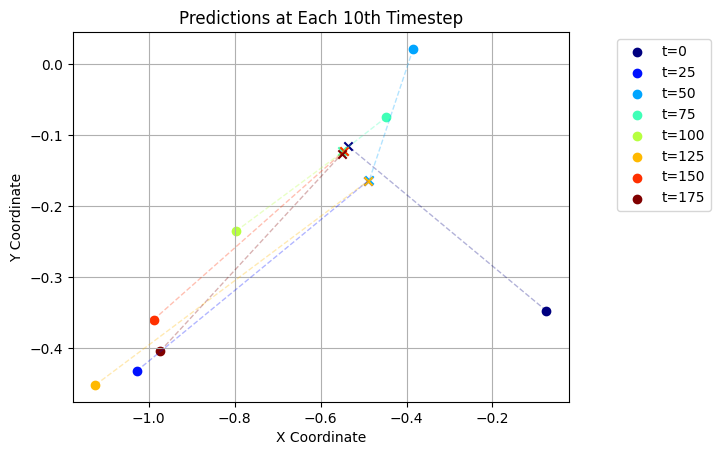

Epoch: [1][50/79]	Time 0.016	ELBO -1.4556e+04	 MSE: 1.6504e+01	 MSM: 0.0000e+00
MSE: 0.04046
Pred MSE: 0.04085
Epoch: [2][50/79]	Time 0.016	ELBO -1.3704e+04	 MSE: 1.5847e+01	 MSM: 0.0000e+00
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
5
MSE: 0.04051
Pred MSE: 0.04081
Epoch: [3][50/79]	Time 0.011	ELBO -1.4264e+04	 MSE: 1.6486e+01	 MSM: 0.0000e+00
MSE: 0.04015
Pred MSE: 0.04042
Epoch: [4][50/79]	Time 0.017	ELBO -1.3469e+04	 MSE: 1.5857e+01	 MSM: 0.0000e+00
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
5
MSE: 0.04048
Pred MSE: 0.04006
Epoch: [5][50/79]	Time 0.170	ELBO -1.4537e+04	 MSE: 1.5682e+01	 MSM: -5.9548e+02
MSE: 0.04001
Pred MSE: 0.03970


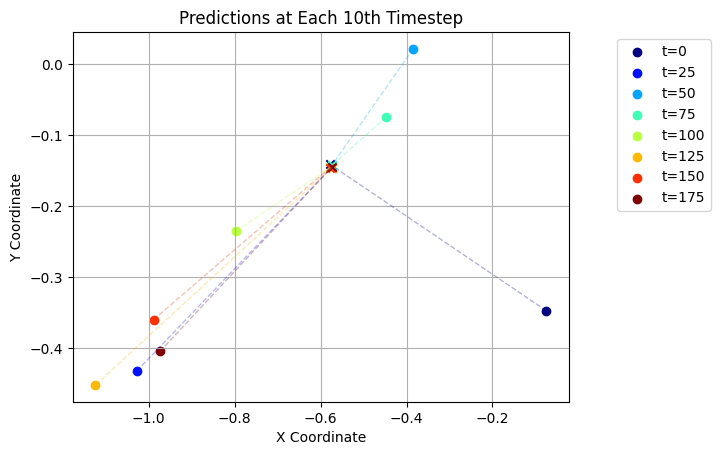

Epoch: [6][50/79]	Time 0.163	ELBO -5.2552e+03	 MSE: 6.0018e+00	 MSM: -8.7708e+02
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
5
MSE: 0.01109
Pred MSE: 0.05427
Epoch: [7][50/79]	Time 0.169	ELBO -3.1283e+03	 MSE: 3.8502e+00	 MSM: -6.3040e+02
MSE: 0.00544
Pred MSE: 0.05200
Epoch: [8][50/79]	Time 0.172	ELBO -5.2279e+02	 MSE: 1.1732e+00	 MSM: -6.1067e+02
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
5
MSE: 0.00229
Pred MSE: 0.05230
Epoch: [9][50/79]	Time 0.180	ELBO -3.4935e+02	 MSE: 1.0140e+00	 MSM: -6.0312e+02
MSE: 0.00242
Pred MSE: 0.04882
Epoch: [10][50/79]	Time 0.187	ELBO -1.9276e+02	 MSE: 8.5175e-01	 MSM: -6.0962e+02
tensor([[0.3330, 0.3356, 0.3314],
        [0.3307, 0.3353, 0.3340],
        [0.3319, 0.3364, 0.3317]], device='cuda:0', grad_f

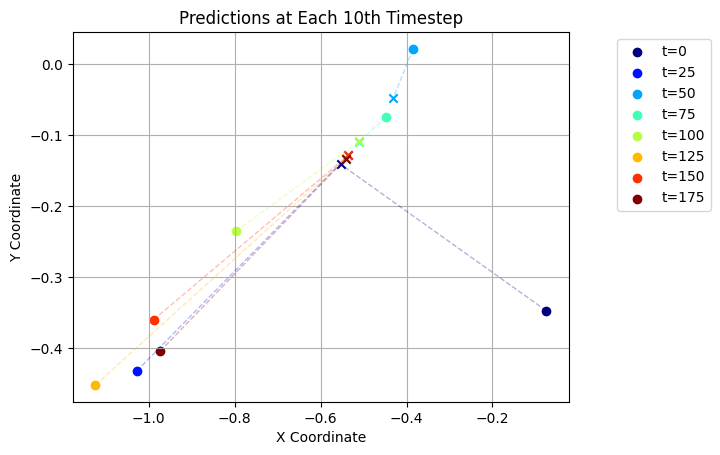

Epoch: [11][50/79]	Time 0.189	ELBO -2.7324e+02	 MSE: 9.3073e-01	 MSM: -6.1233e+02
MSE: 0.00227
Pred MSE: 0.04568
Epoch: [12][50/79]	Time 0.189	ELBO -1.8983e+02	 MSE: 8.5357e-01	 MSM: -6.1307e+02
tensor([[0.3377, 0.3374, 0.3248],
        [0.3246, 0.3397, 0.3357],
        [0.3290, 0.3436, 0.3274]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.3390, 0.3384, 0.3225], device='cuda:0', grad_fn=<SoftmaxBackward0>)
4.5
MSE: 0.00214
Pred MSE: 0.04510
Epoch: [13][50/79]	Time 0.183	ELBO -2.8070e+02	 MSE: 9.5347e-01	 MSM: -6.0697e+02
MSE: 0.00221
Pred MSE: 0.04511
Epoch: [14][50/79]	Time 0.190	ELBO -2.7115e+02	 MSE: 9.4758e-01	 MSM: -6.1041e+02
tensor([[0.3522, 0.3365, 0.3113],
        [0.3125, 0.3490, 0.3384],
        [0.3226, 0.3590, 0.3183]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.3487, 0.3446, 0.3067], device='cuda:0', grad_fn=<SoftmaxBackward0>)
3.2805
MSE: 0.00226
Pred MSE: 0.04511
Epoch: [15][50/79]	Time 0.192	ELBO -1.3632e+02	 MSE: 8.1105e-01	 MSM: -6.0615e+02
MSE

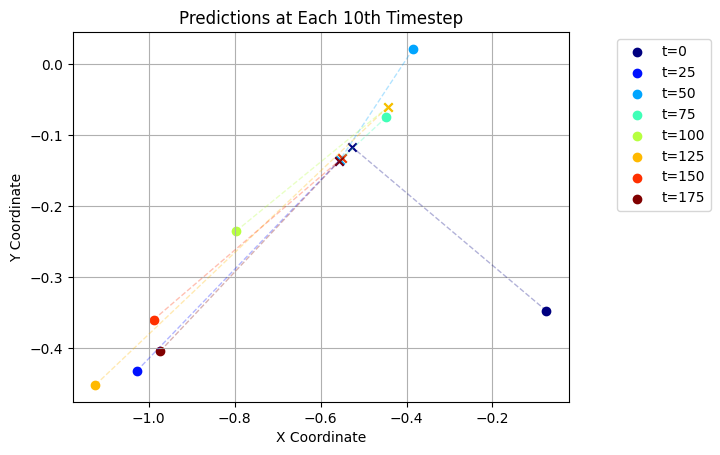

Epoch: [16][50/79]	Time 0.196	ELBO -1.7942e+02	 MSE: 8.4708e-01	 MSM: -6.0656e+02
tensor([[0.3838, 0.3258, 0.2904],
        [0.2898, 0.3656, 0.3446],
        [0.3098, 0.3872, 0.3030]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.3660, 0.3545, 0.2795], device='cuda:0', grad_fn=<SoftmaxBackward0>)
2.3914845000000002
MSE: 0.00214
Pred MSE: 0.04453
Epoch: [17][50/79]	Time 0.192	ELBO -1.9511e+02	 MSE: 8.6447e-01	 MSM: -6.0686e+02
MSE: 0.00224
Pred MSE: 0.04434
Epoch: [18][50/79]	Time 0.190	ELBO -1.7951e+02	 MSE: 8.6193e-01	 MSM: -5.9751e+02
tensor([[0.4586, 0.2944, 0.2469],
        [0.2461, 0.4054, 0.3485],
        [0.2804, 0.4511, 0.2685]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.4011, 0.3705, 0.2283], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1.5690529804500002
MSE: 0.00209
Pred MSE: 0.04445
Epoch: [19][50/79]	Time 0.185	ELBO -1.5474e+02	 MSE: 8.3370e-01	 MSM: -6.0213e+02
MSE: 0.00210
Pred MSE: 0.04475
Epoch: [20][50/79]	Time 0.185	ELBO -1.8606e+02	 MSE: 8.692

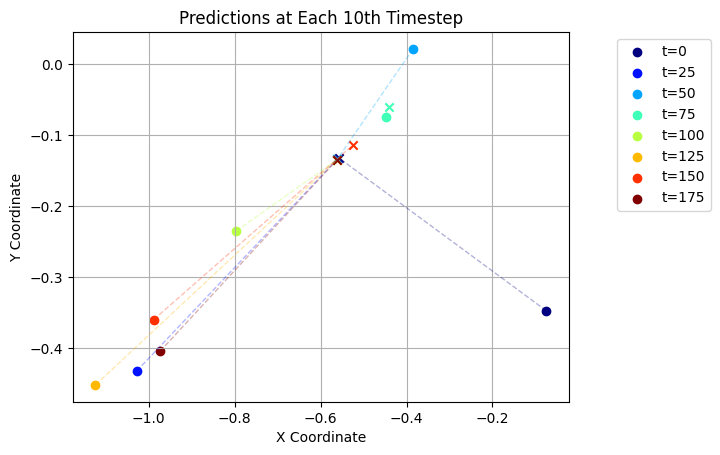

Epoch: [21][50/79]	Time 0.183	ELBO -1.8759e+02	 MSE: 8.6732e-01	 MSM: -6.0305e+02
MSE: 0.00207
Pred MSE: 0.04507
Epoch: [22][50/79]	Time 0.188	ELBO -1.5027e+02	 MSE: 8.3641e-01	 MSM: -5.9770e+02
tensor([[0.6983, 0.1708, 0.1309],
        [0.1543, 0.5523, 0.2934],
        [0.1948, 0.6314, 0.1738]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.4902, 0.3789, 0.1309], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00210
Pred MSE: 0.04482
Epoch: [23][50/79]	Time 0.178	ELBO -1.8705e+02	 MSE: 8.6815e-01	 MSM: -6.0074e+02
MSE: 0.00213
Pred MSE: 0.04491
Epoch: [24][50/79]	Time 0.189	ELBO -1.6925e+02	 MSE: 8.4626e-01	 MSM: -5.9762e+02
tensor([[0.7559, 0.1381, 0.1060],
        [0.1352, 0.5981, 0.2667],
        [0.1750, 0.6718, 0.1533]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5043, 0.3816, 0.1140], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00205
Pred MSE: 0.04476
Epoch: [25][50/79]	Time 0.182	ELBO -1.2654e+02	 MSE: 8.1079e-01	 MSM: -5.9606e+02
MSE: 0.002

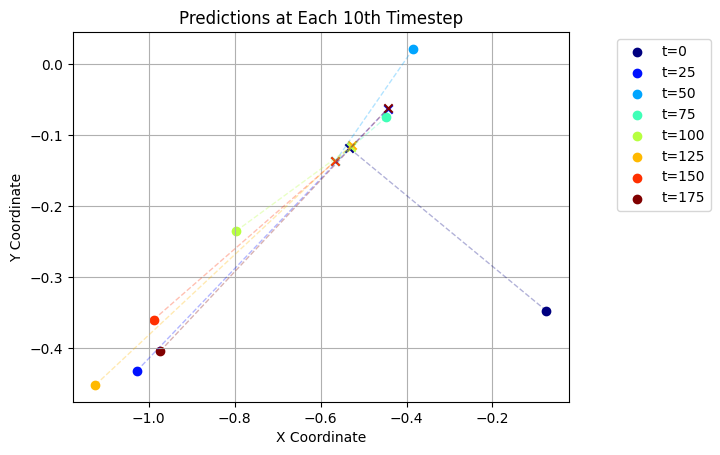

Epoch: [26][50/79]	Time 0.178	ELBO -1.4550e+02	 MSE: 8.3465e-01	 MSM: -5.9361e+02
tensor([[0.7980, 0.1143, 0.0877],
        [0.1195, 0.6307, 0.2499],
        [0.1593, 0.7029, 0.1378]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5116, 0.3879, 0.1005], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00213
Pred MSE: 0.04532
Epoch: [27][50/79]	Time 0.185	ELBO -1.1087e+02	 MSE: 7.9384e-01	 MSM: -5.9359e+02
MSE: 0.00206
Pred MSE: 0.04532
Epoch: [28][50/79]	Time 0.182	ELBO -1.6600e+02	 MSE: 8.5222e-01	 MSM: -5.8985e+02
tensor([[0.8310, 0.0956, 0.0735],
        [0.1063, 0.6565, 0.2372],
        [0.1465, 0.7278, 0.1256]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5168, 0.3939, 0.0893], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00207
Pred MSE: 0.04518
Epoch: [29][50/79]	Time 0.185	ELBO -1.3944e+02	 MSE: 8.3123e-01	 MSM: -5.8451e+02
MSE: 0.00209
Pred MSE: 0.04523
Epoch: [30][50/79]	Time 0.193	ELBO -1.2489e+02	 MSE: 8.1482e-01	 MSM: -5.8532e+02
tensor([[0

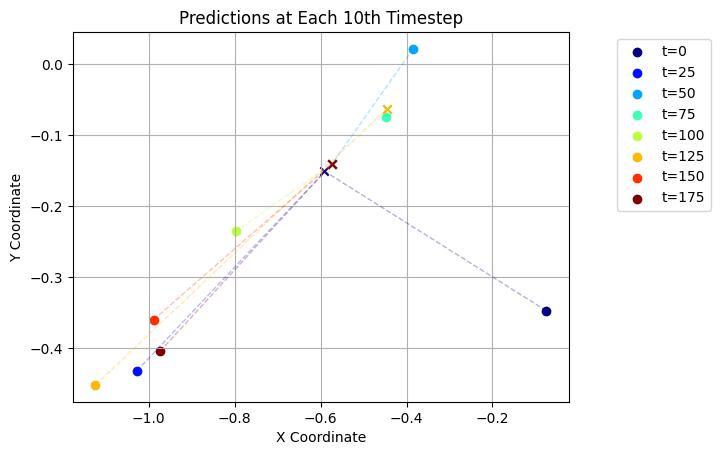

Epoch: [31][50/79]	Time 0.189	ELBO -1.2295e+02	 MSE: 8.2442e-01	 MSM: -5.7702e+02
MSE: 0.00206
Pred MSE: 0.04571
Epoch: [32][50/79]	Time 0.187	ELBO -1.5049e+02	 MSE: 8.4383e-01	 MSM: -5.8228e+02
tensor([[0.8766, 0.0697, 0.0537],
        [0.0868, 0.7102, 0.2030],
        [0.1261, 0.7674, 0.1065]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5245, 0.4033, 0.0722], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00212
Pred MSE: 0.04582
Epoch: [33][50/79]	Time 0.190	ELBO -1.3592e+02	 MSE: 8.2583e-01	 MSM: -5.7992e+02
MSE: 0.00204
Pred MSE: 0.04611
Epoch: [34][50/79]	Time 0.182	ELBO -1.2112e+02	 MSE: 8.1868e-01	 MSM: -5.7627e+02
tensor([[0.8921, 0.0609, 0.0470],
        [0.0800, 0.7404, 0.1796],
        [0.1196, 0.7809, 0.0995]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5316, 0.4026, 0.0659], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00207
Pred MSE: 0.04649
Epoch: [35][50/79]	Time 0.192	ELBO -1.3235e+02	 MSE: 8.2862e-01	 MSM: -5.6887e+02
MSE: 0.002

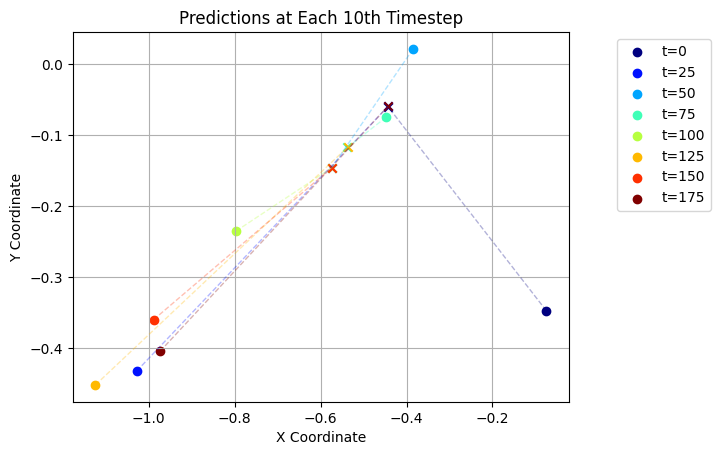

Epoch: [36][50/79]	Time 0.191	ELBO -1.2119e+02	 MSE: 8.1929e-01	 MSM: -5.6482e+02
tensor([[0.9048, 0.0535, 0.0416],
        [0.0738, 0.7826, 0.1437],
        [0.1158, 0.7913, 0.0929]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5417, 0.3980, 0.0603], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00204
Pred MSE: 0.04580
Epoch: [37][50/79]	Time 0.187	ELBO -1.0930e+02	 MSE: 8.0660e-01	 MSM: -5.5995e+02
MSE: 0.00203
Pred MSE: 0.04634
Epoch: [38][50/79]	Time 0.183	ELBO -1.1101e+02	 MSE: 8.0793e-01	 MSM: -5.5361e+02
tensor([[0.9155, 0.0471, 0.0374],
        [0.0670, 0.8235, 0.1095],
        [0.1147, 0.7986, 0.0866]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5560, 0.3886, 0.0554], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00208
Pred MSE: 0.04648
Epoch: [39][50/79]	Time 0.190	ELBO -1.1062e+02	 MSE: 7.9999e-01	 MSM: -5.4019e+02
MSE: 0.00197
Pred MSE: 0.04648
Epoch: [40][50/79]	Time 0.185	ELBO -8.7962e+01	 MSE: 7.7333e-01	 MSM: -5.1757e+02
tensor([[0

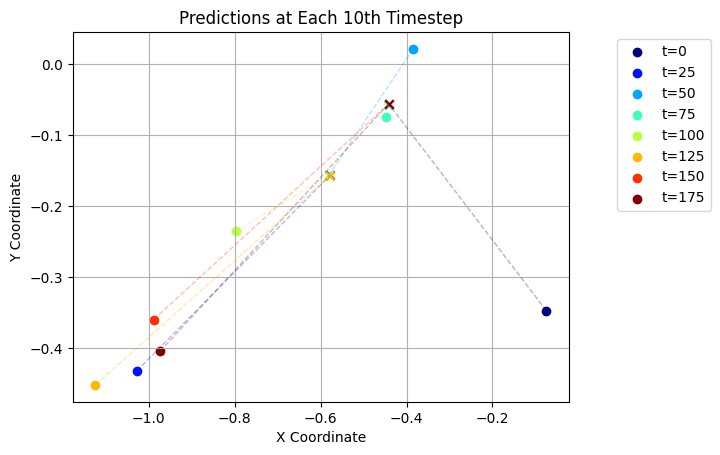

Epoch: [41][50/79]	Time 0.161	ELBO -5.6008e+01	 MSE: 7.2854e-01	 MSM: -5.0888e+02
MSE: 0.00185
Pred MSE: 0.04678
Epoch: [42][50/79]	Time 0.192	ELBO -3.3113e+01	 MSE: 6.9305e-01	 MSM: -4.9671e+02
tensor([[0.9311, 0.0367, 0.0322],
        [0.0609, 0.8635, 0.0756],
        [0.1221, 0.8031, 0.0747]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5864, 0.3669, 0.0468], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00176
Pred MSE: 0.04745
Epoch: [43][50/79]	Time 0.191	ELBO -3.0970e+01	 MSE: 6.7124e-01	 MSM: -4.8520e+02
MSE: 0.00168
Pred MSE: 0.04789
Epoch: [44][50/79]	Time 0.191	ELBO -1.4881e+01	 MSE: 6.5191e-01	 MSM: -4.6706e+02
tensor([[0.9353, 0.0331, 0.0315],
        [0.0617, 0.8703, 0.0680],
        [0.1202, 0.8125, 0.0673]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5995, 0.3572, 0.0433], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00161
Pred MSE: 0.04858
Epoch: [45][50/79]	Time 0.191	ELBO 5.9410e+00	 MSE: 6.2544e-01	 MSM: -4.4811e+02
MSE: 0.0015

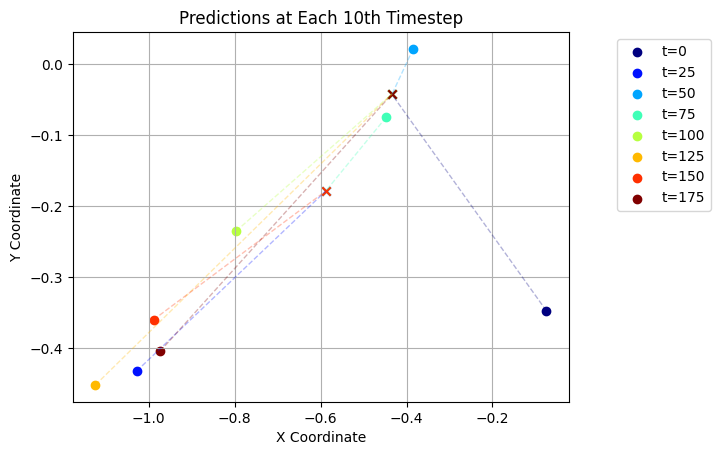

Epoch: [46][50/79]	Time 0.192	ELBO 3.0545e+01	 MSE: 6.0103e-01	 MSM: -4.3372e+02
tensor([[0.9374, 0.0308, 0.0318],
        [0.0631, 0.8737, 0.0631],
        [0.1173, 0.8206, 0.0621]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.6090, 0.3498, 0.0411], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00146
Pred MSE: 0.04844
Epoch: [47][50/79]	Time 0.183	ELBO 7.1052e+01	 MSE: 5.6527e-01	 MSM: -4.0986e+02
MSE: 0.00138
Pred MSE: 0.04832
Epoch: [48][50/79]	Time 0.187	ELBO 1.0913e+02	 MSE: 5.1625e-01	 MSM: -3.9762e+02
tensor([[0.9384, 0.0289, 0.0327],
        [0.0654, 0.8755, 0.0591],
        [0.1124, 0.8300, 0.0576]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.6171, 0.3439, 0.0390], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00118
Pred MSE: 0.04907
Epoch: [49][50/79]	Time 0.191	ELBO 1.2936e+02	 MSE: 4.5522e-01	 MSM: -3.8379e+02
MSE: 0.00096
Pred MSE: 0.04939
Epoch: [50][50/79]	Time 0.191	ELBO 2.3319e+02	 MSE: 3.3665e-01	 MSM: -3.7502e+02
tensor([[0.9390

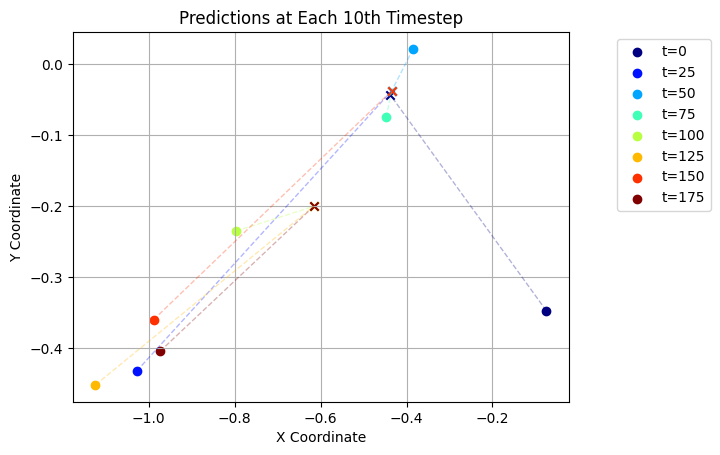

Epoch: [51][50/79]	Time 0.185	ELBO 2.7971e+02	 MSE: 2.8426e-01	 MSM: -3.5938e+02
MSE: 0.00065
Pred MSE: 0.04936
Epoch: [52][50/79]	Time 0.191	ELBO 2.9663e+02	 MSE: 2.6018e-01	 MSM: -3.4696e+02
tensor([[0.9396, 0.0273, 0.0332],
        [0.0669, 0.8784, 0.0547],
        [0.1103, 0.8356, 0.0540]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.6251, 0.3382, 0.0367], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00076
Pred MSE: 0.04968
Epoch: [53][50/79]	Time 0.190	ELBO 3.2187e+02	 MSE: 2.3564e-01	 MSM: -3.5324e+02
MSE: 0.00067
Pred MSE: 0.04979
Epoch: [54][50/79]	Time 0.196	ELBO 2.9398e+02	 MSE: 2.6070e-01	 MSM: -3.5236e+02
tensor([[0.9395, 0.0269, 0.0336],
        [0.0675, 0.8788, 0.0537],
        [0.1094, 0.8372, 0.0533]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.6268, 0.3370, 0.0361], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00061
Pred MSE: 0.04981
Epoch: [55][50/79]	Time 0.193	ELBO 2.8864e+02	 MSE: 2.6688e-01	 MSM: -3.5214e+02
MSE: 0.00056
Pr

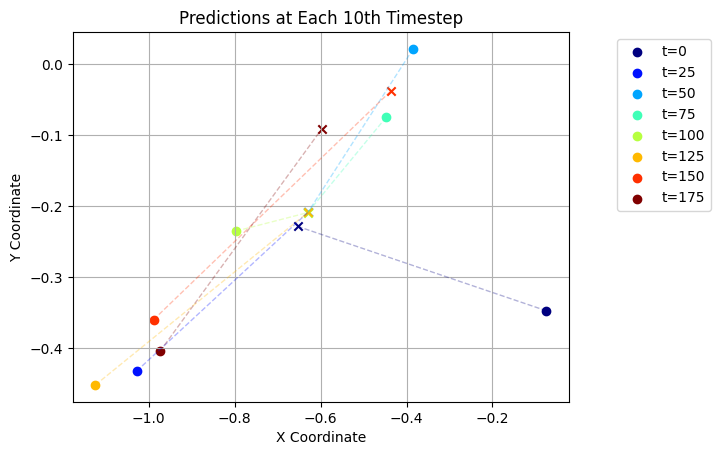

Epoch: [56][50/79]	Time 0.182	ELBO 3.1290e+02	 MSE: 2.4113e-01	 MSM: -3.4700e+02
tensor([[0.9393, 0.0265, 0.0343],
        [0.0682, 0.8790, 0.0527],
        [0.1081, 0.8394, 0.0526]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.6278, 0.3366, 0.0355], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00062
Pred MSE: 0.04983
Epoch: [57][50/79]	Time 0.184	ELBO 3.3291e+02	 MSE: 2.2173e-01	 MSM: -3.4323e+02
MSE: 0.00061
Pred MSE: 0.05025
Epoch: [58][50/79]	Time 0.160	ELBO 3.0320e+02	 MSE: 2.4679e-01	 MSM: -3.4080e+02
tensor([[0.9389, 0.0260, 0.0352],
        [0.0693, 0.8789, 0.0517],
        [0.1060, 0.8425, 0.0515]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.6294, 0.3358, 0.0348], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00057
Pred MSE: 0.05061
Epoch: [59][50/79]	Time 0.193	ELBO 3.3144e+02	 MSE: 2.2465e-01	 MSM: -3.3698e+02
MSE: 0.00054
Pred MSE: 0.05048
Epoch: [60][50/79]	Time 0.188	ELBO 3.2944e+02	 MSE: 2.2859e-01	 MSM: -3.3008e+02
tensor([[0.9383

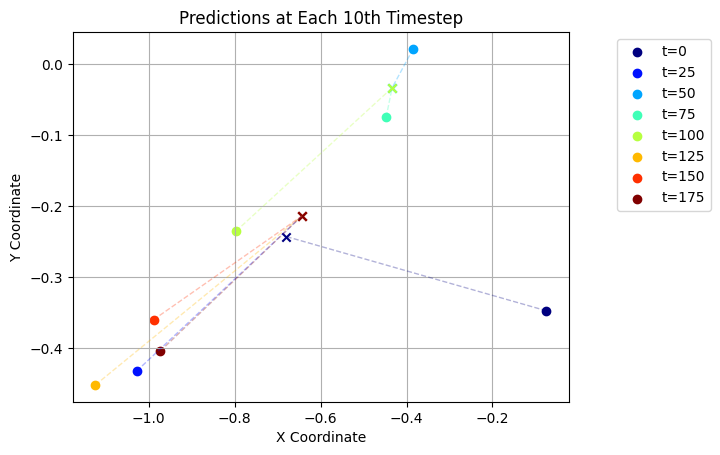

Epoch: [61][50/79]	Time 0.192	ELBO 3.4257e+02	 MSE: 2.1590e-01	 MSM: -3.2196e+02
MSE: 0.00054
Pred MSE: 0.05096
Epoch: [62][50/79]	Time 0.192	ELBO 3.4477e+02	 MSE: 2.1325e-01	 MSM: -3.1290e+02
tensor([[0.9373, 0.0242, 0.0385],
        [0.0733, 0.8777, 0.0491],
        [0.0950, 0.8585, 0.0465]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.6343, 0.3335, 0.0323], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00053
Pred MSE: 0.05093
Epoch: [63][50/79]	Time 0.193	ELBO 3.5218e+02	 MSE: 2.1368e-01	 MSM: -2.9424e+02
MSE: 0.00056
Pred MSE: 0.05143
Epoch: [64][50/79]	Time 0.192	ELBO 3.5086e+02	 MSE: 2.0969e-01	 MSM: -2.8882e+02
tensor([[0.9363, 0.0234, 0.0403],
        [0.0751, 0.8769, 0.0480],
        [0.0888, 0.8675, 0.0436]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.6366, 0.3324, 0.0310], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00052
Pred MSE: 0.05232
Epoch: [65][50/79]	Time 0.187	ELBO 3.5513e+02	 MSE: 2.0942e-01	 MSM: -2.8243e+02
MSE: 0.00053
Pr

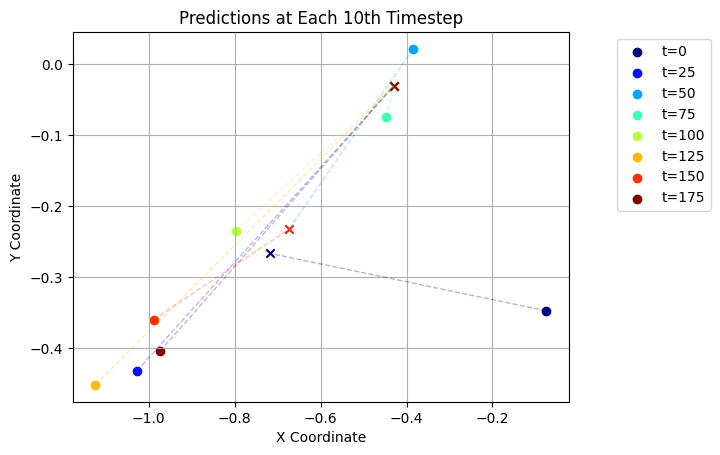

Epoch: [66][50/79]	Time 0.191	ELBO 3.5158e+02	 MSE: 2.1158e-01	 MSM: -2.7590e+02
tensor([[0.9353, 0.0227, 0.0420],
        [0.0769, 0.8759, 0.0472],
        [0.0828, 0.8763, 0.0408]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.6373, 0.3328, 0.0299], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00052
Pred MSE: 0.05262
Epoch: [67][50/79]	Time 0.186	ELBO 3.5308e+02	 MSE: 2.0522e-01	 MSM: -2.6954e+02
MSE: 0.00052
Pred MSE: 0.05364
Epoch: [68][50/79]	Time 0.191	ELBO 3.6322e+02	 MSE: 2.0592e-01	 MSM: -2.5143e+02
tensor([[0.9341, 0.0219, 0.0439],
        [0.0788, 0.8747, 0.0464],
        [0.0771, 0.8850, 0.0380]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.6389, 0.3323, 0.0288], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00053
Pred MSE: 0.05412
Epoch: [69][50/79]	Time 0.189	ELBO 3.5145e+02	 MSE: 2.0919e-01	 MSM: -2.5187e+02
MSE: 0.00052
Pred MSE: 0.05487
Epoch: [70][50/79]	Time 0.191	ELBO 3.5829e+02	 MSE: 2.1049e-01	 MSM: -2.4042e+02
tensor([[0.9329

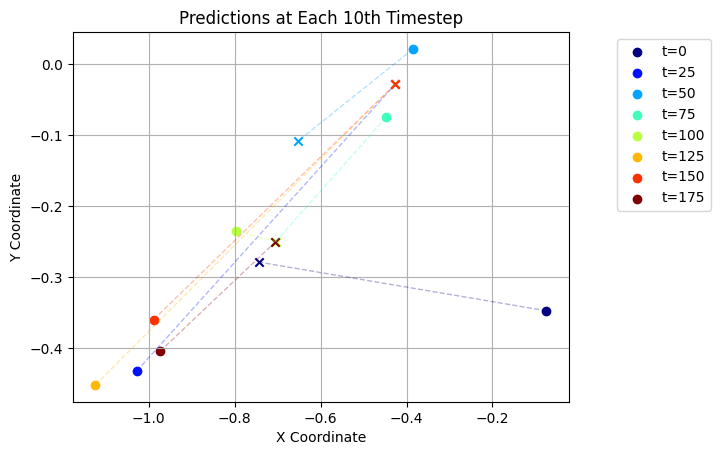

Epoch: [71][50/79]	Time 0.192	ELBO 3.6216e+02	 MSE: 2.0726e-01	 MSM: -2.3162e+02
MSE: 0.00051
Pred MSE: 0.05544
Epoch: [72][50/79]	Time 0.190	ELBO 3.6452e+02	 MSE: 2.0681e-01	 MSM: -2.2160e+02
tensor([[0.9318, 0.0205, 0.0477],
        [0.0824, 0.8724, 0.0452],
        [0.0680, 0.8991, 0.0329]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.6429, 0.3303, 0.0267], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00051
Pred MSE: 0.05634
Epoch: [73][50/79]	Time 0.185	ELBO 3.6168e+02	 MSE: 2.0556e-01	 MSM: -2.1580e+02
MSE: 0.00051
Pred MSE: 0.05547
Epoch: [74][50/79]	Time 0.190	ELBO 3.6183e+02	 MSE: 2.0766e-01	 MSM: -2.1136e+02
tensor([[0.9309, 0.0198, 0.0493],
        [0.0839, 0.8715, 0.0446],
        [0.0652, 0.9038, 0.0310]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.6435, 0.3306, 0.0259], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00051
Pred MSE: 0.05742
Epoch: [75][50/79]	Time 0.185	ELBO 3.6596e+02	 MSE: 2.0653e-01	 MSM: -2.0263e+02
MSE: 0.00052
Pr

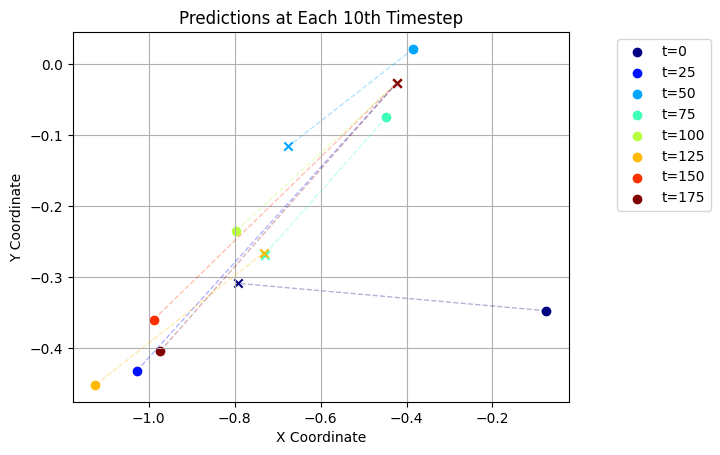

Epoch: [76][50/79]	Time 0.183	ELBO 3.6232e+02	 MSE: 2.0483e-01	 MSM: -1.9796e+02
tensor([[0.9300, 0.0192, 0.0509],
        [0.0853, 0.8707, 0.0440],
        [0.0634, 0.9073, 0.0293]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.6440, 0.3309, 0.0251], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00051
Pred MSE: 0.05828
Epoch: [77][50/79]	Time 0.188	ELBO 3.6570e+02	 MSE: 2.0871e-01	 MSM: -1.8855e+02
MSE: 0.00052
Pred MSE: 0.05882
Epoch: [78][50/79]	Time 0.189	ELBO 3.6316e+02	 MSE: 2.0353e-01	 MSM: -1.8674e+02
tensor([[0.9293, 0.0184, 0.0523],
        [0.0866, 0.8699, 0.0435],
        [0.0626, 0.9096, 0.0278]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.6448, 0.3310, 0.0243], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00051
Pred MSE: 0.05894
Epoch: [79][50/79]	Time 0.182	ELBO 3.7075e+02	 MSE: 2.0633e-01	 MSM: -1.7607e+02
MSE: 0.00054
Pred MSE: 0.05990
Epoch: [80][50/79]	Time 0.186	ELBO 3.7129e+02	 MSE: 2.0152e-01	 MSM: -1.7395e+02
tensor([[0.9284

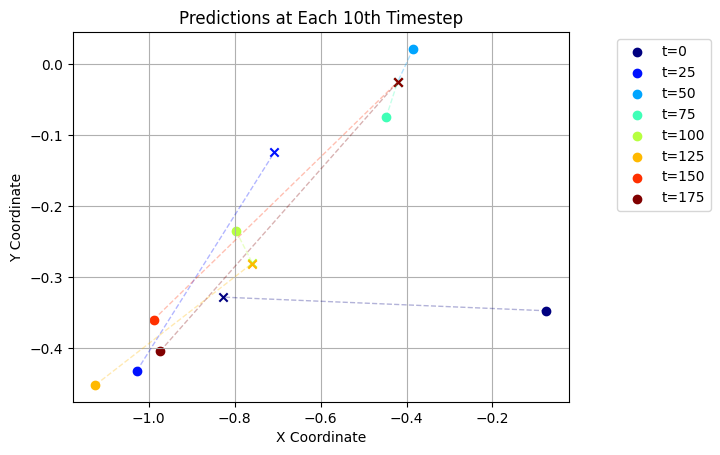

Epoch: [81][50/79]	Time 0.192	ELBO 3.7391e+02	 MSE: 1.9968e-01	 MSM: -1.6623e+02
MSE: 0.00051
Pred MSE: 0.06089
Epoch: [82][50/79]	Time 0.192	ELBO 3.7222e+02	 MSE: 2.0099e-01	 MSM: -1.6440e+02
tensor([[0.9278, 0.0172, 0.0551],
        [0.0889, 0.8689, 0.0423],
        [0.0644, 0.9101, 0.0255]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.6465, 0.3307, 0.0228], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00052
Pred MSE: 0.06079
Epoch: [83][50/79]	Time 0.192	ELBO 3.7308e+02	 MSE: 2.0362e-01	 MSM: -1.5847e+02
MSE: 0.00051
Pred MSE: 0.06211
Epoch: [84][50/79]	Time 0.192	ELBO 3.7835e+02	 MSE: 1.9979e-01	 MSM: -1.5323e+02
tensor([[0.9274, 0.0167, 0.0559],
        [0.0895, 0.8689, 0.0416],
        [0.0663, 0.9088, 0.0249]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.6467, 0.3310, 0.0223], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00050
Pred MSE: 0.06222
Epoch: [85][50/79]	Time 0.184	ELBO 3.7852e+02	 MSE: 2.0432e-01	 MSM: -1.4818e+02
MSE: 0.00051
Pr

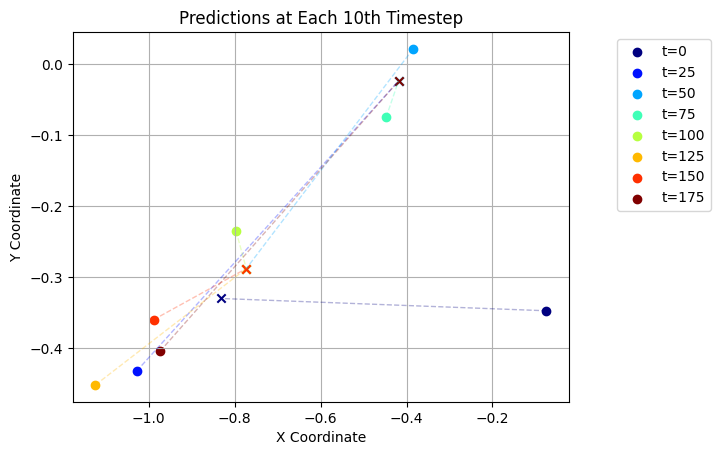

Epoch: [86][50/79]	Time 0.185	ELBO 3.7938e+02	 MSE: 2.0398e-01	 MSM: -1.4658e+02
tensor([[0.9272, 0.0164, 0.0564],
        [0.0898, 0.8689, 0.0413],
        [0.0678, 0.9076, 0.0246]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.6473, 0.3308, 0.0220], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00050
Pred MSE: 0.06198
Epoch: [87][50/79]	Time 0.194	ELBO 3.6985e+02	 MSE: 2.0659e-01	 MSM: -1.5324e+02
MSE: 0.00051
Pred MSE: 0.06217
Epoch: [88][50/79]	Time 0.191	ELBO 3.7840e+02	 MSE: 2.0331e-01	 MSM: -1.4615e+02
tensor([[0.9270, 0.0160, 0.0570],
        [0.0904, 0.8688, 0.0408],
        [0.0700, 0.9057, 0.0243]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.6476, 0.3308, 0.0215], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00052
Pred MSE: 0.06334
Epoch: [89][50/79]	Time 0.192	ELBO 3.7324e+02	 MSE: 2.0329e-01	 MSM: -1.4936e+02
MSE: 0.00051
Pred MSE: 0.06256
Epoch: [90][50/79]	Time 0.192	ELBO 3.7363e+02	 MSE: 2.0221e-01	 MSM: -1.5088e+02
tensor([[0.9268

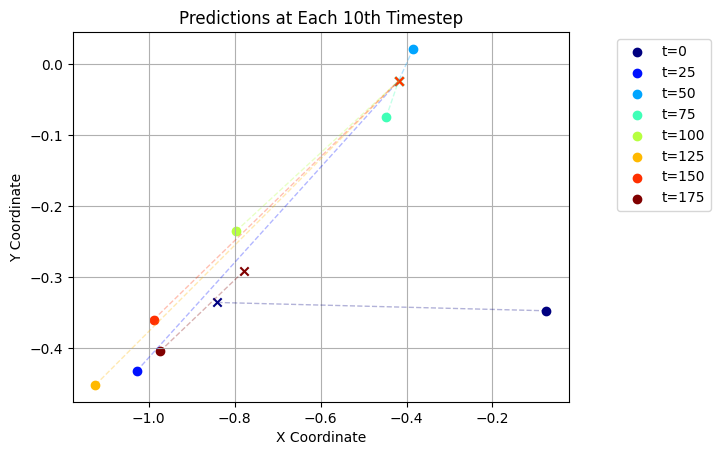

Epoch: [91][50/79]	Time 0.195	ELBO 3.6938e+02	 MSE: 2.0363e-01	 MSM: -1.5087e+02
MSE: 0.00051
Pred MSE: 0.06346
Epoch: [92][50/79]	Time 0.183	ELBO 3.8433e+02	 MSE: 1.9831e-01	 MSM: -1.3771e+02
tensor([[0.9264, 0.0152, 0.0584],
        [0.0910, 0.8692, 0.0398],
        [0.0759, 0.8999, 0.0241]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.6478, 0.3315, 0.0207], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00051
Pred MSE: 0.06297
Epoch: [93][50/79]	Time 0.183	ELBO 3.7596e+02	 MSE: 2.0016e-01	 MSM: -1.4523e+02
MSE: 0.00050
Pred MSE: 0.06323
Epoch: [94][50/79]	Time 0.185	ELBO 3.7856e+02	 MSE: 2.0554e-01	 MSM: -1.4129e+02
tensor([[0.9261, 0.0150, 0.0590],
        [0.0911, 0.8695, 0.0394],
        [0.0785, 0.8974, 0.0241]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.6477, 0.3319, 0.0204], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00051
Pred MSE: 0.06392
Epoch: [95][50/79]	Time 0.190	ELBO 3.7380e+02	 MSE: 2.0472e-01	 MSM: -1.4463e+02
MSE: 0.00052
Pr

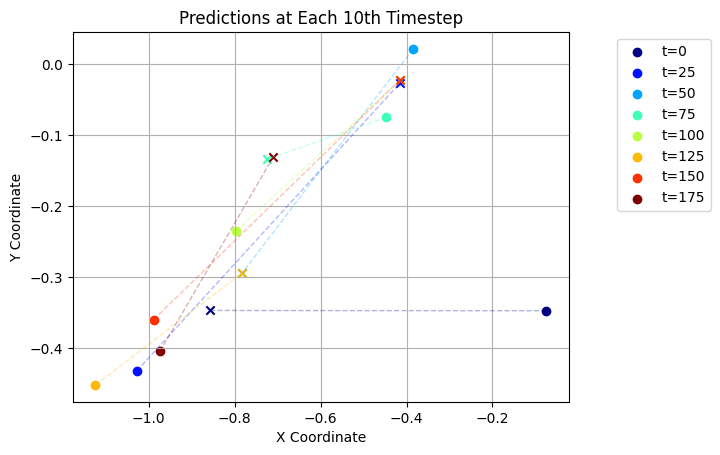

Epoch: [96][50/79]	Time 0.191	ELBO 3.7291e+02	 MSE: 2.0190e-01	 MSM: -1.4454e+02
tensor([[0.9258, 0.0148, 0.0594],
        [0.0911, 0.8698, 0.0391],
        [0.0803, 0.8955, 0.0241]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.6480, 0.3319, 0.0202], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00050
Pred MSE: 0.06413
Epoch: [97][50/79]	Time 0.190	ELBO 3.7259e+02	 MSE: 2.0403e-01	 MSM: -1.4399e+02
MSE: 0.00051
Pred MSE: 0.06434
Epoch: [98][50/79]	Time 0.191	ELBO 3.7476e+02	 MSE: 2.0343e-01	 MSM: -1.3850e+02
tensor([[0.9255, 0.0146, 0.0599],
        [0.0909, 0.8704, 0.0387],
        [0.0825, 0.8934, 0.0241]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.6480, 0.3321, 0.0200], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00051
Pred MSE: 0.06408
Epoch: [99][50/79]	Time 0.191	ELBO 3.7539e+02	 MSE: 2.0521e-01	 MSM: -1.4198e+02
MSE: 0.00050
Pred MSE: 0.06485


In [13]:
elbo_losses, test_mse, pred_mse_elbo = train(model, optimizer, num_states, dim_latent, T)

In [10]:
PATH = 'snlds_coord_elbo.pth'
# torch.save(model.state_dict(), PATH)
model.transitions = torch.nn.ModuleList([MLP(dim_latent, dim_latent, 16, 'cos') for _ in range(num_states)]).to(device).float()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [15]:
test_mse, pred_mse_elbo

([0.04012009389698505,
  0.040463659539818765,
  0.04050716944038868,
  0.040148180723190305,
  0.040477276965975764,
  0.04000980108976364,
  0.01108721997588873,
  0.005438888445496559,
  0.002292810590006411,
  0.002415709965862334,
  0.002205750299617648,
  0.0022717759478837253,
  0.0021395696792751552,
  0.0022050288738682867,
  0.0022601204458624125,
  0.0021295889746397734,
  0.0021419524913653732,
  0.002242891537025571,
  0.002085767942480743,
  0.002101031970232725,
  0.002162366989068687,
  0.00207030491437763,
  0.0021000428358092906,
  0.002132914518006146,
  0.00204938625684008,
  0.0020886547164991496,
  0.0021315672202035785,
  0.0020598685601726173,
  0.0020719785476103424,
  0.0020936930552124975,
  0.002053589397110045,
  0.002055111760273576,
  0.0021170596359297634,
  0.0020411745412275196,
  0.0020668760407716036,
  0.0020985887851566075,
  0.0020438551902770994,
  0.002030426054261625,
  0.0020829047542065384,
  0.0019747325102798642,
  0.001890250644646585,
  0

Text(0, 0.5, 'Training Loss')

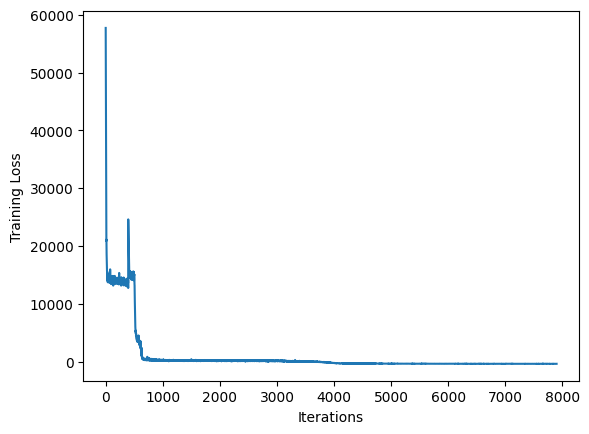

In [16]:
plt.plot(elbo_losses)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')

Text(0, 0.5, 'Training Loss')

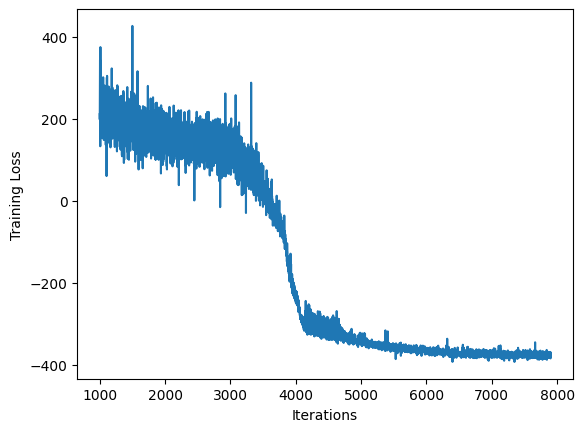

In [17]:
plt.plot(np.arange(1000,len(elbo_losses)),elbo_losses[1000:])
plt.xlabel('Iterations')
plt.ylabel('Training Loss')

Text(0, 0.5, 'MSE')

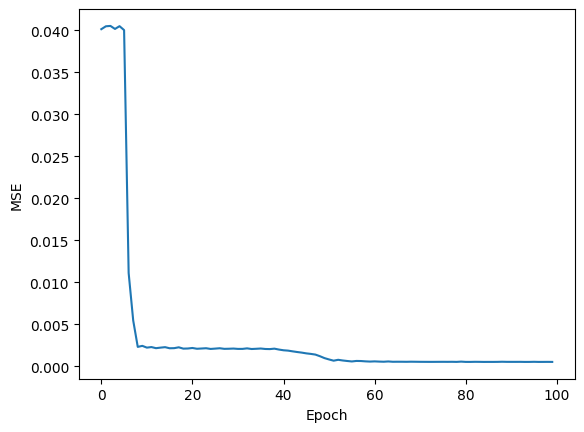

In [18]:
plt.plot(test_mse)
plt.xlabel('Epoch')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

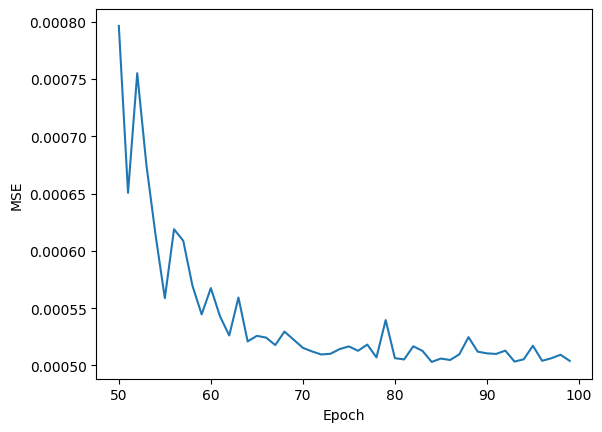

In [19]:
plt.plot(np.arange(50,len(test_mse)),test_mse[50:])
plt.xlabel('Epoch')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

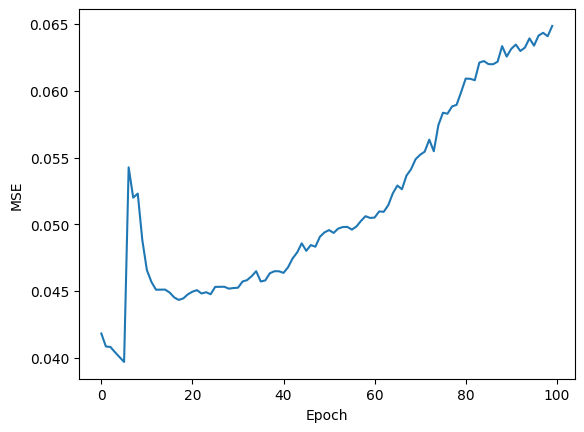

In [20]:
plt.plot(pred_mse_elbo)
plt.xlabel('Epoch')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

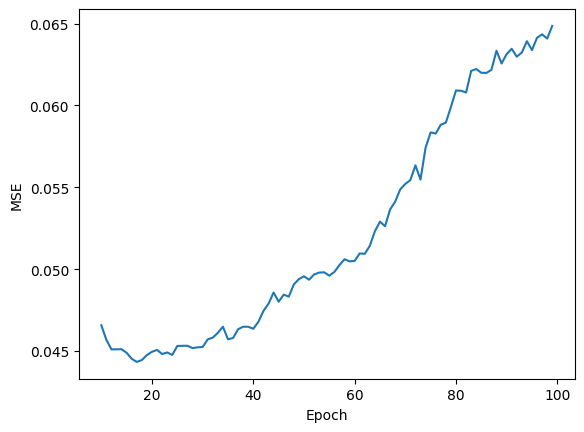

In [21]:
plt.plot(np.arange(10,len(pred_mse_elbo)),pred_mse_elbo[10:])
plt.xlabel('Epoch')
plt.ylabel('MSE')

In [22]:
# Training time: 26.5min
print(f"Last ELBO Loss: {elbo_losses[-1]:.1f}")
print(f"Last Test MSE: {test_mse[-1]:.6f}")
print(f"Last Pred MSE: {pred_mse_elbo[-1]:.6f}")

Last ELBO Loss: -372.9
Last Test MSE: 0.000504
Last Pred MSE: 0.064852


In [23]:
print(f"Best ELBO Loss: {min(elbo_losses):.1f}")
print(f"Best Test MSE: {min(test_mse):.6f}")
print(f"Best Pred MSE: {min(pred_mse_elbo):.6f}")

Best ELBO Loss: -393.3
Best Test MSE: 0.000503
Best Pred MSE: 0.039695


In [24]:
# Reconstructions

t = 200
model.eval()

with torch.inference_mode():
    (x,) = next(iter(test_dataloader))
    x = x.to(device).float()
    recon_x,_,_,_ = model(x)
    x = x.cpu().numpy()
    recon_x = recon_x.cpu().numpy()

# Final MSE per timestep
mse_T = np.mean(((x - recon_x) ** 2),axis=(0,2))
for i,element in enumerate(mse_T):
    print(f"t={i} MSE per pixel:{element:.6f}")

t=0 MSE per pixel:0.000880
t=1 MSE per pixel:0.000585
t=2 MSE per pixel:0.000527
t=3 MSE per pixel:0.000459
t=4 MSE per pixel:0.000557
t=5 MSE per pixel:0.000658
t=6 MSE per pixel:0.000504
t=7 MSE per pixel:0.000469
t=8 MSE per pixel:0.000555
t=9 MSE per pixel:0.000444
t=10 MSE per pixel:0.000377
t=11 MSE per pixel:0.000603
t=12 MSE per pixel:0.000510
t=13 MSE per pixel:0.000497
t=14 MSE per pixel:0.000600
t=15 MSE per pixel:0.000548
t=16 MSE per pixel:0.000510
t=17 MSE per pixel:0.000478
t=18 MSE per pixel:0.000417
t=19 MSE per pixel:0.000413
t=20 MSE per pixel:0.000588
t=21 MSE per pixel:0.000609
t=22 MSE per pixel:0.000483
t=23 MSE per pixel:0.000477
t=24 MSE per pixel:0.000457
t=25 MSE per pixel:0.000576
t=26 MSE per pixel:0.000464
t=27 MSE per pixel:0.000489
t=28 MSE per pixel:0.000551
t=29 MSE per pixel:0.000567
t=30 MSE per pixel:0.000560
t=31 MSE per pixel:0.000735
t=32 MSE per pixel:0.000529
t=33 MSE per pixel:0.000490
t=34 MSE per pixel:0.000468
t=35 MSE per pixel:0.000386
t=

In [25]:
mse_T

array([0.00087987, 0.00058451, 0.00052696, 0.00045939, 0.00055722,
       0.0006583 , 0.00050434, 0.00046895, 0.00055463, 0.00044373,
       0.00037684, 0.00060311, 0.00051001, 0.0004969 , 0.00059953,
       0.00054769, 0.00050997, 0.000478  , 0.00041698, 0.00041338,
       0.00058843, 0.0006094 , 0.00048346, 0.00047691, 0.00045707,
       0.00057629, 0.00046411, 0.00048924, 0.00055139, 0.00056721,
       0.00055964, 0.0007355 , 0.00052887, 0.00048957, 0.00046815,
       0.00038614, 0.00050634, 0.00059069, 0.00054831, 0.00037706,
       0.00045784, 0.00049582, 0.0005281 , 0.00047281, 0.00034238,
       0.00049176, 0.00048313, 0.00052468, 0.0005426 , 0.00044455,
       0.00036141, 0.00049709, 0.00034241, 0.00053636, 0.00057561,
       0.00048046, 0.00052321, 0.00057064, 0.00044223, 0.00053991,
       0.00045492, 0.00053311, 0.00040292, 0.0003621 , 0.00039466,
       0.00061421, 0.00054531, 0.00047545, 0.00055659, 0.00054487,
       0.00064489, 0.00043077, 0.00040809, 0.00043523, 0.00049

Text(0, 0.5, 'MSE per Pixel')

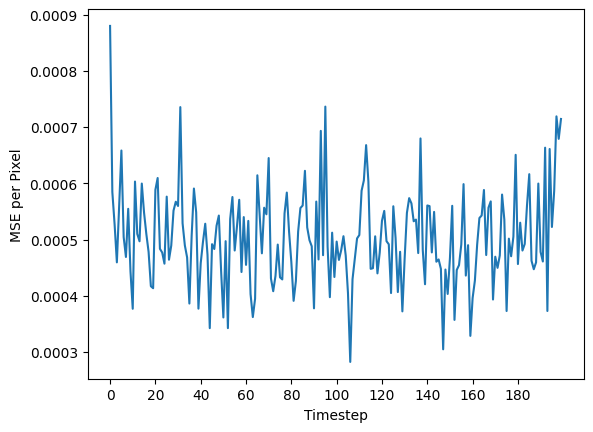

In [27]:
plt.plot(mse_T)
plt.xlabel('Timestep')
plt.xticks(np.arange(0,t,20))
plt.ylabel('MSE per Pixel')

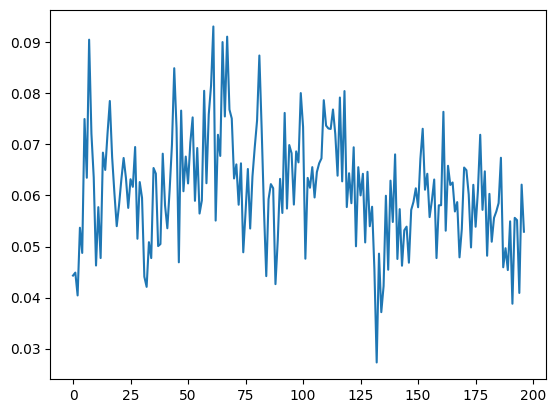

In [28]:
# Take first 3 timesteps. Generate the rest of the sequence. Calculate MSE

with torch.inference_mode():
    predict_mse = []
    for (sample,) in test_dataloader:
        mse_values = []
        obs_var = sample.float().to(device)
        preds = model.predict_sequence(obs_var[:,:3], seq_len=197)
        obs_var, preds = obs_var.cpu().numpy(), preds.cpu().numpy()
        mse = np.mean(((preds - obs_var[:,3:]) ** 2),axis=(0,2))
        mse_values.append(mse)
    mse_val = sum(mse_values) / len(mse_values)
    predict_mse.append(mse_val.tolist())

plt.plot(predict_mse[0])

In [29]:
predict_mse[0]

[0.04430950805544853,
 0.044888485223054886,
 0.040420226752758026,
 0.05368099361658096,
 0.048746947199106216,
 0.07497934252023697,
 0.06347217410802841,
 0.09051782637834549,
 0.07210013270378113,
 0.06354642659425735,
 0.04628105089068413,
 0.05771572142839432,
 0.04774385318160057,
 0.06839349120855331,
 0.0650058314204216,
 0.07214751839637756,
 0.07850765436887741,
 0.06754469871520996,
 0.06041740998625755,
 0.05398646369576454,
 0.058106474578380585,
 0.0630842074751854,
 0.06734252721071243,
 0.06343863159418106,
 0.05756540596485138,
 0.06318581849336624,
 0.06168871372938156,
 0.06949365139007568,
 0.051522474735975266,
 0.0626276507973671,
 0.05953798443078995,
 0.044087328016757965,
 0.04210393875837326,
 0.05085185915231705,
 0.047737542539834976,
 0.06538193672895432,
 0.06428125500679016,
 0.05008922517299652,
 0.050481654703617096,
 0.06818603724241257,
 0.05806218087673187,
 0.053578149527311325,
 0.0610743910074234,
 0.06993216276168823,
 0.08492676913738251,
 0.07

In [11]:
# Check ELBO,IWAE,FIVO values
# We expect FIVO>IWAE>ELBO
model.beta = 1
with torch.inference_mode():
    elbo_list = []
    elbo_2_list = []
    iwae_list = []
    fivo_list = []
    for (sample,) in tqdm.tqdm(test_dataloader):
        obs_var = sample.float().to(device)
        _, _, _, losses = model(obs_var)
        elbo_2, _ = model.iwae_efficient(obs_var, 1)
        iwae, _ = model.iwae_efficient(obs_var, 10)
        fivo, _ = model.fivo_efficient(obs_var, 10)
        elbo = -losses['loss']
        elbo_2 = -elbo_2
        iwae = -iwae
        fivo = -fivo
        elbo_list.append(elbo)
        elbo_2_list.append(elbo_2)
        iwae_list.append(iwae)
        fivo_list.append(fivo)
    print(f"ELBO: {sum(elbo_list)/len(elbo_list):.2f}")
    print(f"ELBO: {sum(elbo_2_list)/len(elbo_2_list):.2f}")
    print(f"IWAE: {sum(iwae_list)/len(iwae_list):.2f}")
    print(f"FIVO: {sum(fivo_list)/len(fivo_list):.2f}")

100%|██████████| 10/10 [00:39<00:00,  3.99s/it]

ELBO: 377.97
ELBO: 378.49
IWAE: 392.70
FIVO: 382.20


In [35]:
def plot_discrete_states(gamma, latents_states):
    # gamma: [B, T, num_states]
    # latents_states: [B, num_states]
    N = 10
    T = gamma.shape[1]
    states = torch.zeros(T, 3)
    states[range(T), latents_states[N, :].long()] = 1

    # Create a figure with two subplots
    fig, axs = plt.subplots(2, 1, figsize=(20, 4), gridspec_kw={'height_ratios': [1, 1], 'hspace': 0.00})

    # First subplot: Ground truth states
    axs[0].set_title("Ground truth states")
    g_t = axs[0].imshow(states[:T, :].T, vmin=0, vmax=1)
    axs[0].set_xticks(np.arange(0, T, T // 10))

    # Second subplot: Posterior p(s_t|X)
    axs[1].set_title("Posterior p(s_t|X)")
    p_s_t = axs[1].imshow(gamma[N, :T, :].T.cpu().numpy(), vmin=0, vmax=1)
    axs[1].set_xticks(np.arange(0, T, T // 10))

    # Add a single colorbar to the left center
    cbar = fig.colorbar(p_s_t, ax=axs, location='right', shrink=0.5)
    cbar.set_label('State Probability')

    # Adjust the subplot layout to reduce space between subplots
    #plt.subplots_adjust(hspace=0.02)

    plt.show()


/tmp/ipykernel_2049935/1833466898.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels([f'{int(label)}' for label in new_labels])


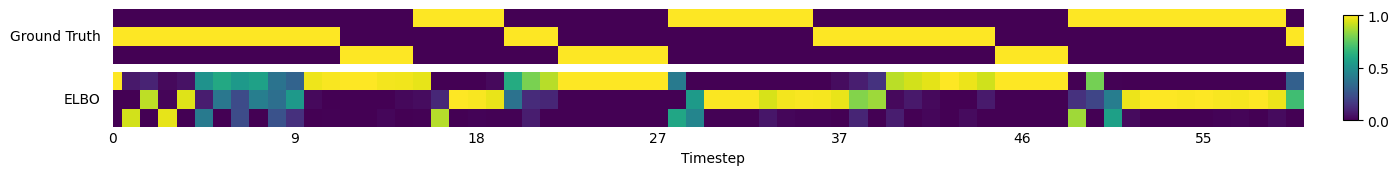

/tmp/ipykernel_2049935/1833466898.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels([f'{int(label)}' for label in new_labels])


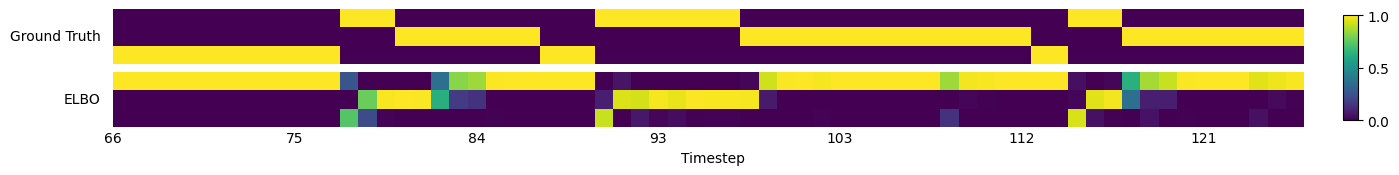

/tmp/ipykernel_2049935/1833466898.py:72: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels([f'{int(label)}' for label in new_labels])


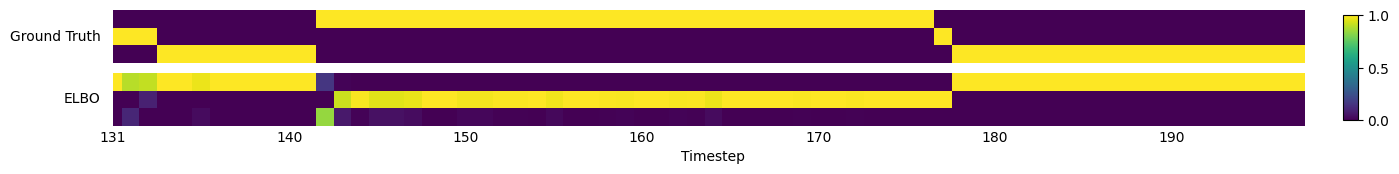

In [136]:
# First 20 timesteps. Probability of discrete states

latent_path = "../../../vol/bitbucket/am9923/datasets/latent_variables/states_test_N_500_T_200_dim_latent_2_dim_obs_2_state_3_sparsity_0.0_net_cosine_seed_24.npy"
latents_dataset = TensorDataset(torch.from_numpy(np.load(latent_path)))
latent_loader = DataLoader(latents_dataset, batch_size=50, shuffle=False)
latent_states = next(iter(latent_loader))[0]



with torch.inference_mode():
    obs = next(iter(test_dataloader))[0]
    gamma = model.gamma(obs[:,:].float().to(device))

plot_models(gamma[:,:66],latent_states[:,:66], [0,65])
plot_models(gamma[:,66:132],latent_states[:,66:132], [66,131])
plot_models(gamma[:,132:],latent_states[:,132:], [131,200])

# IWAE

In [44]:
epoch_num = 100
T = 200
N = 20
learning_rate = 5e-4
dim_obs = 2
dim_latent = 2 
num_states = 3
model = VariationalSNLDS(dim_obs, dim_latent, 64, num_states, encoder_type='video' if images else 'recurent', device=device, annealing=False, inference='alpha', beta=0)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Epoch: [0][20/79]	Time 0.330	Loss 23704.2969	 
Epoch: [0][40/79]	Time 0.330	Loss 13989.8857	 
Epoch: [0][60/79]	Time 0.324	Loss 13420.8203	 
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
5
MSE: 0.04049
Pred MSE: 0.04056


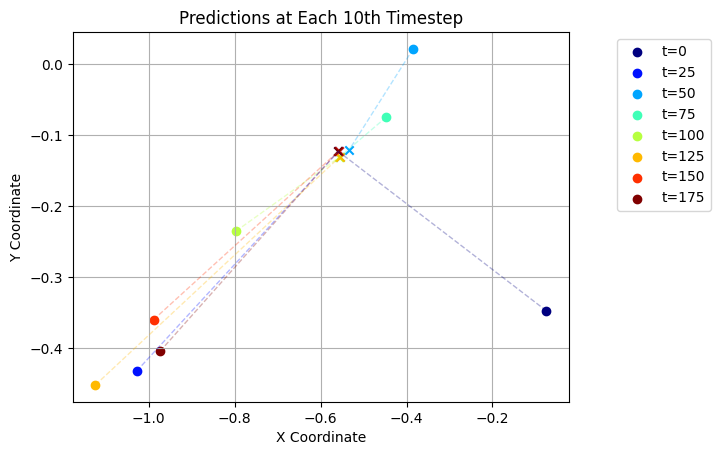

Epoch: [1][20/79]	Time 0.320	Loss 11573.2988	 
Epoch: [1][40/79]	Time 0.327	Loss 5314.0249	 
Epoch: [1][60/79]	Time 0.298	Loss 3262.1946	 
MSE: 0.01186
Pred MSE: 0.04610
Epoch: [2][20/79]	Time 0.316	Loss 2658.5193	 
Epoch: [2][40/79]	Time 0.308	Loss 2449.9172	 
Epoch: [2][60/79]	Time 0.325	Loss 2264.1101	 
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
5
MSE: 0.01019
Pred MSE: 0.04546
Epoch: [3][20/79]	Time 0.325	Loss 1920.5392	 
Epoch: [3][40/79]	Time 0.333	Loss 1347.5143	 
Epoch: [3][60/79]	Time 0.332	Loss 3789.1489	 
MSE: 0.00547
Pred MSE: 0.04718
Epoch: [4][20/79]	Time 0.332	Loss 287.0641	 
Epoch: [4][40/79]	Time 0.338	Loss 187.8440	 
Epoch: [4][60/79]	Time 0.334	Loss 187.2274	 
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
5
MSE: 0.00419


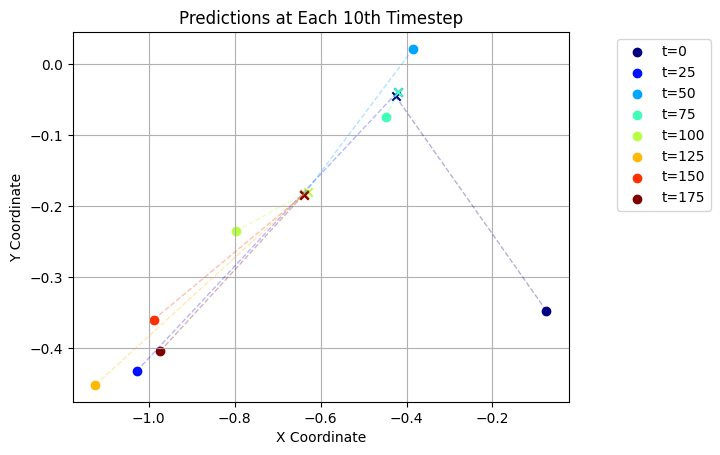

Epoch: [6][20/79]	Time 0.332	Loss 169.1510	 
Epoch: [6][40/79]	Time 0.339	Loss 25.4980	 
Epoch: [6][60/79]	Time 0.350	Loss -57.1268	 
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
5
MSE: 0.00381
Pred MSE: 0.04693
Epoch: [7][20/79]	Time 0.429	Loss 22.4416	 
Epoch: [7][40/79]	Time 0.343	Loss 125.1938	 
Epoch: [7][60/79]	Time 0.345	Loss 22.8681	 
MSE: 0.00335
Pred MSE: 0.04672
Epoch: [8][20/79]	Time 0.342	Loss 2.1461	 
Epoch: [8][40/79]	Time 0.322	Loss -34.1302	 
Epoch: [8][60/79]	Time 0.346	Loss 145.7497	 
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
5
MSE: 0.00333
Pred MSE: 0.04617
Epoch: [9][20/79]	Time 0.344	Loss 15.7196	 
Epoch: [9][40/79]	Time 0.342	Loss 5.4482	 
Epoch: [9][60/79]	Time 0.342	Loss -31.4771	 
MSE: 0.00344
Pred MSE: 0.04619


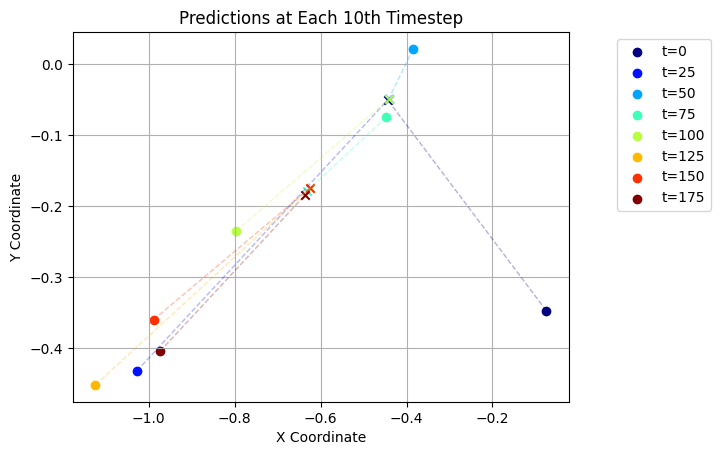

Epoch: [11][20/79]	Time 0.390	Loss -12.9320	 
Epoch: [11][40/79]	Time 0.392	Loss -31.2728	 
Epoch: [11][60/79]	Time 0.396	Loss -3.0802	 
MSE: 0.00294
Pred MSE: 0.04555
Epoch: [12][20/79]	Time 0.395	Loss 0.4019	 
Epoch: [12][40/79]	Time 0.392	Loss -12.1981	 
Epoch: [12][60/79]	Time 0.391	Loss -66.1358	 
tensor([[0.3457, 0.3273, 0.3271],
        [0.3213, 0.3395, 0.3393],
        [0.3214, 0.3397, 0.3389]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.3275, 0.3461, 0.3264], device='cuda:0', grad_fn=<SoftmaxBackward0>)
4.5
MSE: 0.00296
Pred MSE: 0.04533
Epoch: [13][20/79]	Time 0.460	Loss -90.7401	 
Epoch: [13][40/79]	Time 0.390	Loss 2.6499	 
Epoch: [13][60/79]	Time 0.391	Loss -61.5701	 
MSE: 0.00280
Pred MSE: 0.04553
Epoch: [14][20/79]	Time 0.392	Loss -33.9426	 
Epoch: [14][40/79]	Time 0.394	Loss -41.0033	 
Epoch: [14][60/79]	Time 0.389	Loss -14.4683	 
tensor([[0.3657, 0.3173, 0.3170],
        [0.3025, 0.3491, 0.3484],
        [0.3027, 0.3495, 0.3479]], device='cuda:0', grad_fn=<S

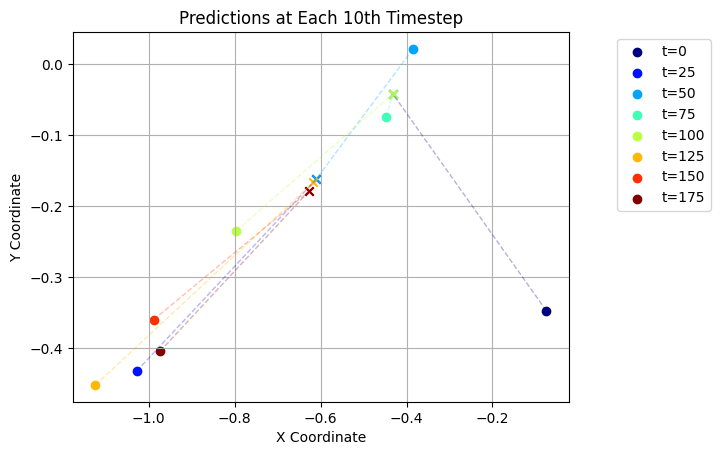

Epoch: [16][20/79]	Time 0.385	Loss -60.1402	 
Epoch: [16][40/79]	Time 0.394	Loss -50.1890	 
Epoch: [16][60/79]	Time 0.397	Loss -72.0350	 
tensor([[0.4026, 0.2989, 0.2985],
        [0.2715, 0.3652, 0.3633],
        [0.2720, 0.3660, 0.3620]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.2954, 0.4094, 0.2952], device='cuda:0', grad_fn=<SoftmaxBackward0>)
2.3914845000000002
MSE: 0.00264
Pred MSE: 0.04529
Epoch: [17][20/79]	Time 0.390	Loss -82.5289	 
Epoch: [17][40/79]	Time 0.393	Loss -83.8855	 
Epoch: [17][60/79]	Time 0.396	Loss -25.8138	 
MSE: 0.00262
Pred MSE: 0.04541
Epoch: [18][20/79]	Time 0.387	Loss -37.4237	 
Epoch: [18][40/79]	Time 0.390	Loss -84.8905	 
Epoch: [18][60/79]	Time 0.394	Loss -90.7684	 
tensor([[0.4842, 0.2582, 0.2576],
        [0.2158, 0.3954, 0.3888],
        [0.2180, 0.3984, 0.3836]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.2526, 0.4939, 0.2534], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1.5690529804500002
MSE: 0.00263
Pred MSE: 0.04554
Epo

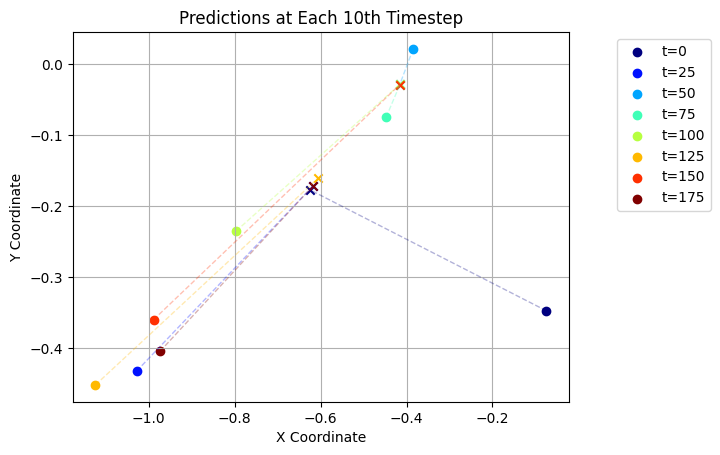

Epoch: [21][20/79]	Time 0.385	Loss -100.6132	 
Epoch: [21][40/79]	Time 0.394	Loss -139.8726	 
Epoch: [21][60/79]	Time 0.392	Loss -108.3432	 
MSE: 0.00260
Pred MSE: 0.04670
Epoch: [22][20/79]	Time 0.390	Loss -136.3206	 
Epoch: [22][40/79]	Time 0.387	Loss -70.8353	 
Epoch: [22][60/79]	Time 0.403	Loss -137.9811	 
tensor([[0.7021, 0.1495, 0.1484],
        [0.1211, 0.4775, 0.4014],
        [0.1350, 0.5073, 0.3578]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.1486, 0.7009, 0.1505], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00244
Pred MSE: 0.04677
Epoch: [23][20/79]	Time 0.399	Loss -103.5853	 
Epoch: [23][40/79]	Time 0.414	Loss -98.6232	 
Epoch: [23][60/79]	Time 0.393	Loss -49.5793	 
MSE: 0.00249
Pred MSE: 0.04682
Epoch: [24][20/79]	Time 0.393	Loss -121.1556	 
Epoch: [24][40/79]	Time 0.396	Loss -114.0959	 
Epoch: [24][60/79]	Time 0.392	Loss -134.4678	 
tensor([[0.7443, 0.1285, 0.1272],
        [0.1093, 0.5107, 0.3801],
        [0.1272, 0.5462, 0.3265]], device='cuda:0'

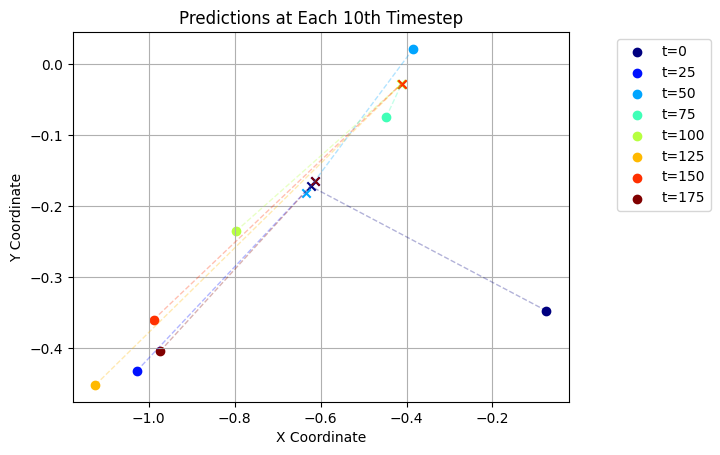

Epoch: [26][20/79]	Time 0.387	Loss -108.2589	 
Epoch: [26][40/79]	Time 0.391	Loss -91.0741	 
Epoch: [26][60/79]	Time 0.393	Loss -107.9229	 
tensor([[0.7758, 0.1127, 0.1114],
        [0.1001, 0.5415, 0.3584],
        [0.1214, 0.5769, 0.3017]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.1145, 0.7704, 0.1151], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00243
Pred MSE: 0.04775
Epoch: [27][20/79]	Time 0.389	Loss -104.1795	 
Epoch: [27][40/79]	Time 0.401	Loss -105.2436	 
Epoch: [27][60/79]	Time 0.392	Loss -131.5263	 
MSE: 0.00251
Pred MSE: 0.04820
Epoch: [28][20/79]	Time 0.394	Loss -127.7888	 
Epoch: [28][40/79]	Time 0.394	Loss -97.8961	 
Epoch: [28][60/79]	Time 0.402	Loss -132.2488	 
tensor([[0.8025, 0.0995, 0.0981],
        [0.0925, 0.5718, 0.3357],
        [0.1169, 0.6036, 0.2795]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.1017, 0.7966, 0.1017], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00238
Pred MSE: 0.04824
Epoch: [29][20/79]	Time 0.393	

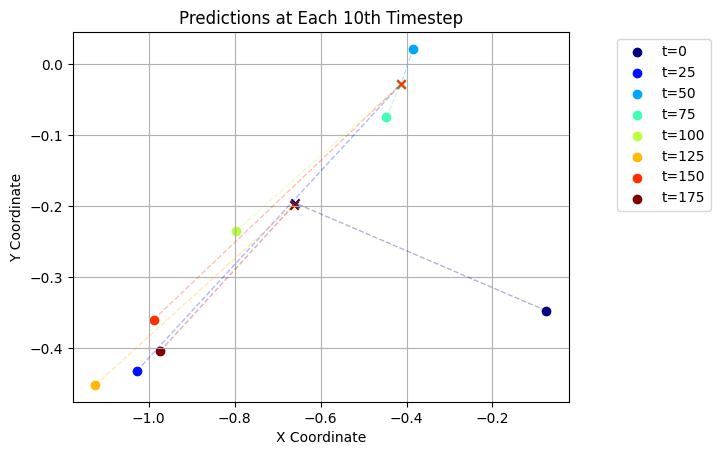

Epoch: [31][20/79]	Time 0.815	Loss -134.8480	 
Epoch: [31][40/79]	Time 0.475	Loss -109.9256	 
Epoch: [31][60/79]	Time 0.484	Loss -110.4028	 
MSE: 0.00241
Pred MSE: 0.05037
Epoch: [32][20/79]	Time 0.393	Loss -137.8343	 
Epoch: [32][40/79]	Time 0.391	Loss -138.6791	 
Epoch: [32][60/79]	Time 0.403	Loss -102.3815	 
tensor([[0.8421, 0.0798, 0.0781],
        [0.0827, 0.6246, 0.2928],
        [0.1129, 0.6428, 0.2443]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0824, 0.8362, 0.0815], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00243
Pred MSE: 0.05055
Epoch: [33][20/79]	Time 0.395	Loss -90.4088	 
Epoch: [33][40/79]	Time 0.394	Loss -118.8007	 
Epoch: [33][60/79]	Time 0.393	Loss -156.8836	 
MSE: 0.00249
Pred MSE: 0.05076
Epoch: [34][20/79]	Time 0.391	Loss -134.6878	 
Epoch: [34][40/79]	Time 0.393	Loss -87.9955	 
Epoch: [34][60/79]	Time 0.392	Loss -124.6729	 
tensor([[0.8568, 0.0726, 0.0707],
        [0.0795, 0.6429, 0.2777],
        [0.1128, 0.6556, 0.2316]], device='cuda:0

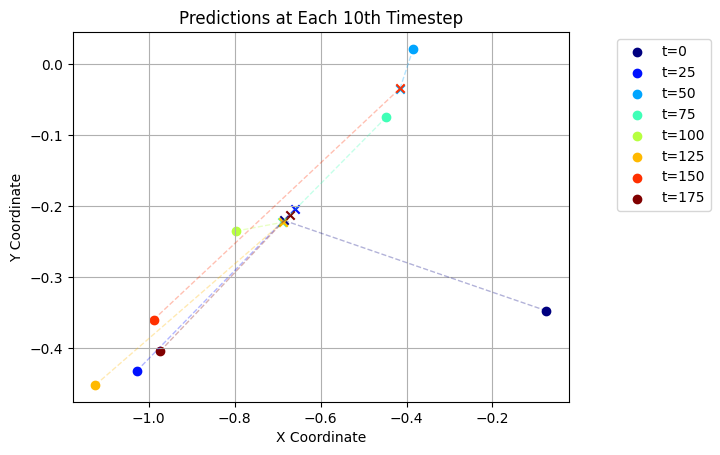

Epoch: [36][20/79]	Time 0.394	Loss -110.4528	 
Epoch: [36][40/79]	Time 0.392	Loss -138.3920	 
Epoch: [36][60/79]	Time 0.418	Loss -146.6330	 
tensor([[0.8693, 0.0664, 0.0642],
        [0.0774, 0.6580, 0.2647],
        [0.1141, 0.6656, 0.2203]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0688, 0.8641, 0.0672], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00247
Pred MSE: 0.05252
Epoch: [37][20/79]	Time 0.403	Loss -193.3033	 
Epoch: [37][40/79]	Time 0.393	Loss -103.8397	 
Epoch: [37][60/79]	Time 0.433	Loss -108.7756	 
MSE: 0.00236
Pred MSE: 0.05347
Epoch: [38][20/79]	Time 0.396	Loss -146.9695	 
Epoch: [38][40/79]	Time 0.383	Loss -165.9294	 
Epoch: [38][60/79]	Time 0.397	Loss -140.3324	 
tensor([[0.8802, 0.0611, 0.0587],
        [0.0760, 0.6711, 0.2529],
        [0.1159, 0.6741, 0.2100]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0632, 0.8756, 0.0613], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00240
Pred MSE: 0.05407
Epoch: [39][20/79]	Time 0.39

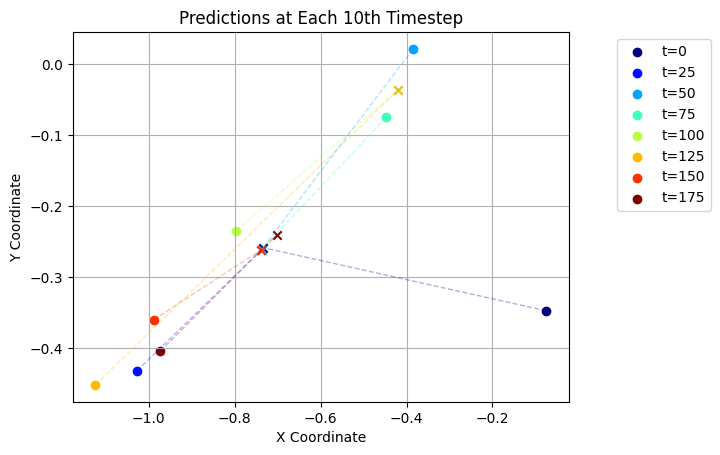

Epoch: [41][20/79]	Time 0.394	Loss -161.2568	 
Epoch: [41][40/79]	Time 0.398	Loss -176.8483	 
Epoch: [41][60/79]	Time 0.393	Loss -173.4751	 
MSE: 0.00238
Pred MSE: 0.05805
Epoch: [42][20/79]	Time 0.397	Loss -169.1116	 
Epoch: [42][40/79]	Time 0.393	Loss -163.4557	 
Epoch: [42][60/79]	Time 0.409	Loss -154.3065	 
tensor([[0.9006, 0.0512, 0.0482],
        [0.0757, 0.6845, 0.2398],
        [0.1227, 0.6853, 0.1920]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0525, 0.8973, 0.0502], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00239
Pred MSE: 0.05885
Epoch: [43][20/79]	Time 0.390	Loss -169.1995	 
Epoch: [43][40/79]	Time 0.394	Loss -154.2435	 
Epoch: [43][60/79]	Time 0.394	Loss -154.4975	 
MSE: 0.00240
Pred MSE: 0.05974
Epoch: [44][20/79]	Time 0.391	Loss -169.1496	 
Epoch: [44][40/79]	Time 0.391	Loss -145.6742	 
Epoch: [44][60/79]	Time 0.389	Loss -163.7621	 
tensor([[0.9060, 0.0486, 0.0454],
        [0.0766, 0.6808, 0.2427],
        [0.1250, 0.6861, 0.1889]], device='cuda

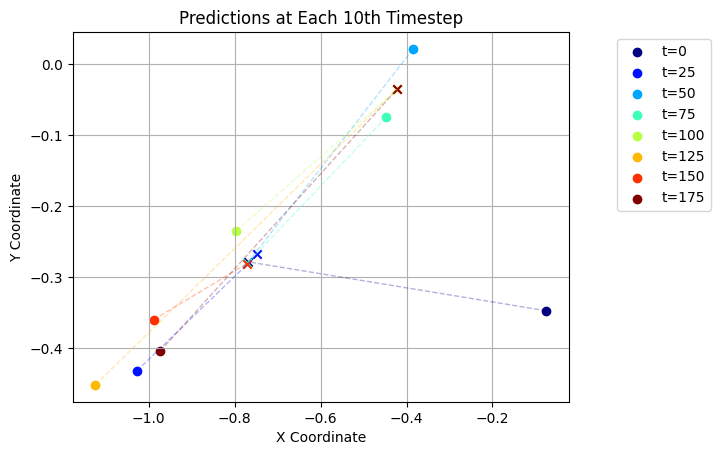

Epoch: [46][20/79]	Time 0.388	Loss -164.7090	 
Epoch: [46][40/79]	Time 0.393	Loss -173.7620	 
Epoch: [46][60/79]	Time 0.393	Loss -147.1436	 
tensor([[0.9103, 0.0465, 0.0432],
        [0.0774, 0.6722, 0.2504],
        [0.1261, 0.6868, 0.1872]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0473, 0.9079, 0.0449], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00237
Pred MSE: 0.06228
Epoch: [47][20/79]	Time 0.390	Loss -185.6384	 
Epoch: [47][40/79]	Time 0.389	Loss -161.6308	 
Epoch: [47][60/79]	Time 0.393	Loss -195.8327	 
MSE: 0.00237
Pred MSE: 0.06274
Epoch: [48][20/79]	Time 0.391	Loss -183.2520	 
Epoch: [48][40/79]	Time 0.441	Loss -163.7715	 
Epoch: [48][60/79]	Time 0.466	Loss -195.4965	 
tensor([[0.9155, 0.0440, 0.0405],
        [0.0783, 0.6534, 0.2683],
        [0.1250, 0.6887, 0.1863]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0444, 0.9137, 0.0419], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00238
Pred MSE: 0.06315
Epoch: [49][20/79]	Time 0.39

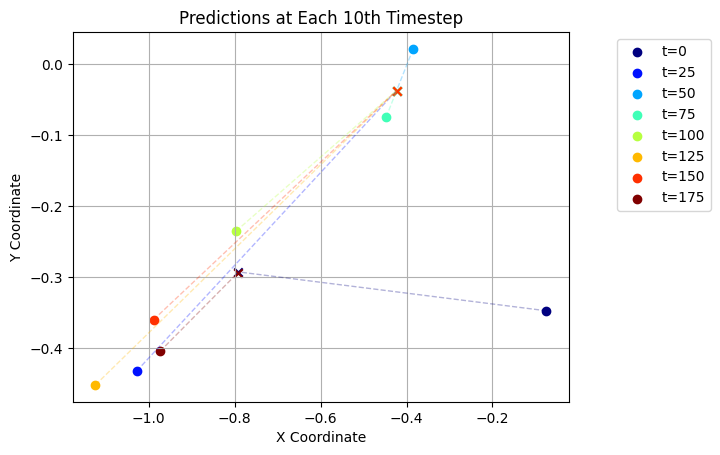

Epoch: [51][20/79]	Time 0.386	Loss -176.0562	 
Epoch: [51][40/79]	Time 0.415	Loss -181.5783	 
Epoch: [51][60/79]	Time 0.396	Loss -170.7701	 
MSE: 0.00236
Pred MSE: 0.06413
Epoch: [52][20/79]	Time 0.385	Loss -171.1049	 
Epoch: [52][40/79]	Time 0.384	Loss -158.9700	 
Epoch: [52][60/79]	Time 0.387	Loss -168.7097	 
tensor([[0.9217, 0.0412, 0.0370],
        [0.0801, 0.6131, 0.3068],
        [0.1202, 0.6922, 0.1876]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0407, 0.9212, 0.0381], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00235
Pred MSE: 0.06367
Epoch: [53][20/79]	Time 0.393	Loss -189.1117	 
Epoch: [53][40/79]	Time 0.397	Loss -181.7380	 
Epoch: [53][60/79]	Time 0.414	Loss -209.3245	 
MSE: 0.00242
Pred MSE: 0.06428
Epoch: [54][20/79]	Time 0.393	Loss -170.4462	 
Epoch: [54][40/79]	Time 0.391	Loss -178.2608	 
Epoch: [54][60/79]	Time 0.392	Loss -168.5224	 
tensor([[0.9254, 0.0397, 0.0349],
        [0.0819, 0.5787, 0.3394],
        [0.1141, 0.6935, 0.1924]], device='cuda

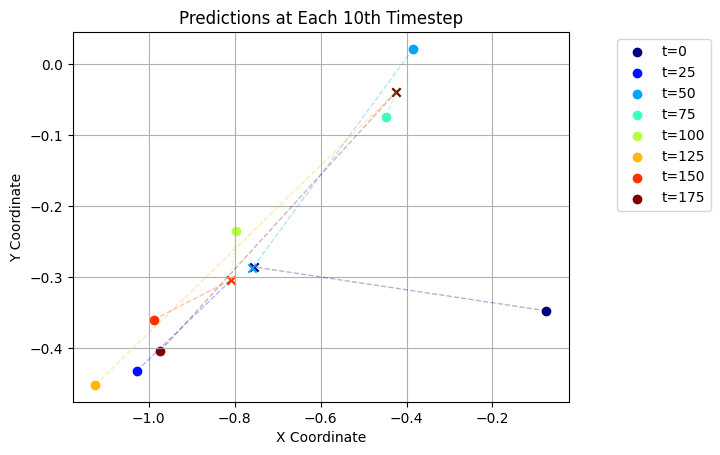

Epoch: [56][20/79]	Time 0.386	Loss -215.2881	 
Epoch: [56][40/79]	Time 0.392	Loss -158.1568	 
Epoch: [56][60/79]	Time 0.394	Loss -167.4207	 
tensor([[0.9275, 0.0390, 0.0335],
        [0.0834, 0.5549, 0.3617],
        [0.1086, 0.6985, 0.1930]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0368, 0.9288, 0.0344], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00235
Pred MSE: 0.06437
Epoch: [57][20/79]	Time 0.386	Loss -171.1121	 
Epoch: [57][40/79]	Time 0.392	Loss -208.4373	 
Epoch: [57][60/79]	Time 0.396	Loss -202.0366	 
MSE: 0.00235
Pred MSE: 0.06474
Epoch: [58][20/79]	Time 0.397	Loss -177.7338	 
Epoch: [58][40/79]	Time 0.391	Loss -160.9894	 
Epoch: [58][60/79]	Time 0.393	Loss -173.6767	 
tensor([[0.9294, 0.0384, 0.0322],
        [0.0851, 0.5275, 0.3874],
        [0.1021, 0.7092, 0.1888]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0354, 0.9315, 0.0331], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00231
Pred MSE: 0.06399
Epoch: [59][20/79]	Time 0.39

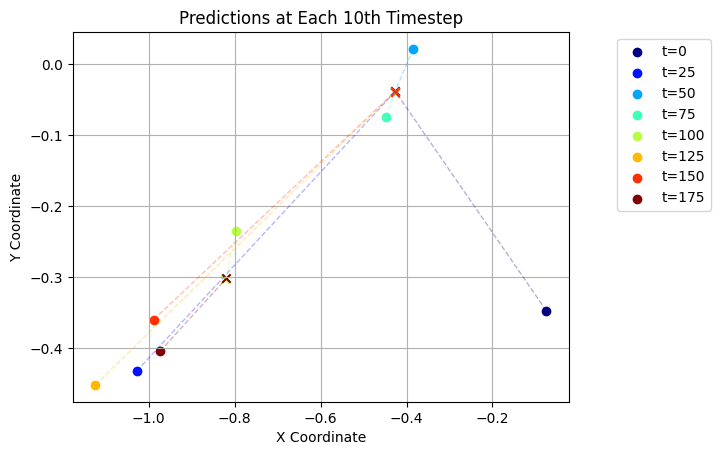

Epoch: [61][20/79]	Time 0.392	Loss -187.9863	 
Epoch: [61][40/79]	Time 0.390	Loss -159.9004	 
Epoch: [61][60/79]	Time 0.398	Loss -199.3187	 
MSE: 0.00224
Pred MSE: 0.06560
Epoch: [62][20/79]	Time 0.389	Loss -176.7111	 
Epoch: [62][40/79]	Time 0.395	Loss -206.0751	 
Epoch: [62][60/79]	Time 0.391	Loss -196.5924	 
tensor([[0.9349, 0.0373, 0.0277],
        [0.0956, 0.4477, 0.4567],
        [0.0805, 0.7752, 0.1443]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0309, 0.9401, 0.0290], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00223
Pred MSE: 0.06461
Epoch: [63][20/79]	Time 0.389	Loss -217.2830	 
Epoch: [63][40/79]	Time 0.385	Loss -224.1136	 
Epoch: [63][60/79]	Time 0.391	Loss -183.8643	 
MSE: 0.00220
Pred MSE: 0.06496
Epoch: [64][20/79]	Time 0.392	Loss -181.3924	 
Epoch: [64][40/79]	Time 0.392	Loss -218.2238	 
Epoch: [64][60/79]	Time 0.392	Loss -216.6589	 
tensor([[0.9366, 0.0369, 0.0265],
        [0.0984, 0.4283, 0.4734],
        [0.0757, 0.7908, 0.1334]], device='cuda

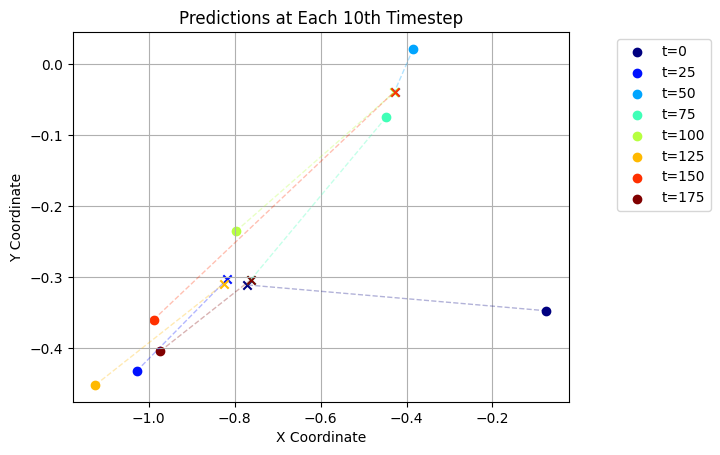

Epoch: [66][20/79]	Time 0.394	Loss -221.5202	 
Epoch: [66][40/79]	Time 0.393	Loss -192.2965	 
Epoch: [66][60/79]	Time 0.398	Loss -204.5856	 
tensor([[0.9383, 0.0364, 0.0253],
        [0.1009, 0.4101, 0.4890],
        [0.0714, 0.8045, 0.1241]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0282, 0.9454, 0.0265], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00223
Pred MSE: 0.06501
Epoch: [67][20/79]	Time 0.382	Loss -238.6494	 
Epoch: [67][40/79]	Time 0.392	Loss -165.4495	 
Epoch: [67][60/79]	Time 0.385	Loss -235.7971	 
MSE: 0.00221
Pred MSE: 0.06490
Epoch: [68][20/79]	Time 0.388	Loss -183.5753	 
Epoch: [68][40/79]	Time 0.387	Loss -216.9605	 
Epoch: [68][60/79]	Time 0.394	Loss -169.6912	 
tensor([[0.9402, 0.0357, 0.0241],
        [0.1035, 0.3899, 0.5066],
        [0.0672, 0.8183, 0.1146]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0265, 0.9485, 0.0250], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00231
Pred MSE: 0.06521
Epoch: [69][20/79]	Time 0.39

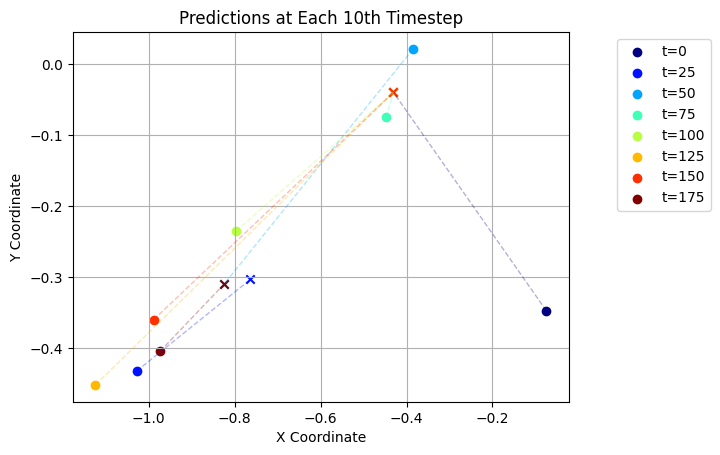

Epoch: [71][20/79]	Time 0.392	Loss -207.2867	 
Epoch: [71][40/79]	Time 0.400	Loss -187.0581	 
Epoch: [71][60/79]	Time 0.394	Loss -220.7333	 
MSE: 0.00232
Pred MSE: 0.06453
Epoch: [72][20/79]	Time 0.389	Loss -218.9231	 
Epoch: [72][40/79]	Time 0.390	Loss -191.9399	 
Epoch: [72][60/79]	Time 0.398	Loss -193.8309	 
tensor([[0.9416, 0.0352, 0.0232],
        [0.1053, 0.3733, 0.5214],
        [0.0642, 0.8283, 0.1075]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0252, 0.9510, 0.0239], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00232
Pred MSE: 0.06335
Epoch: [73][20/79]	Time 0.386	Loss -221.9879	 
Epoch: [73][40/79]	Time 0.392	Loss -192.6704	 
Epoch: [73][60/79]	Time 0.395	Loss -229.5896	 
MSE: 0.00222
Pred MSE: 0.06378
Epoch: [74][20/79]	Time 0.388	Loss -235.9615	 
Epoch: [74][40/79]	Time 0.405	Loss -241.1838	 
Epoch: [74][60/79]	Time 0.390	Loss -219.7448	 
tensor([[0.9423, 0.0350, 0.0228],
        [0.1062, 0.3646, 0.5291],
        [0.0629, 0.8332, 0.1039]], device='cuda

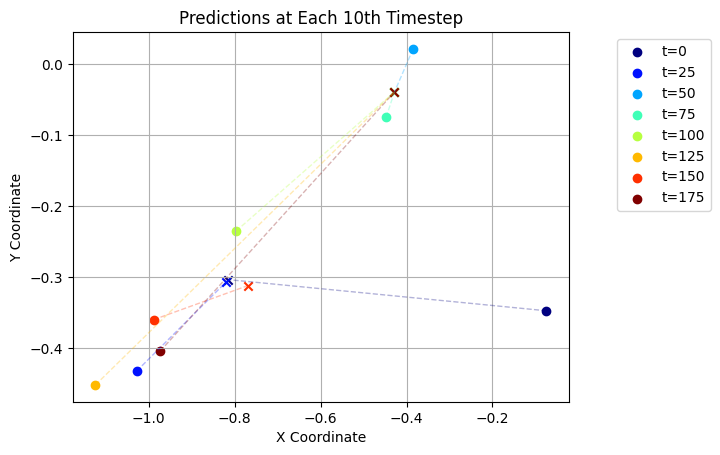

Epoch: [76][20/79]	Time 0.395	Loss -198.9578	 
Epoch: [76][40/79]	Time 0.403	Loss -202.0393	 
Epoch: [76][60/79]	Time 0.400	Loss -174.8436	 
tensor([[0.9429, 0.0348, 0.0223],
        [0.1069, 0.3549, 0.5383],
        [0.0616, 0.8382, 0.1001]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0237, 0.9537, 0.0226], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00218
Pred MSE: 0.06390
Epoch: [77][20/79]	Time 0.394	Loss -205.3890	 
Epoch: [77][40/79]	Time 0.875	Loss -218.9621	 
Epoch: [77][60/79]	Time 0.396	Loss -227.0108	 
MSE: 0.00225
Pred MSE: 0.06463
Epoch: [78][20/79]	Time 0.397	Loss -246.6257	 
Epoch: [78][40/79]	Time 0.392	Loss -212.9695	 
Epoch: [78][60/79]	Time 0.393	Loss -224.8151	 
tensor([[0.9438, 0.0345, 0.0217],
        [0.1077, 0.3406, 0.5517],
        [0.0600, 0.8452, 0.0948]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0226, 0.9558, 0.0216], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00217
Pred MSE: 0.06469
Epoch: [79][20/79]	Time 0.38

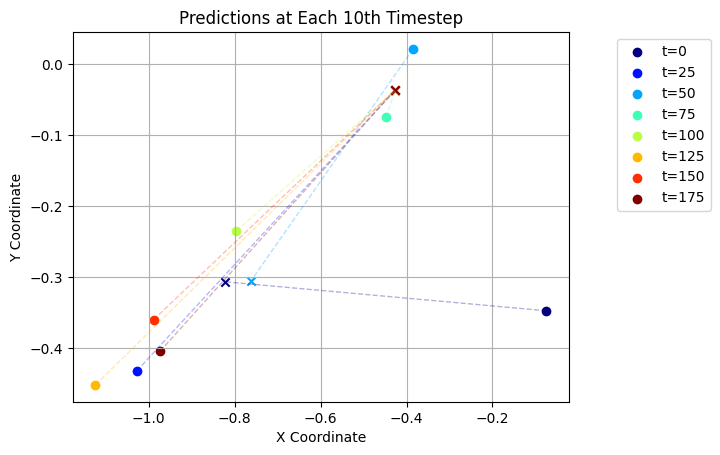

Epoch: [81][20/79]	Time 0.389	Loss -239.7592	 
Epoch: [81][40/79]	Time 0.392	Loss -249.4616	 
Epoch: [81][60/79]	Time 0.392	Loss -256.0286	 
MSE: 0.00219
Pred MSE: 0.06566
Epoch: [82][20/79]	Time 0.393	Loss -266.4728	 
Epoch: [82][40/79]	Time 0.400	Loss -240.0843	 
Epoch: [82][60/79]	Time 0.391	Loss -239.6175	 
tensor([[0.9451, 0.0346, 0.0203],
        [0.1077, 0.3109, 0.5815],
        [0.0585, 0.8568, 0.0846]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0203, 0.9602, 0.0195], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00225
Pred MSE: 0.06472
Epoch: [83][20/79]	Time 0.387	Loss -225.2953	 
Epoch: [83][40/79]	Time 0.392	Loss -258.0185	 
Epoch: [83][60/79]	Time 0.392	Loss -227.2503	 
MSE: 0.00217
Pred MSE: 0.06477
Epoch: [84][20/79]	Time 0.384	Loss -243.7213	 
Epoch: [84][40/79]	Time 0.395	Loss -235.8078	 
Epoch: [84][60/79]	Time 0.391	Loss -231.2220	 
tensor([[0.9453, 0.0350, 0.0197],
        [0.1069, 0.2999, 0.5932],
        [0.0591, 0.8598, 0.0811]], device='cuda

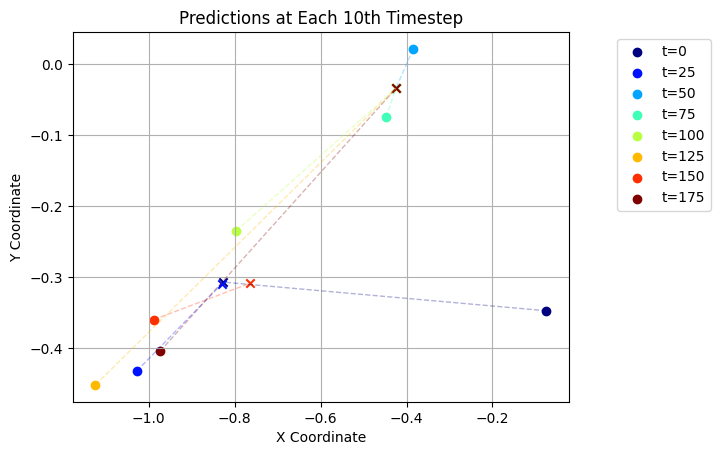

Epoch: [86][20/79]	Time 0.389	Loss -271.6343	 
Epoch: [86][40/79]	Time 0.397	Loss -282.3350	 
Epoch: [86][60/79]	Time 0.396	Loss -249.1489	 
tensor([[0.9452, 0.0357, 0.0191],
        [0.1050, 0.2895, 0.6054],
        [0.0604, 0.8618, 0.0778]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0185, 0.9637, 0.0178], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00211
Pred MSE: 0.06553
Epoch: [87][20/79]	Time 0.387	Loss -274.5887	 
Epoch: [87][40/79]	Time 0.389	Loss -280.0431	 
Epoch: [87][60/79]	Time 0.400	Loss -278.2413	 
MSE: 0.00206
Pred MSE: 0.06592
Epoch: [88][20/79]	Time 0.391	Loss -274.0881	 
Epoch: [88][40/79]	Time 0.391	Loss -268.7219	 
Epoch: [88][60/79]	Time 0.419	Loss -308.0315	 
tensor([[0.9449, 0.0363, 0.0188],
        [0.1035, 0.2850, 0.6116],
        [0.0614, 0.8623, 0.0762]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0180, 0.9645, 0.0174], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00195
Pred MSE: 0.06541
Epoch: [89][20/79]	Time 0.39

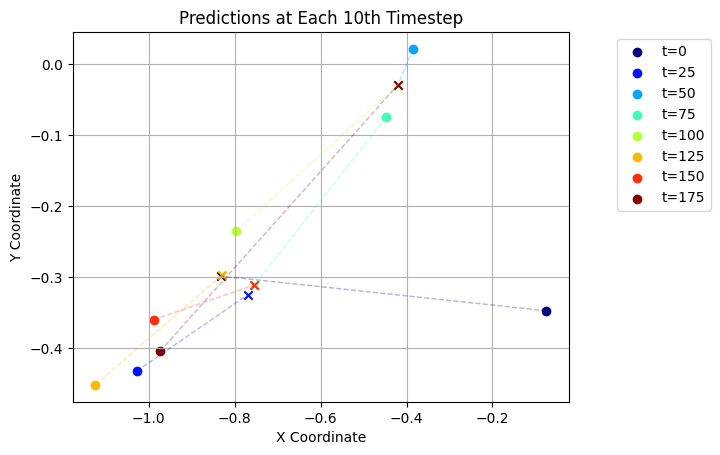

Epoch: [91][20/79]	Time 0.469	Loss -352.6799	 
Epoch: [91][40/79]	Time 0.435	Loss -360.4697	 
Epoch: [91][60/79]	Time 0.488	Loss -364.7763	 
MSE: 0.00161
Pred MSE: 0.06583
Epoch: [92][20/79]	Time 0.435	Loss -377.2577	 
Epoch: [92][40/79]	Time 0.471	Loss -367.9704	 
Epoch: [92][60/79]	Time 0.797	Loss -373.9913	 
tensor([[0.9442, 0.0379, 0.0179],
        [0.1006, 0.2761, 0.6233],
        [0.0628, 0.8646, 0.0726]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0171, 0.9664, 0.0165], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00160
Pred MSE: 0.06575
Epoch: [93][20/79]	Time 0.416	Loss -389.3998	 
Epoch: [93][40/79]	Time 0.393	Loss -375.8743	 
Epoch: [93][60/79]	Time 0.451	Loss -384.6237	 
MSE: 0.00164
Pred MSE: 0.06573
Epoch: [94][20/79]	Time 0.490	Loss -388.1462	 
Epoch: [94][40/79]	Time 0.452	Loss -388.5770	 
Epoch: [94][60/79]	Time 0.801	Loss -394.4742	 
tensor([[0.9440, 0.0385, 0.0175],
        [0.0999, 0.2710, 0.6291],
        [0.0629, 0.8662, 0.0709]], device='cuda

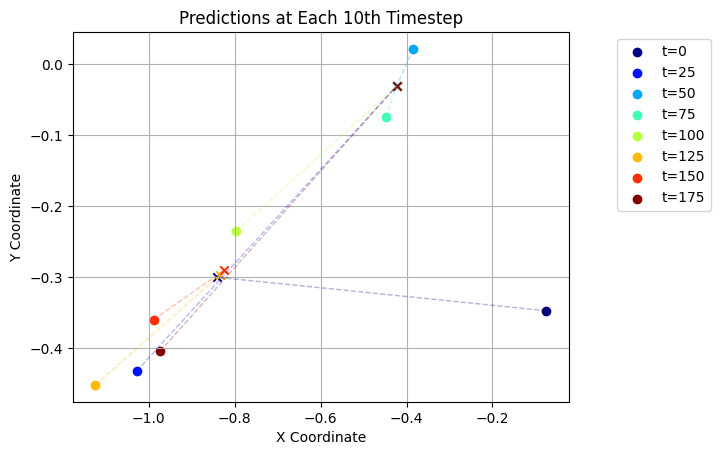

Epoch: [96][20/79]	Time 0.514	Loss -395.7055	 
Epoch: [96][40/79]	Time 0.392	Loss -403.9741	 
Epoch: [96][60/79]	Time 1.222	Loss -389.0629	 
tensor([[0.9440, 0.0389, 0.0170],
        [0.0995, 0.2651, 0.6354],
        [0.0627, 0.8682, 0.0691]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0161, 0.9684, 0.0156], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00180
Pred MSE: 0.06551
Epoch: [97][20/79]	Time 0.399	Loss -398.0760	 
Epoch: [97][40/79]	Time 0.705	Loss -391.7798	 
Epoch: [97][60/79]	Time 0.528	Loss -399.3673	 
MSE: 0.00189
Pred MSE: 0.06466
Epoch: [98][20/79]	Time 0.470	Loss -395.1510	 
Epoch: [98][40/79]	Time 1.090	Loss -399.1585	 
Epoch: [98][60/79]	Time 0.400	Loss -404.9026	 
tensor([[0.9441, 0.0393, 0.0166],
        [0.0991, 0.2588, 0.6421],
        [0.0624, 0.8704, 0.0672]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.0155, 0.9694, 0.0151], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00218
Pred MSE: 0.06583
Epoch: [99][20/79]	Time 0.48

In [12]:
iwae_losses, test_mse_iwae, pred_mse_iwae = train_iwae(N, model, optimizer,num_states, dim_latent, T)

In [45]:
PATH = 'snlds_coord_iwae.pth'
# torch.save(model.state_dict(), PATH)
model.transitions = torch.nn.ModuleList([MLP(dim_latent, dim_latent, 16, 'cos') for _ in range(num_states)]).to(device).float()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [15]:
test_mse_iwae, pred_mse_iwae

([0.04049261473119259,
  0.011860368587076665,
  0.010189499706029892,
  0.005471405899152159,
  0.004192108986899257,
  0.003821064415387809,
  0.0038057326572015883,
  0.0033474801806733013,
  0.0033309797290712595,
  0.0034399458905681967,
  0.0030800263630226254,
  0.0029439428355544804,
  0.002964956406503916,
  0.0027998968260362746,
  0.0027834480861201882,
  0.002890370786190033,
  0.0026403935393318535,
  0.0026195819955319166,
  0.002629614993929863,
  0.002515630959533155,
  0.002572669554501772,
  0.0026014705654233694,
  0.0024433562764897944,
  0.0024864130187779664,
  0.002486469247378409,
  0.002412580279633403,
  0.0024318772600963713,
  0.002507892670109868,
  0.002383561455644667,
  0.0024128696182742714,
  0.002481936360709369,
  0.002414844185113907,
  0.002428795676678419,
  0.0024896214017644525,
  0.002419653767719865,
  0.0023899469757452606,
  0.0024678432615473866,
  0.002357087889686227,
  0.0023993529845029115,
  0.0024459956912323833,
  0.00240140547975897

Text(0, 0.5, 'Training Loss')

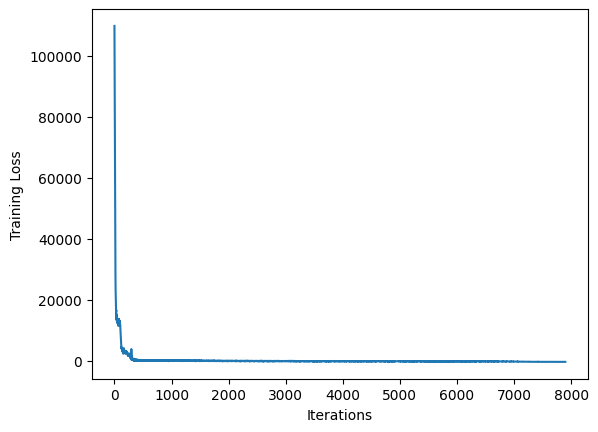

In [16]:
plt.plot(iwae_losses)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')

Text(0, 0.5, 'Training Loss')

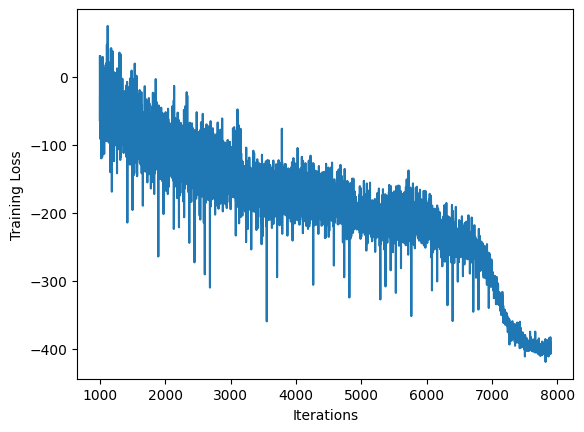

In [17]:
plt.plot(np.arange(1000,len(iwae_losses)),iwae_losses[1000:])
plt.xlabel('Iterations')
plt.ylabel('Training Loss')

Text(0, 0.5, 'MSE')

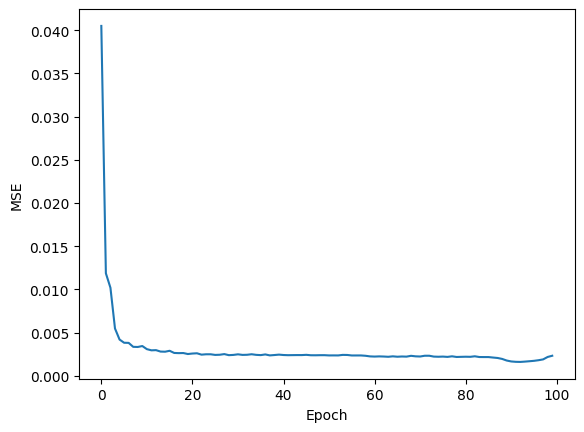

In [18]:
plt.plot(test_mse_iwae)
plt.xlabel('Epoch')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

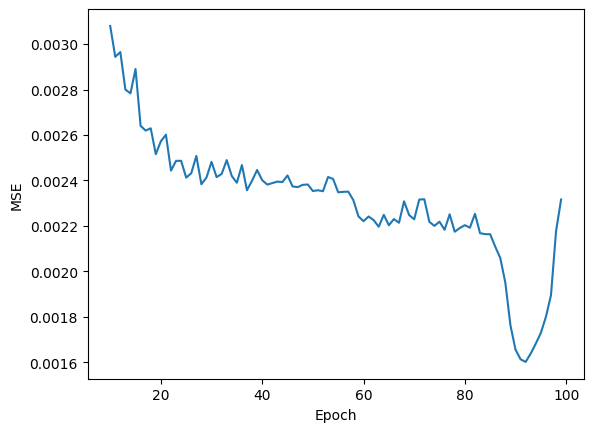

In [21]:
plt.plot(np.arange(10,len(test_mse_iwae)),test_mse_iwae[10:])
plt.xlabel('Epoch')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

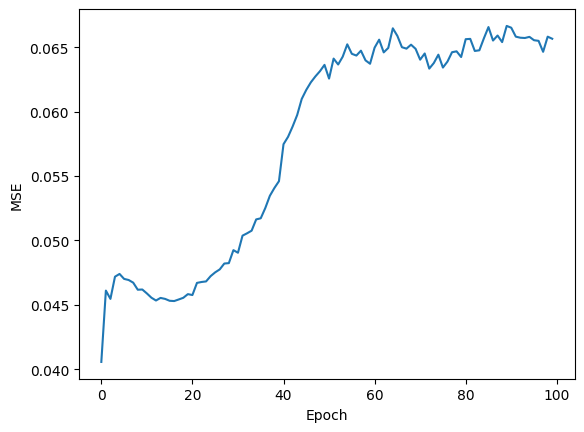

In [22]:
plt.plot(pred_mse_iwae)
plt.xlabel('Epoch')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

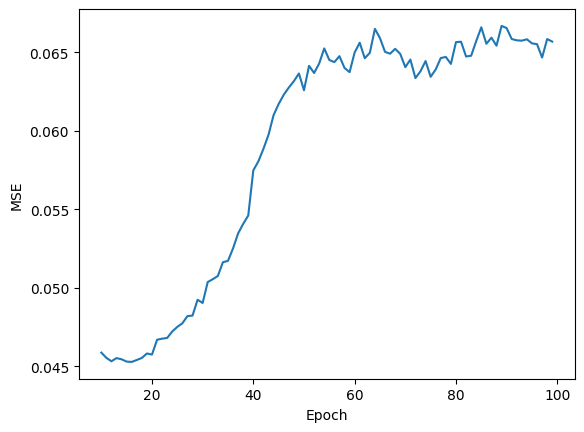

In [23]:
plt.plot(np.arange(10,len(pred_mse_iwae)),pred_mse_iwae[10:])
plt.xlabel('Epoch')
plt.ylabel('MSE')

In [24]:
# Training time: 35min
print(f"Last IWAE Loss: {iwae_losses[-1]:.1f}")
print(f"Last Test MSE: {test_mse_iwae[-1]:.6f}")
print(f"Last Pred MSE: {pred_mse_iwae[-1]:.6f}")

Last IWAE Loss: -392.1
Last Test MSE: 0.002316
Last Pred MSE: 0.065671


In [25]:
print(f"Best IWAE Loss: {min(iwae_losses):.1f}")
print(f"Best Test MSE: {min(test_mse_iwae):.6f}")
print(f"Best Pred MSE: {min(pred_mse_iwae):.6f}")

Best IWAE Loss: -419.4
Best Test MSE: 0.001602
Best Pred MSE: 0.040561


In [26]:
# Reconstructions

t = 200
model.eval()

with torch.inference_mode():
    (x,) = next(iter(test_dataloader))
    x = x.to(device).float()
    recon_x,_,_,_ = model(x)
    x = x.cpu().numpy()
    recon_x = recon_x.cpu().numpy()

# Final MSE per timestep
mse_T = np.mean(((x - recon_x) ** 2),axis=(0,2))
for i,element in enumerate(mse_T):
    print(f"t={i} MSE per pixel:{element:.6f}")

t=0 MSE per pixel:0.123569
t=1 MSE per pixel:0.058073
t=2 MSE per pixel:0.054592
t=3 MSE per pixel:0.028323
t=4 MSE per pixel:0.036561
t=5 MSE per pixel:0.022561
t=6 MSE per pixel:0.021281
t=7 MSE per pixel:0.016147
t=8 MSE per pixel:0.014740
t=9 MSE per pixel:0.009901
t=10 MSE per pixel:0.007865
t=11 MSE per pixel:0.006185
t=12 MSE per pixel:0.002915
t=13 MSE per pixel:0.001449
t=14 MSE per pixel:0.001135
t=15 MSE per pixel:0.000607
t=16 MSE per pixel:0.000481
t=17 MSE per pixel:0.000430
t=18 MSE per pixel:0.000580
t=19 MSE per pixel:0.000697
t=20 MSE per pixel:0.000605
t=21 MSE per pixel:0.000639
t=22 MSE per pixel:0.000639
t=23 MSE per pixel:0.000632
t=24 MSE per pixel:0.000650
t=25 MSE per pixel:0.000548
t=26 MSE per pixel:0.000691
t=27 MSE per pixel:0.000690
t=28 MSE per pixel:0.000511
t=29 MSE per pixel:0.000464
t=30 MSE per pixel:0.000757
t=31 MSE per pixel:0.000450
t=32 MSE per pixel:0.000595
t=33 MSE per pixel:0.000512
t=34 MSE per pixel:0.000513
t=35 MSE per pixel:0.000702
t=

In [27]:
mse_T

array([0.12356897, 0.05807269, 0.05459151, 0.02832304, 0.03656136,
       0.02256144, 0.02128135, 0.01614658, 0.01474001, 0.00990147,
       0.00786465, 0.00618479, 0.00291452, 0.00144911, 0.0011346 ,
       0.00060705, 0.00048117, 0.00042964, 0.00057974, 0.00069748,
       0.00060517, 0.00063876, 0.00063905, 0.00063244, 0.00064956,
       0.00054755, 0.00069096, 0.00069007, 0.00051084, 0.00046408,
       0.00075661, 0.00044999, 0.00059521, 0.00051164, 0.00051267,
       0.00070174, 0.00059845, 0.00052042, 0.00071174, 0.00044054,
       0.00066531, 0.00076404, 0.0005516 , 0.0005516 , 0.00057985,
       0.00054867, 0.00053225, 0.0006084 , 0.00046119, 0.00048599,
       0.00057487, 0.00045202, 0.00059826, 0.00073061, 0.000502  ,
       0.00051011, 0.00050242, 0.00049006, 0.00042112, 0.0006134 ,
       0.00070222, 0.00053159, 0.0006205 , 0.00061634, 0.00054065,
       0.00053312, 0.00042121, 0.00045781, 0.00046047, 0.00060975,
       0.0005998 , 0.00056172, 0.00050822, 0.00041938, 0.00051

Text(0, 0.5, 'MSE per Pixel')

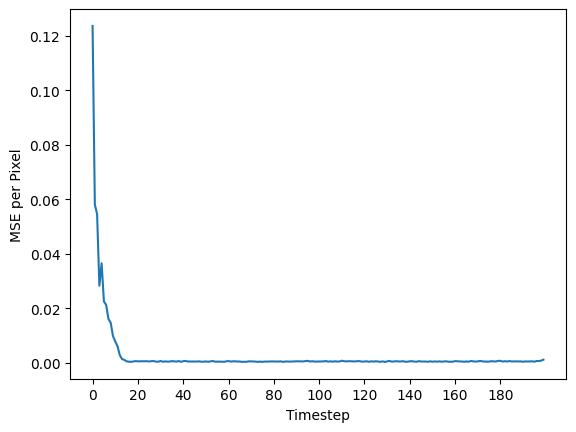

In [28]:
plt.plot(mse_T)
plt.xlabel('Timestep')
plt.xticks(np.arange(0,t,20))
plt.ylabel('MSE per Pixel')

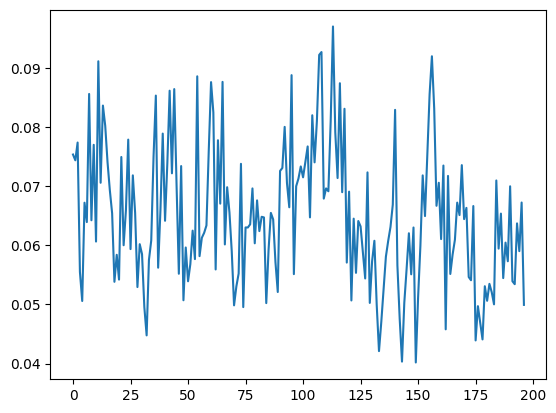

In [29]:
# Take first 3 timesteps. Generate the rest of the sequence. Calculate MSE

with torch.inference_mode():
    predict_mse = []
    for (sample,) in test_dataloader:
        mse_values = []
        obs_var = sample.float().to(device)
        preds = model.predict_sequence(obs_var[:,:3], seq_len=197)
        obs_var, preds = obs_var.cpu().numpy(), preds.cpu().numpy()
        mse = np.mean(((preds - obs_var[:,3:]) ** 2),axis=(0,2))
        mse_values.append(mse)
    mse_val = sum(mse_values) / len(mse_values)
    predict_mse.append(mse_val.tolist())

plt.plot(predict_mse[0])

In [30]:
predict_mse[0]

[0.07535587251186371,
 0.07437847554683685,
 0.07738348096609116,
 0.05548413097858429,
 0.050577472895383835,
 0.06720533221960068,
 0.06392692774534225,
 0.08560357987880707,
 0.06423476338386536,
 0.07699816673994064,
 0.06063257157802582,
 0.09113093465566635,
 0.07057803869247437,
 0.08363810181617737,
 0.08021534234285355,
 0.07406824827194214,
 0.069337397813797,
 0.06541708111763,
 0.05382262170314789,
 0.0583920031785965,
 0.05419725552201271,
 0.07493871450424194,
 0.06000794097781181,
 0.0659516230225563,
 0.07787838578224182,
 0.05935646966099739,
 0.07183167338371277,
 0.06547385454177856,
 0.05293542519211769,
 0.0601867139339447,
 0.05850094184279442,
 0.04955719783902168,
 0.04475967586040497,
 0.05750945955514908,
 0.060817718505859375,
 0.07494737952947617,
 0.08532679826021194,
 0.0562102347612381,
 0.06592726707458496,
 0.07889746874570847,
 0.06414776295423508,
 0.07390531897544861,
 0.0861545279622078,
 0.07217782735824585,
 0.08642680943012238,
 0.070327796041965

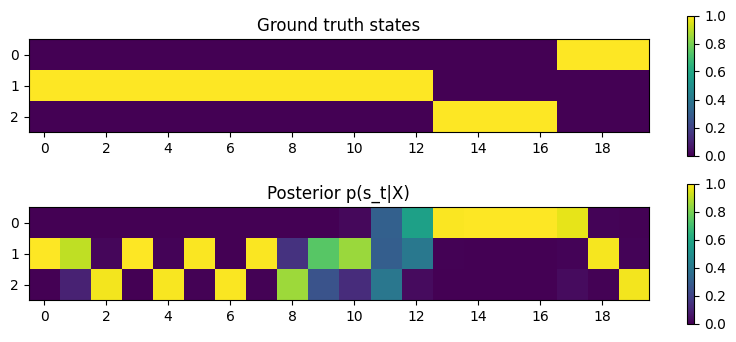

In [46]:
# First 20 timesteps. Probability of discrete states

latent_path = "../../../vol/bitbucket/am9923/datasets/latent_variables/states_test_N_500_T_200_dim_latent_2_dim_obs_2_state_3_sparsity_0.0_net_cosine_seed_24.npy"
latents_dataset = TensorDataset(torch.from_numpy(np.load(latent_path)))
latent_loader = DataLoader(latents_dataset, batch_size=50, shuffle=False)
latent_states = next(iter(latent_loader))[0]



with torch.inference_mode():
    obs = next(iter(test_dataloader))[0]
    gamma = model.gamma(obs[:,:].float().to(device))

plot_discrete_states(gamma,latent_states)

# FIVO

In [47]:
epoch_num = 100
T = 200
N = 10
learning_rate = 5e-4
dim_obs = 2
dim_latent = 2 
num_states = 3
model = VariationalSNLDS(dim_obs, dim_latent, 64, num_states, encoder_type='video' if images else 'recurent', device=device, annealing=False, inference='alpha', beta=0)
model = model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Epoch: [0][20/79]	Time 3.466	Loss 2243.9795	 
Epoch: [0][40/79]	Time 3.473	Loss 1348.0525	 
Epoch: [0][60/79]	Time 3.454	Loss 755.6207	 
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
5
MSE: 0.03653
Pred MSE: 0.07364


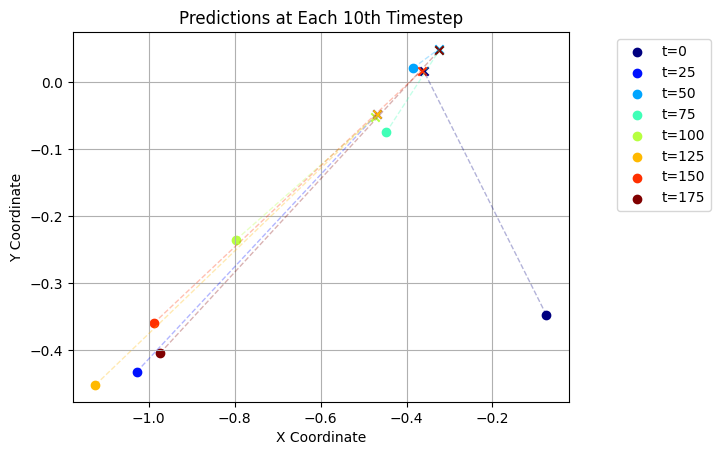

Epoch: [1][20/79]	Time 3.448	Loss 155.9020	 
Epoch: [1][40/79]	Time 3.460	Loss 45.4256	 
Epoch: [1][60/79]	Time 3.481	Loss -4.9181	 
MSE: 0.01751
Pred MSE: 0.05837
Epoch: [2][20/79]	Time 3.488	Loss -77.0048	 
Epoch: [2][40/79]	Time 3.449	Loss -89.3575	 
Epoch: [2][60/79]	Time 3.453	Loss -114.2655	 
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
5
MSE: 0.01872
Pred MSE: 0.04998
Epoch: [3][20/79]	Time 3.463	Loss -38.1015	 
Epoch: [3][40/79]	Time 3.481	Loss -172.5239	 
Epoch: [3][60/79]	Time 3.466	Loss -148.4910	 
MSE: 0.01785
Pred MSE: 0.04869
Epoch: [4][20/79]	Time 3.469	Loss -166.5364	 
Epoch: [4][40/79]	Time 3.470	Loss -160.6506	 
Epoch: [4][60/79]	Time 3.627	Loss -193.3970	 
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
5
MSE: 0.01752
Pred M

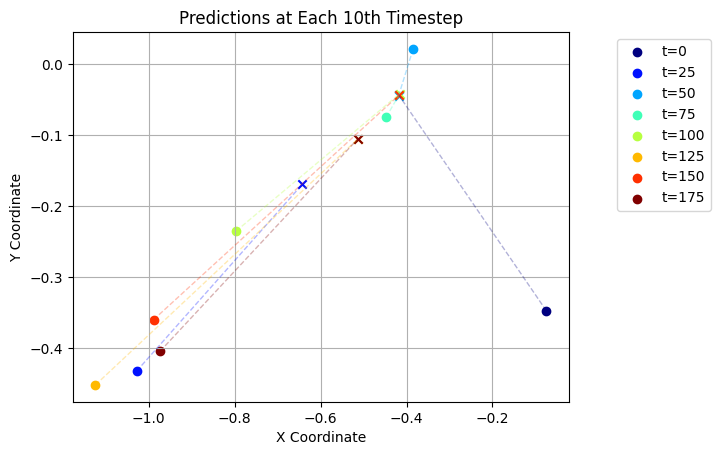

Epoch: [6][20/79]	Time 3.455	Loss -118.6751	 
Epoch: [6][40/79]	Time 3.517	Loss -159.8994	 
Epoch: [6][60/79]	Time 3.509	Loss -72.4481	 
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
5
MSE: 0.01613
Pred MSE: 0.04789
Epoch: [7][20/79]	Time 3.536	Loss -192.7701	 
Epoch: [7][40/79]	Time 3.499	Loss -170.4460	 
Epoch: [7][60/79]	Time 3.488	Loss -210.2361	 
MSE: 0.01572
Pred MSE: 0.04797
Epoch: [8][20/79]	Time 3.618	Loss -183.7524	 
Epoch: [8][40/79]	Time 3.482	Loss -179.5466	 
Epoch: [8][60/79]	Time 3.458	Loss -189.7094	 
tensor([[0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333],
        [0.3333, 0.3333, 0.3333]], device='cuda:0')
tensor([0.3333, 0.3333, 0.3333], device='cuda:0')
5
MSE: 0.01306
Pred MSE: 0.04796
Epoch: [9][20/79]	Time 3.481	Loss -222.3331	 
Epoch: [9][40/79]	Time 3.712	Loss -218.7326	 
Epoch: [9][60/79]	Time 3.472	Loss -229.1553	 
MSE: 0.01279

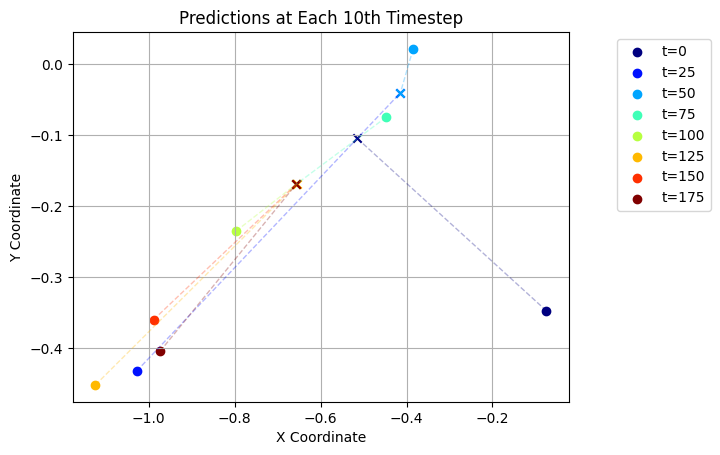

Epoch: [11][20/79]	Time 3.749	Loss -271.2085	 
Epoch: [11][40/79]	Time 3.591	Loss -270.9133	 
Epoch: [11][60/79]	Time 3.506	Loss -282.1400	 
MSE: 0.00692
Pred MSE: 0.04779
Epoch: [12][20/79]	Time 3.568	Loss -272.4777	 
Epoch: [12][40/79]	Time 3.566	Loss -290.6706	 
Epoch: [12][60/79]	Time 3.654	Loss -287.2112	 
tensor([[0.3390, 0.3232, 0.3377],
        [0.3324, 0.3381, 0.3295],
        [0.3384, 0.3245, 0.3371]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.3404, 0.3243, 0.3352], device='cuda:0', grad_fn=<SoftmaxBackward0>)
4.5
MSE: 0.00549
Pred MSE: 0.04837
Epoch: [13][20/79]	Time 3.614	Loss -292.4887	 
Epoch: [13][40/79]	Time 3.585	Loss -286.6367	 
Epoch: [13][60/79]	Time 3.560	Loss -291.7281	 
MSE: 0.00439
Pred MSE: 0.04832
Epoch: [14][20/79]	Time 3.528	Loss -290.8987	 
Epoch: [14][40/79]	Time 3.597	Loss -297.1960	 
Epoch: [14][60/79]	Time 3.558	Loss -300.5781	 
tensor([[0.3481, 0.3085, 0.3434],
        [0.3298, 0.3391, 0.3310],
        [0.3449, 0.3126, 0.3425]], device='cu

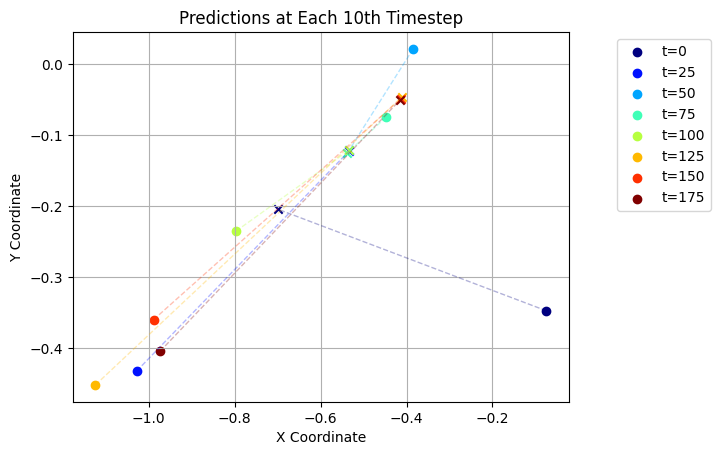

Epoch: [16][20/79]	Time 3.549	Loss -297.5116	 
Epoch: [16][40/79]	Time 3.594	Loss -304.1038	 
Epoch: [16][60/79]	Time 3.549	Loss -298.1049	 
tensor([[0.3648, 0.2832, 0.3520],
        [0.3234, 0.3358, 0.3408],
        [0.3551, 0.2936, 0.3513]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.3810, 0.2965, 0.3225], device='cuda:0', grad_fn=<SoftmaxBackward0>)
2.3914845000000002
MSE: 0.00326
Pred MSE: 0.04848
Epoch: [17][20/79]	Time 3.695	Loss -303.7049	 
Epoch: [17][40/79]	Time 3.616	Loss -299.3519	 
Epoch: [17][60/79]	Time 3.582	Loss -305.6377	 
MSE: 0.00313
Pred MSE: 0.04869
Epoch: [18][20/79]	Time 3.598	Loss -310.5591	 
Epoch: [18][40/79]	Time 3.566	Loss -289.5557	 
Epoch: [18][60/79]	Time 3.578	Loss -301.6160	 
tensor([[0.4020, 0.2336, 0.3644],
        [0.3082, 0.3227, 0.3691],
        [0.3756, 0.2582, 0.3662]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.4350, 0.2632, 0.3017], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1.5690529804500002
MSE: 0.00320
Pred MSE: 0.

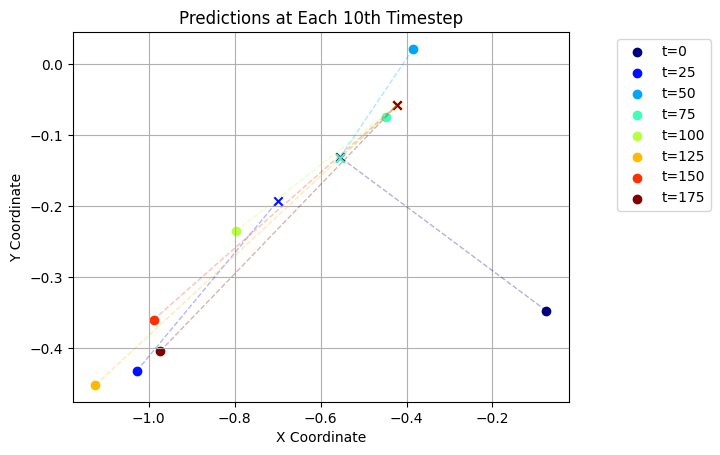

Epoch: [21][20/79]	Time 3.522	Loss -307.2075	 
Epoch: [21][40/79]	Time 3.564	Loss -302.8992	 
Epoch: [21][60/79]	Time 3.575	Loss -308.6021	 
MSE: 0.00288
Pred MSE: 0.04827
Epoch: [22][20/79]	Time 3.557	Loss -310.5794	 
Epoch: [22][40/79]	Time 3.693	Loss -310.1867	 
Epoch: [22][60/79]	Time 3.585	Loss -306.6584	 
tensor([[0.5010, 0.1243, 0.3747],
        [0.2292, 0.2350, 0.5358],
        [0.4826, 0.2286, 0.2888]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5549, 0.1863, 0.2588], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00287
Pred MSE: 0.04808
Epoch: [23][20/79]	Time 3.599	Loss -303.9543	 
Epoch: [23][40/79]	Time 3.573	Loss -306.1826	 
Epoch: [23][60/79]	Time 3.655	Loss -312.9730	 
MSE: 0.00303
Pred MSE: 0.04768
Epoch: [24][20/79]	Time 3.645	Loss -304.3243	 
Epoch: [24][40/79]	Time 3.680	Loss -316.8998	 
Epoch: [24][60/79]	Time 3.754	Loss -307.6665	 
tensor([[0.5159, 0.1038, 0.3802],
        [0.1916, 0.1970, 0.6113],
        [0.5050, 0.2570, 0.2380]], device='cuda

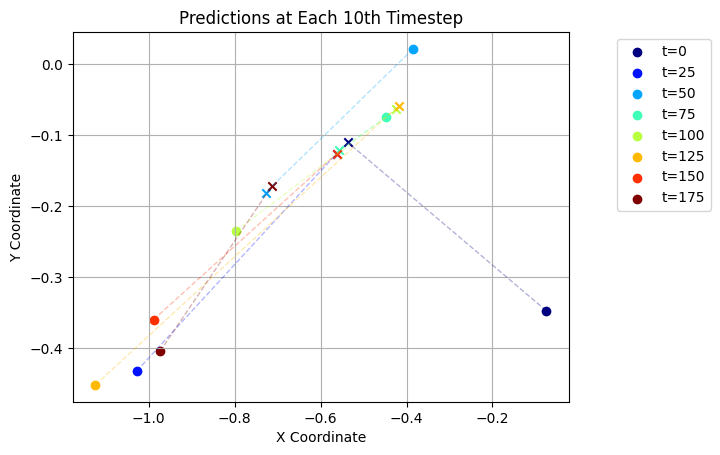

Epoch: [26][20/79]	Time 3.743	Loss -317.8921	 
Epoch: [26][40/79]	Time 3.679	Loss -315.4666	 
Epoch: [26][60/79]	Time 3.688	Loss -321.7610	 
tensor([[0.5232, 0.0890, 0.3878],
        [0.1582, 0.1634, 0.6783],
        [0.4954, 0.3005, 0.2041]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5691, 0.1394, 0.2916], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00286
Pred MSE: 0.04835
Epoch: [27][20/79]	Time 3.687	Loss -314.7121	 
Epoch: [27][40/79]	Time 3.665	Loss -314.7666	 
Epoch: [27][60/79]	Time 3.725	Loss -312.2184	 
MSE: 0.00279
Pred MSE: 0.04853
Epoch: [28][20/79]	Time 3.627	Loss -307.8597	 
Epoch: [28][40/79]	Time 3.644	Loss -325.1711	 
Epoch: [28][60/79]	Time 3.655	Loss -322.8296	 
tensor([[0.5306, 0.0807, 0.3887],
        [0.1370, 0.1414, 0.7215],
        [0.4679, 0.3452, 0.1870]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5698, 0.1235, 0.3067], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00278
Pred MSE: 0.04841
Epoch: [29][20/79]	Time 3.66

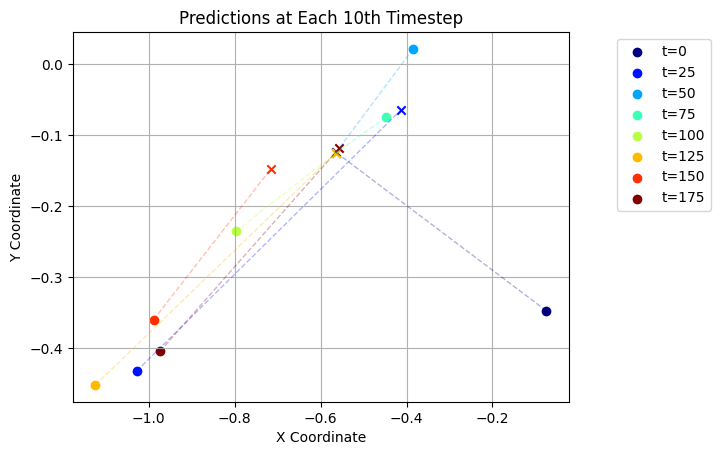

Epoch: [31][20/79]	Time 3.684	Loss -328.9570	 
Epoch: [31][40/79]	Time 3.803	Loss -328.6455	 
Epoch: [31][60/79]	Time 3.764	Loss -334.1400	 
MSE: 0.00267
Pred MSE: 0.04873
Epoch: [32][20/79]	Time 3.740	Loss -333.0479	 
Epoch: [32][40/79]	Time 3.666	Loss -326.1215	 
Epoch: [32][60/79]	Time 3.714	Loss -328.6754	 
tensor([[0.5883, 0.0665, 0.3452],
        [0.1033, 0.1053, 0.7914],
        [0.4054, 0.4402, 0.1544]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5595, 0.0957, 0.3447], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00301
Pred MSE: 0.04802
Epoch: [33][20/79]	Time 3.675	Loss -344.4135	 
Epoch: [33][40/79]	Time 3.688	Loss -334.7989	 
Epoch: [33][60/79]	Time 3.688	Loss -331.1480	 
MSE: 0.00268
Pred MSE: 0.04841
Epoch: [34][20/79]	Time 3.674	Loss -342.6104	 
Epoch: [34][40/79]	Time 3.637	Loss -335.4286	 
Epoch: [34][60/79]	Time 3.693	Loss -330.5453	 
tensor([[0.6238, 0.0615, 0.3148],
        [0.0936, 0.0944, 0.8121],
        [0.3827, 0.4751, 0.1422]], device='cuda

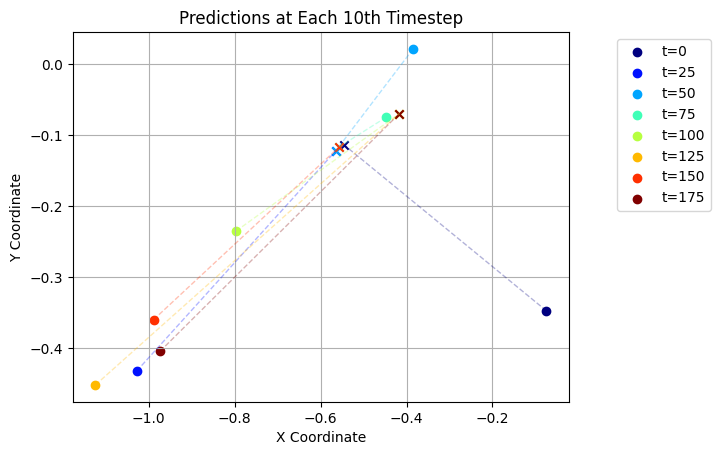

Epoch: [36][20/79]	Time 3.682	Loss -344.6825	 
Epoch: [36][40/79]	Time 3.719	Loss -339.4945	 
Epoch: [36][60/79]	Time 3.643	Loss -341.3717	 
tensor([[0.6675, 0.0560, 0.2766],
        [0.0842, 0.0836, 0.8322],
        [0.3550, 0.5155, 0.1295]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5439, 0.0765, 0.3796], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00254
Pred MSE: 0.04790
Epoch: [37][20/79]	Time 3.783	Loss -335.7941	 
Epoch: [37][40/79]	Time 3.655	Loss -338.8083	 
Epoch: [37][60/79]	Time 3.681	Loss -338.3816	 
MSE: 0.00260
Pred MSE: 0.04744
Epoch: [38][20/79]	Time 3.694	Loss -341.9834	 
Epoch: [38][40/79]	Time 3.687	Loss -339.6039	 
Epoch: [38][60/79]	Time 3.790	Loss -339.5521	 
tensor([[0.7049, 0.0513, 0.2439],
        [0.0778, 0.0756, 0.8466],
        [0.3327, 0.5482, 0.1191]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5403, 0.0699, 0.3898], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00259
Pred MSE: 0.04762
Epoch: [39][20/79]	Time 3.69

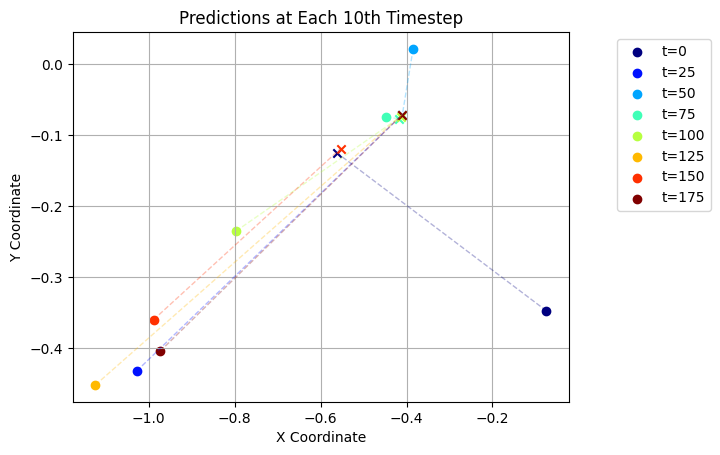

Epoch: [41][20/79]	Time 3.700	Loss -348.5311	 
Epoch: [41][40/79]	Time 3.665	Loss -348.0695	 
Epoch: [41][60/79]	Time 3.632	Loss -342.1318	 
MSE: 0.00240
Pred MSE: 0.04724
Epoch: [42][20/79]	Time 3.644	Loss -349.2480	 
Epoch: [42][40/79]	Time 3.661	Loss -347.3143	 
Epoch: [42][60/79]	Time 3.666	Loss -342.1444	 
tensor([[0.7564, 0.0444, 0.1992],
        [0.0695, 0.0644, 0.8661],
        [0.2964, 0.5999, 0.1038]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5350, 0.0604, 0.4045], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00234
Pred MSE: 0.04707
Epoch: [43][20/79]	Time 3.684	Loss -346.0568	 
Epoch: [43][40/79]	Time 3.576	Loss -350.6909	 
Epoch: [43][60/79]	Time 3.584	Loss -346.3097	 
MSE: 0.00228
Pred MSE: 0.04710
Epoch: [44][20/79]	Time 3.638	Loss -342.1648	 
Epoch: [44][40/79]	Time 3.594	Loss -348.0837	 
Epoch: [44][60/79]	Time 3.667	Loss -346.6968	 
tensor([[0.7738, 0.0419, 0.1844],
        [0.0667, 0.0605, 0.8729],
        [0.2829, 0.6190, 0.0981]], device='cuda

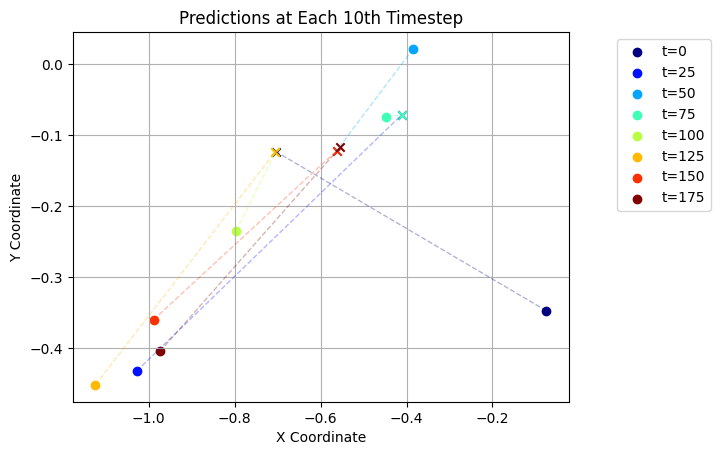

Epoch: [46][20/79]	Time 3.574	Loss -349.2033	 
Epoch: [46][40/79]	Time 3.541	Loss -349.0548	 
Epoch: [46][60/79]	Time 3.543	Loss -347.7410	 
tensor([[0.7891, 0.0395, 0.1713],
        [0.0643, 0.0568, 0.8789],
        [0.2705, 0.6366, 0.0929]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5320, 0.0538, 0.4142], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00220
Pred MSE: 0.04686
Epoch: [47][20/79]	Time 3.555	Loss -337.8087	 
Epoch: [47][40/79]	Time 3.573	Loss -352.6652	 
Epoch: [47][60/79]	Time 3.559	Loss -345.1847	 
MSE: 0.00217
Pred MSE: 0.04688
Epoch: [48][20/79]	Time 3.572	Loss -346.0555	 
Epoch: [48][40/79]	Time 3.538	Loss -344.7936	 
Epoch: [48][60/79]	Time 3.548	Loss -343.0368	 
tensor([[0.8011, 0.0377, 0.1611],
        [0.0626, 0.0540, 0.8835],
        [0.2609, 0.6505, 0.0886]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5313, 0.0511, 0.4176], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00213
Pred MSE: 0.04673
Epoch: [49][20/79]	Time 3.57

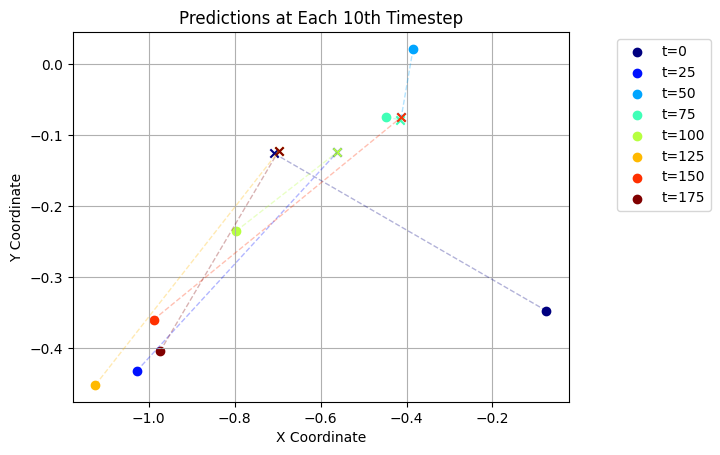

Epoch: [51][20/79]	Time 3.622	Loss -348.3784	 
Epoch: [51][40/79]	Time 3.513	Loss -349.2672	 
Epoch: [51][60/79]	Time 3.534	Loss -352.1130	 
MSE: 0.00203
Pred MSE: 0.04655
Epoch: [52][20/79]	Time 3.553	Loss -347.1675	 
Epoch: [52][40/79]	Time 3.567	Loss -353.5105	 
Epoch: [52][60/79]	Time 3.564	Loss -351.6419	 
tensor([[0.8214, 0.0345, 0.1441],
        [0.0602, 0.0489, 0.8909],
        [0.2432, 0.6759, 0.0809]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5287, 0.0467, 0.4247], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00203
Pred MSE: 0.04673
Epoch: [53][20/79]	Time 3.536	Loss -347.9190	 
Epoch: [53][40/79]	Time 3.530	Loss -352.4741	 
Epoch: [53][60/79]	Time 3.564	Loss -350.2891	 
MSE: 0.00204
Pred MSE: 0.04629
Epoch: [54][20/79]	Time 3.533	Loss -355.6153	 
Epoch: [54][40/79]	Time 3.577	Loss -351.3357	 
Epoch: [54][60/79]	Time 3.553	Loss -344.1345	 
tensor([[0.8289, 0.0334, 0.1377],
        [0.0595, 0.0470, 0.8935],
        [0.2365, 0.6857, 0.0778]], device='cuda

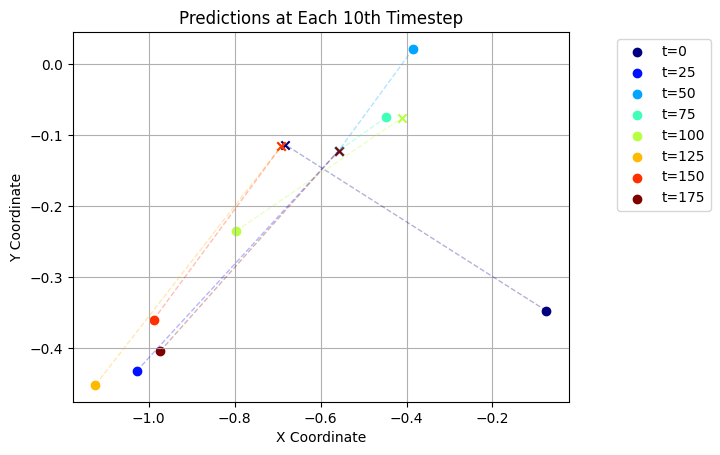

Epoch: [56][20/79]	Time 3.547	Loss -349.0526	 
Epoch: [56][40/79]	Time 3.548	Loss -346.0138	 
Epoch: [56][60/79]	Time 3.583	Loss -343.5309	 
tensor([[0.8363, 0.0322, 0.1316],
        [0.0590, 0.0451, 0.8959],
        [0.2299, 0.6953, 0.0748]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5268, 0.0432, 0.4300], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00190
Pred MSE: 0.04619
Epoch: [57][20/79]	Time 3.599	Loss -354.7746	 
Epoch: [57][40/79]	Time 3.543	Loss -350.0552	 
Epoch: [57][60/79]	Time 3.551	Loss -346.9023	 
MSE: 0.00177
Pred MSE: 0.04610
Epoch: [58][20/79]	Time 3.545	Loss -349.6743	 
Epoch: [58][40/79]	Time 3.565	Loss -354.0320	 
Epoch: [58][60/79]	Time 3.572	Loss -348.0701	 
tensor([[0.8435, 0.0310, 0.1254],
        [0.0585, 0.0431, 0.8984],
        [0.2229, 0.7056, 0.0715]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5275, 0.0414, 0.4311], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00175
Pred MSE: 0.04634
Epoch: [59][20/79]	Time 3.53

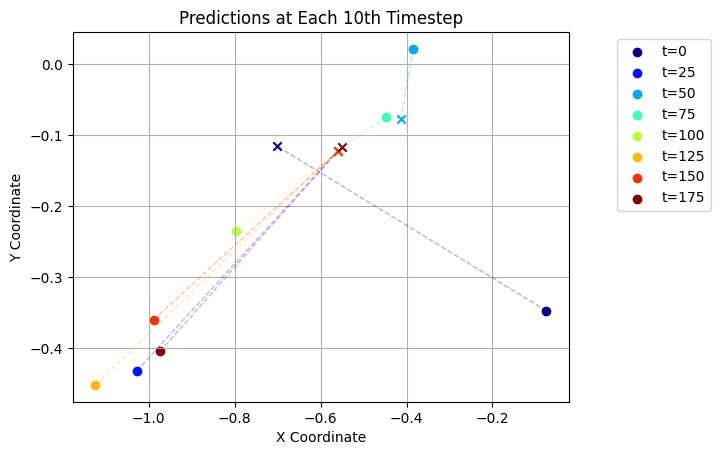

Epoch: [61][20/79]	Time 3.555	Loss -350.8582	 
Epoch: [61][40/79]	Time 3.520	Loss -348.7244	 
Epoch: [61][60/79]	Time 3.539	Loss -347.5429	 
MSE: 0.00165
Pred MSE: 0.04597
Epoch: [62][20/79]	Time 3.582	Loss -352.4260	 
Epoch: [62][40/79]	Time 3.523	Loss -346.7056	 
Epoch: [62][60/79]	Time 3.607	Loss -354.0930	 
tensor([[0.8561, 0.0291, 0.1148],
        [0.0583, 0.0396, 0.9021],
        [0.2107, 0.7236, 0.0656]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5265, 0.0381, 0.4353], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00166
Pred MSE: 0.04589
Epoch: [63][20/79]	Time 3.551	Loss -352.5390	 
Epoch: [63][40/79]	Time 3.549	Loss -352.0757	 
Epoch: [63][60/79]	Time 3.568	Loss -352.0179	 
MSE: 0.00170
Pred MSE: 0.04591
Epoch: [64][20/79]	Time 3.529	Loss -352.5014	 
Epoch: [64][40/79]	Time 3.534	Loss -343.7543	 
Epoch: [64][60/79]	Time 3.556	Loss -355.5469	 
tensor([[0.8607, 0.0284, 0.1110],
        [0.0586, 0.0382, 0.9031],
        [0.2063, 0.7304, 0.0633]], device='cuda

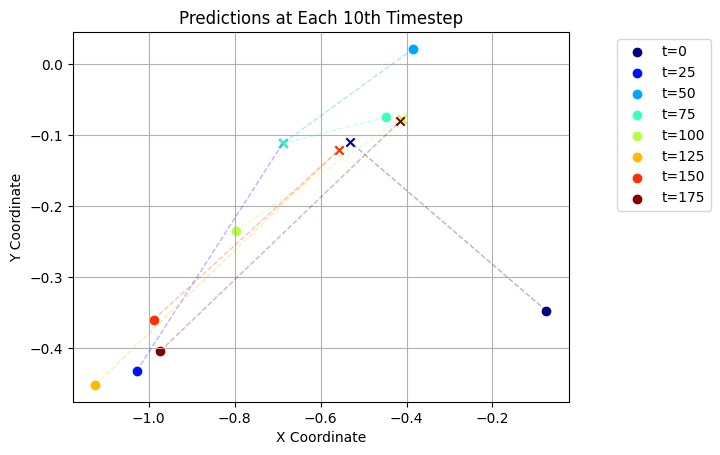

Epoch: [66][20/79]	Time 3.535	Loss -349.1248	 
Epoch: [66][40/79]	Time 3.564	Loss -356.7672	 
Epoch: [66][60/79]	Time 3.526	Loss -348.8539	 
tensor([[0.8653, 0.0277, 0.1070],
        [0.0590, 0.0368, 0.9043],
        [0.2014, 0.7379, 0.0607]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5269, 0.0355, 0.4376], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00159
Pred MSE: 0.04606
Epoch: [67][20/79]	Time 3.542	Loss -355.1904	 
Epoch: [67][40/79]	Time 3.603	Loss -348.6031	 
Epoch: [67][60/79]	Time 3.510	Loss -357.5643	 
MSE: 0.00152
Pred MSE: 0.04602
Epoch: [68][20/79]	Time 3.513	Loss -356.0299	 
Epoch: [68][40/79]	Time 3.556	Loss -349.6625	 
Epoch: [68][60/79]	Time 3.534	Loss -353.2719	 
tensor([[0.8699, 0.0270, 0.1031],
        [0.0595, 0.0354, 0.9051],
        [0.1970, 0.7447, 0.0583]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5273, 0.0341, 0.4386], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00154
Pred MSE: 0.04584
Epoch: [69][20/79]	Time 3.56

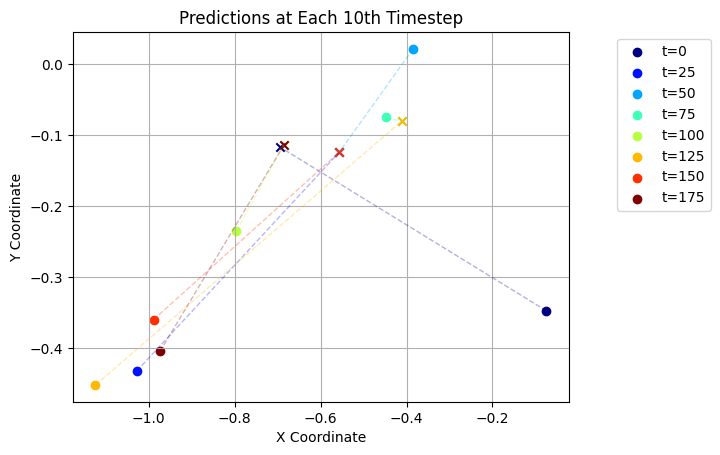

Epoch: [71][20/79]	Time 3.557	Loss -346.8353	 
Epoch: [71][40/79]	Time 3.560	Loss -353.3302	 
Epoch: [71][60/79]	Time 3.570	Loss -352.3749	 
MSE: 0.00146
Pred MSE: 0.04564
Epoch: [72][20/79]	Time 3.550	Loss -352.8417	 
Epoch: [72][40/79]	Time 3.562	Loss -349.5724	 
Epoch: [72][60/79]	Time 3.549	Loss -355.2533	 
tensor([[0.8779, 0.0259, 0.0961],
        [0.0611, 0.0326, 0.9063],
        [0.1889, 0.7577, 0.0535]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5277, 0.0316, 0.4408], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00146
Pred MSE: 0.04556
Epoch: [73][20/79]	Time 3.617	Loss -357.2384	 
Epoch: [73][40/79]	Time 3.582	Loss -351.3256	 
Epoch: [73][60/79]	Time 3.513	Loss -346.7672	 
MSE: 0.00147
Pred MSE: 0.04574
Epoch: [74][20/79]	Time 3.556	Loss -349.5992	 
Epoch: [74][40/79]	Time 3.612	Loss -353.1734	 
Epoch: [74][60/79]	Time 3.572	Loss -349.8230	 
tensor([[0.8811, 0.0256, 0.0933],
        [0.0619, 0.0315, 0.9067],
        [0.1853, 0.7634, 0.0513]], device='cuda

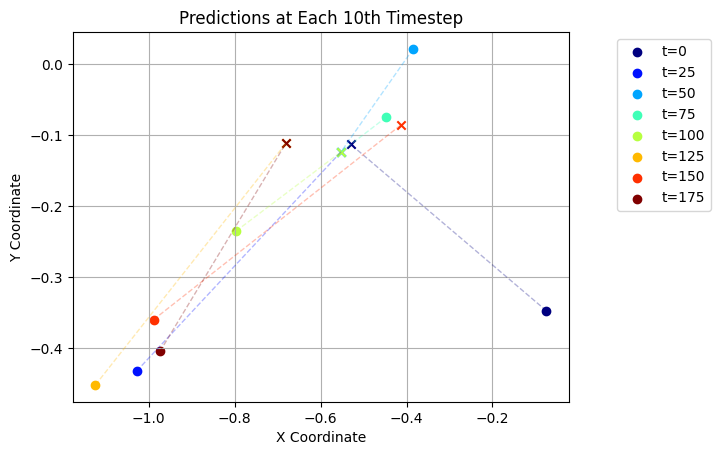

Epoch: [76][20/79]	Time 3.556	Loss -346.0613	 
Epoch: [76][40/79]	Time 3.567	Loss -350.4521	 
Epoch: [76][60/79]	Time 3.568	Loss -349.6452	 
tensor([[0.8837, 0.0254, 0.0910],
        [0.0627, 0.0304, 0.9069],
        [0.1821, 0.7686, 0.0493]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5287, 0.0294, 0.4419], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00140
Pred MSE: 0.04546
Epoch: [77][20/79]	Time 3.586	Loss -349.9323	 
Epoch: [77][40/79]	Time 3.585	Loss -354.3307	 
Epoch: [77][60/79]	Time 3.533	Loss -349.5094	 
MSE: 0.00142
Pred MSE: 0.04542
Epoch: [78][20/79]	Time 3.582	Loss -354.5886	 
Epoch: [78][40/79]	Time 3.558	Loss -352.7863	 
Epoch: [78][60/79]	Time 3.524	Loss -354.0312	 
tensor([[0.8860, 0.0252, 0.0888],
        [0.0639, 0.0293, 0.9068],
        [0.1789, 0.7738, 0.0474]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5299, 0.0284, 0.4417], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00140
Pred MSE: 0.04552
Epoch: [79][20/79]	Time 3.56

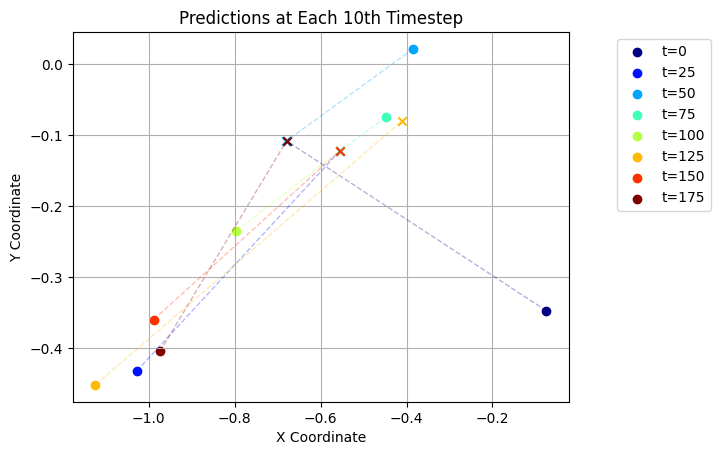

Epoch: [81][20/79]	Time 3.504	Loss -355.0784	 
Epoch: [81][40/79]	Time 3.568	Loss -350.8381	 
Epoch: [81][60/79]	Time 3.593	Loss -352.0096	 
MSE: 0.00139
Pred MSE: 0.04549
Epoch: [82][20/79]	Time 3.561	Loss -351.7607	 
Epoch: [82][40/79]	Time 3.552	Loss -355.3406	 
Epoch: [82][60/79]	Time 3.556	Loss -358.6569	 
tensor([[0.8893, 0.0251, 0.0855],
        [0.0657, 0.0277, 0.9066],
        [0.1745, 0.7812, 0.0443]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5298, 0.0268, 0.4433], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00135
Pred MSE: 0.04538
Epoch: [83][20/79]	Time 3.546	Loss -356.4428	 
Epoch: [83][40/79]	Time 3.589	Loss -353.7614	 
Epoch: [83][60/79]	Time 3.541	Loss -353.9491	 
MSE: 0.00134
Pred MSE: 0.04547
Epoch: [84][20/79]	Time 3.551	Loss -351.2676	 
Epoch: [84][40/79]	Time 3.534	Loss -353.2225	 
Epoch: [84][60/79]	Time 3.544	Loss -351.8973	 
tensor([[0.8906, 0.0252, 0.0842],
        [0.0664, 0.0270, 0.9065],
        [0.1729, 0.7841, 0.0431]], device='cuda

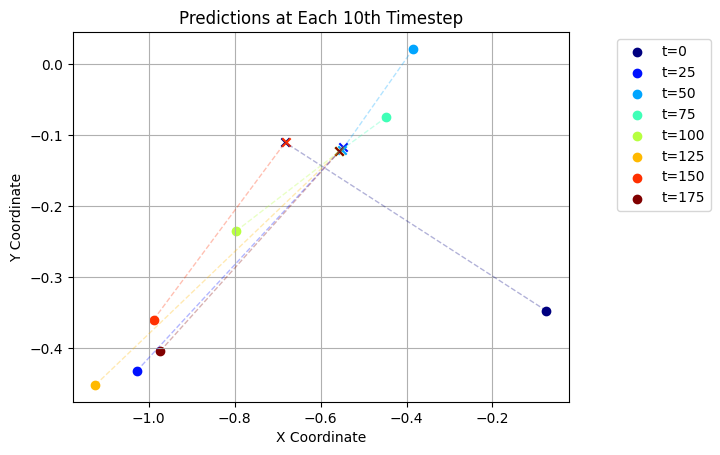

Epoch: [86][20/79]	Time 3.552	Loss -355.4779	 
Epoch: [86][40/79]	Time 3.541	Loss -351.2076	 
Epoch: [86][60/79]	Time 3.514	Loss -353.0806	 
tensor([[0.8914, 0.0253, 0.0832],
        [0.0670, 0.0265, 0.9066],
        [0.1712, 0.7868, 0.0420]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5300, 0.0257, 0.4443], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00139
Pred MSE: 0.04517
Epoch: [87][20/79]	Time 3.616	Loss -354.4128	 
Epoch: [87][40/79]	Time 3.531	Loss -361.5854	 
Epoch: [87][60/79]	Time 3.521	Loss -348.5884	 
MSE: 0.00135
Pred MSE: 0.04523
Epoch: [88][20/79]	Time 3.611	Loss -351.1164	 
Epoch: [88][40/79]	Time 3.569	Loss -349.2297	 
Epoch: [88][60/79]	Time 3.559	Loss -359.6225	 
tensor([[0.8923, 0.0255, 0.0822],
        [0.0678, 0.0259, 0.9063],
        [0.1699, 0.7892, 0.0410]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5301, 0.0252, 0.4447], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00136
Pred MSE: 0.04525
Epoch: [89][20/79]	Time 3.54

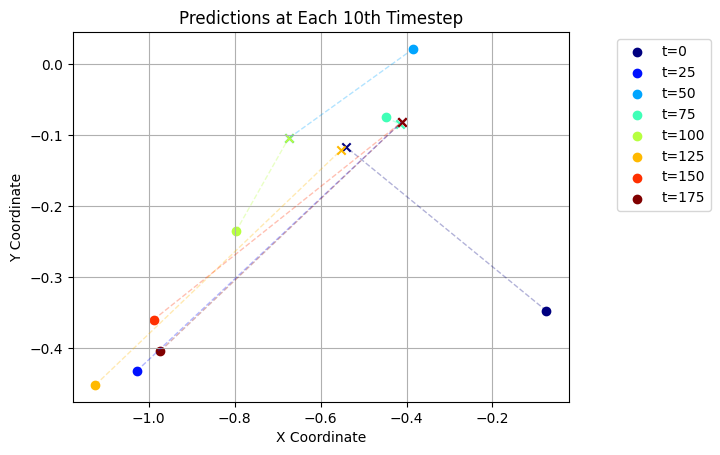

Epoch: [91][20/79]	Time 3.564	Loss -351.7151	 
Epoch: [91][40/79]	Time 3.536	Loss -350.7073	 
Epoch: [91][60/79]	Time 3.575	Loss -350.6048	 
MSE: 0.00131
Pred MSE: 0.04528
Epoch: [92][20/79]	Time 3.572	Loss -349.7457	 
Epoch: [92][40/79]	Time 3.584	Loss -356.7964	 
Epoch: [92][60/79]	Time 3.558	Loss -349.3560	 
tensor([[0.8938, 0.0259, 0.0803],
        [0.0690, 0.0248, 0.9061],
        [0.1671, 0.7940, 0.0389]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5304, 0.0241, 0.4455], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00135
Pred MSE: 0.04534
Epoch: [93][20/79]	Time 3.582	Loss -351.3224	 
Epoch: [93][40/79]	Time 3.539	Loss -350.5263	 
Epoch: [93][60/79]	Time 3.561	Loss -353.6614	 
MSE: 0.00134
Pred MSE: 0.04528
Epoch: [94][20/79]	Time 3.575	Loss -361.4743	 
Epoch: [94][40/79]	Time 3.553	Loss -353.2823	 
Epoch: [94][60/79]	Time 3.564	Loss -357.5084	 
tensor([[0.8944, 0.0261, 0.0794],
        [0.0697, 0.0243, 0.9060],
        [0.1658, 0.7963, 0.0379]], device='cuda

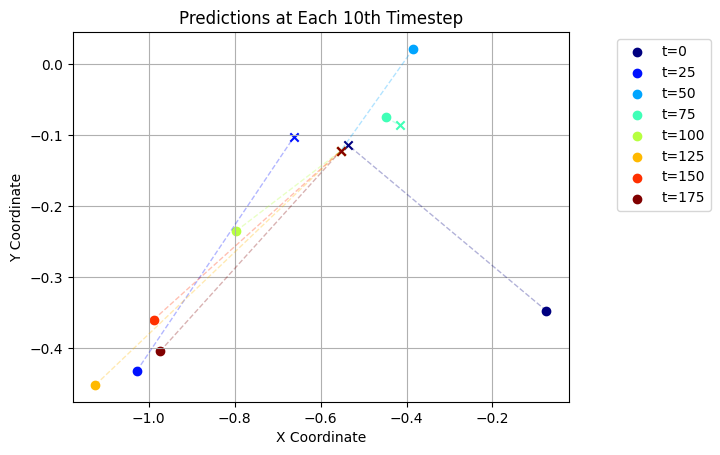

Epoch: [96][20/79]	Time 3.565	Loss -351.7160	 
Epoch: [96][40/79]	Time 3.506	Loss -355.0390	 
Epoch: [96][60/79]	Time 3.560	Loss -356.9176	 
tensor([[0.8949, 0.0264, 0.0787],
        [0.0704, 0.0238, 0.9058],
        [0.1646, 0.7986, 0.0369]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5306, 0.0232, 0.4462], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00134
Pred MSE: 0.04526
Epoch: [97][20/79]	Time 3.604	Loss -355.7024	 
Epoch: [97][40/79]	Time 3.525	Loss -352.4338	 
Epoch: [97][60/79]	Time 3.624	Loss -352.4644	 
MSE: 0.00139
Pred MSE: 0.04535
Epoch: [98][20/79]	Time 3.560	Loss -352.0724	 
Epoch: [98][40/79]	Time 3.553	Loss -356.5977	 
Epoch: [98][60/79]	Time 3.561	Loss -351.0088	 
tensor([[0.8953, 0.0267, 0.0779],
        [0.0711, 0.0233, 0.9055],
        [0.1636, 0.8005, 0.0360]], device='cuda:0', grad_fn=<SoftmaxBackward0>)
tensor([0.5311, 0.0227, 0.4462], device='cuda:0', grad_fn=<SoftmaxBackward0>)
1
MSE: 0.00132
Pred MSE: 0.04528
Epoch: [99][20/79]	Time 3.51

In [ ]:
fivo_losses, test_mse_fivo, pred_mse_fivo = train_fivo(N, model, optimizer,num_states, dim_latent, T)

In [48]:
PATH = 'snlds_coord_fivo.pth'
# torch.save(model.state_dict(), PATH)
model.transitions = torch.nn.ModuleList([MLP(dim_latent, dim_latent, 16, 'cos') for _ in range(num_states)]).to(device).float()
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [ ]:
test_mse_fivo, pred_mse_fivo

([0.03653360866010189,
  0.017506255954504012,
  0.018719835206866264,
  0.017849241942167283,
  0.01752238068729639,
  0.01630566120147705,
  0.0161326814442873,
  0.015719229448586704,
  0.013062969967722892,
  0.012793847359716892,
  0.009596460592001676,
  0.006916813272982836,
  0.005487605230882764,
  0.004393965937197208,
  0.0035384419606998563,
  0.0036978139309212566,
  0.003260264219716191,
  0.0031315880361944435,
  0.003197944909334183,
  0.0030382885364815594,
  0.003221439104527235,
  0.0028800250263884665,
  0.0028738568769767882,
  0.0030287056462839244,
  0.0028995339293032885,
  0.00286515096668154,
  0.002863437426276505,
  0.0027884597657248378,
  0.002777020516805351,
  0.0027196787530556323,
  0.002734415605664253,
  0.0026672391453757883,
  0.0030119899194687603,
  0.0026763994246721268,
  0.0027083041379228233,
  0.0026710143545642497,
  0.002540947822853923,
  0.0025964090134948494,
  0.0025902445428073405,
  0.002456123079173267,
  0.0024082807824015616,
  0.

Text(0, 0.5, 'Training Loss')

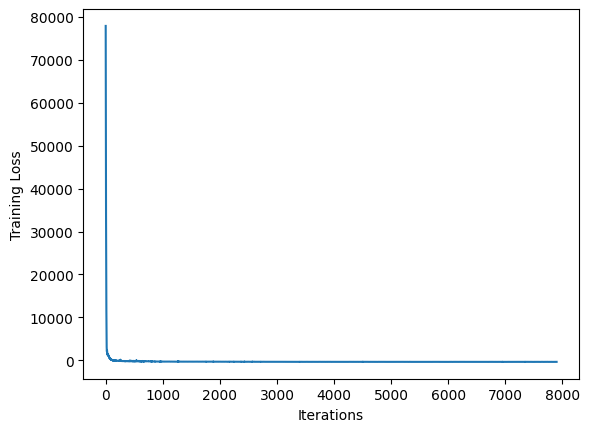

In [ ]:
plt.plot(fivo_losses)
plt.xlabel('Iterations')
plt.ylabel('Training Loss')

Text(0, 0.5, 'Training Loss')

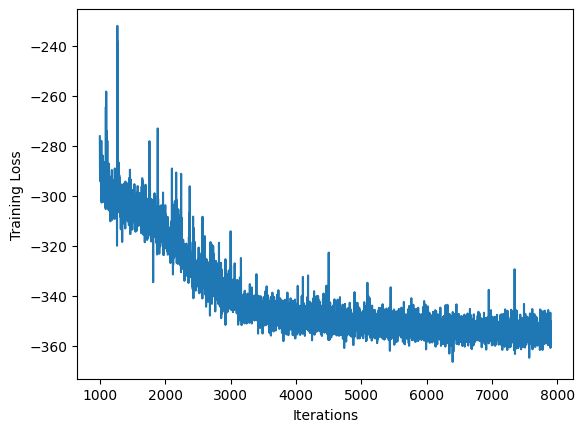

In [ ]:
plt.plot(np.arange(1000,len(fivo_losses)),fivo_losses[1000:])
plt.xlabel('Iterations')
plt.ylabel('Training Loss')

Text(0, 0.5, 'MSE')

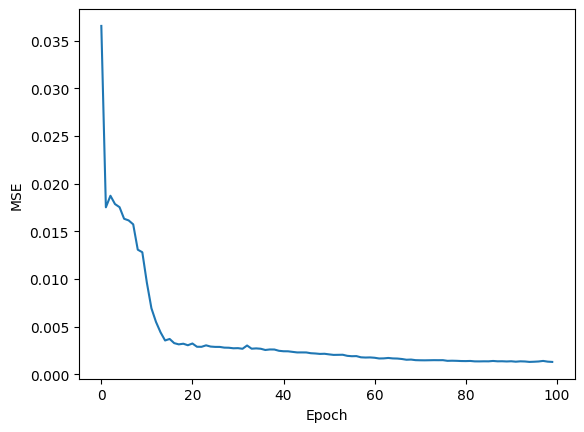

In [ ]:
plt.plot(test_mse_fivo)
plt.xlabel('Epoch')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

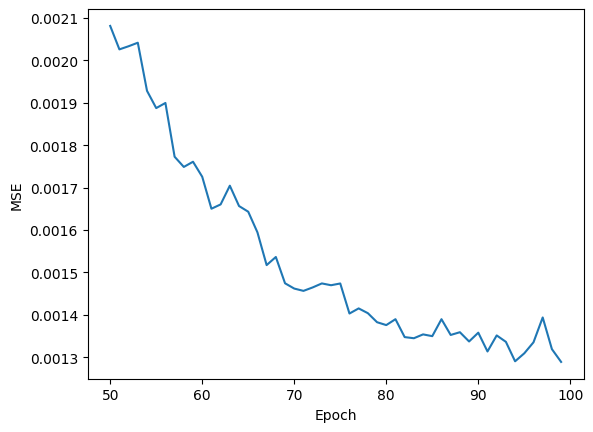

In [ ]:
plt.plot(np.arange(50,len(test_mse_fivo)),test_mse_fivo[50:])
plt.xlabel('Epoch')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

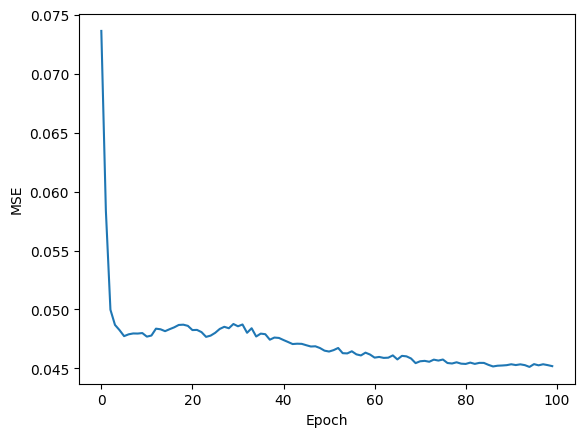

In [ ]:
plt.plot(pred_mse_fivo)
plt.xlabel('Epoch')
plt.ylabel('MSE')

Text(0, 0.5, 'MSE')

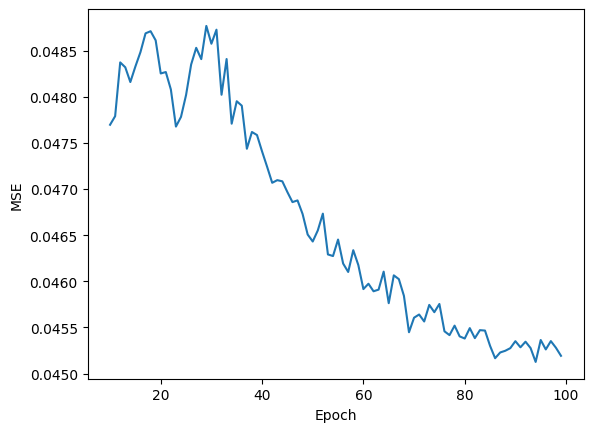

In [ ]:
plt.plot(np.arange(10,len(pred_mse_fivo)),pred_mse_fivo[10:])
plt.xlabel('Epoch')
plt.ylabel('MSE')

In [ ]:
# Training time: 495min
print(f"Last FIVO Loss: {fivo_losses[-1]:.1f}")
print(f"Last Test MSE: {test_mse_fivo[-1]:.6f}")
print(f"Last Pred MSE: {pred_mse_fivo[-1]:.6f}")

Last FIVO Loss: -350.4
Last Test MSE: 0.001289
Last Pred MSE: 0.045192


In [ ]:
print(f"Best FIVO Loss: {min(fivo_losses):.1f}")
print(f"Best Test MSE: {min(test_mse_fivo):.6f}")
print(f"Best Pred MSE: {min(pred_mse_fivo):.6f}")

Best ELBO Loss: -366.5
Best Test MSE: 0.001289
Best Pred MSE: 0.045126


In [ ]:
# Reconstructions

t = 200
model.eval()

with torch.inference_mode():
    (x,) = next(iter(test_dataloader))
    x = x.to(device).float()
    recon_x,_,_,_ = model(x)
    x = x.cpu().numpy()
    recon_x = recon_x.cpu().numpy()

# Final MSE per timestep
mse_T = np.mean(((x - recon_x) ** 2),axis=(0,2))
for i,element in enumerate(mse_T):
    print(f"t={i} MSE per pixel:{element:.6f}")

t=0 MSE per pixel:0.023726
t=1 MSE per pixel:0.009424
t=2 MSE per pixel:0.002127
t=3 MSE per pixel:0.002473
t=4 MSE per pixel:0.001785
t=5 MSE per pixel:0.001438
t=6 MSE per pixel:0.001453
t=7 MSE per pixel:0.001259
t=8 MSE per pixel:0.000954
t=9 MSE per pixel:0.001068
t=10 MSE per pixel:0.001136
t=11 MSE per pixel:0.001575
t=12 MSE per pixel:0.001354
t=13 MSE per pixel:0.000976
t=14 MSE per pixel:0.001299
t=15 MSE per pixel:0.001090
t=16 MSE per pixel:0.000864
t=17 MSE per pixel:0.000936
t=18 MSE per pixel:0.001017
t=19 MSE per pixel:0.001115
t=20 MSE per pixel:0.001153
t=21 MSE per pixel:0.000946
t=22 MSE per pixel:0.001349
t=23 MSE per pixel:0.001012
t=24 MSE per pixel:0.001281
t=25 MSE per pixel:0.001445
t=26 MSE per pixel:0.000880
t=27 MSE per pixel:0.001157
t=28 MSE per pixel:0.000943
t=29 MSE per pixel:0.000900
t=30 MSE per pixel:0.001256
t=31 MSE per pixel:0.000851
t=32 MSE per pixel:0.001257
t=33 MSE per pixel:0.001031
t=34 MSE per pixel:0.001120
t=35 MSE per pixel:0.000868
t=

In [ ]:
mse_T

array([0.02372556, 0.00942374, 0.00212708, 0.00247344, 0.00178527,
       0.00143797, 0.00145326, 0.00125854, 0.0009539 , 0.0010685 ,
       0.0011365 , 0.0015746 , 0.00135423, 0.00097575, 0.00129869,
       0.00108983, 0.00086359, 0.00093638, 0.00101708, 0.00111469,
       0.00115339, 0.00094568, 0.00134948, 0.00101189, 0.00128137,
       0.00144483, 0.00087971, 0.0011566 , 0.00094298, 0.00090006,
       0.00125615, 0.00085127, 0.00125693, 0.00103142, 0.00111995,
       0.00086794, 0.00140183, 0.00121707, 0.000993  , 0.00125731,
       0.00123406, 0.00089894, 0.00104371, 0.00095118, 0.0012424 ,
       0.00117762, 0.00110306, 0.00145648, 0.00126074, 0.00063261,
       0.00128599, 0.00079314, 0.0009383 , 0.00116497, 0.00123421,
       0.00108589, 0.0010099 , 0.00104115, 0.00088845, 0.00148656,
       0.00114506, 0.00132289, 0.00107593, 0.0013612 , 0.00136842,
       0.00108717, 0.00111049, 0.00092331, 0.00121025, 0.00094695,
       0.00123299, 0.00132131, 0.00087985, 0.00079646, 0.00086

Text(0, 0.5, 'MSE per Pixel')

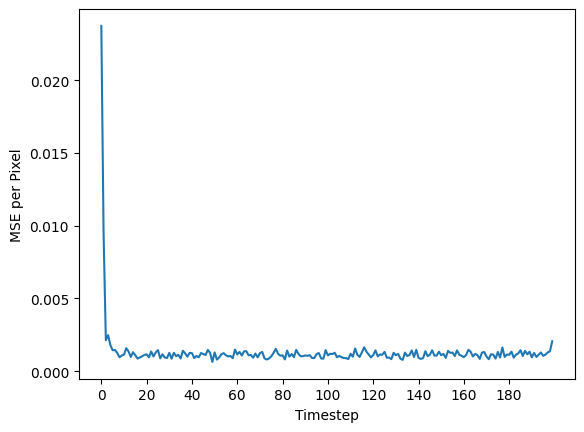

In [ ]:
plt.plot(mse_T)
plt.xlabel('Timestep')
plt.xticks(np.arange(0,t,20))
plt.ylabel('MSE per Pixel')

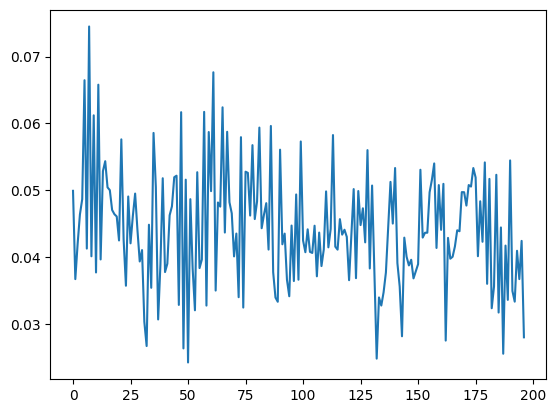

In [ ]:
# Take first 3 timesteps. Generate the rest of the sequence. Calculate MSE

with torch.inference_mode():
    predict_mse = []
    for (sample,) in test_dataloader:
        mse_values = []
        obs_var = sample.float().to(device)
        preds = model.predict_sequence(obs_var[:,:3], seq_len=197)
        obs_var, preds = obs_var.cpu().numpy(), preds.cpu().numpy()
        mse = np.mean(((preds - obs_var[:,3:]) ** 2),axis=(0,2))
        mse_values.append(mse)
    mse_val = sum(mse_values) / len(mse_values)
    predict_mse.append(mse_val.tolist())

plt.plot(predict_mse[0])

In [ ]:
predict_mse[0]

[0.0499081164598465,
 0.036697741597890854,
 0.04194790869951248,
 0.04636818915605545,
 0.04866170883178711,
 0.06645585596561432,
 0.04126661270856857,
 0.07449545711278915,
 0.0401126965880394,
 0.061201807111501694,
 0.037693001329898834,
 0.06578615307807922,
 0.039641931653022766,
 0.05285540223121643,
 0.05433947592973709,
 0.050425104796886444,
 0.05000666156411171,
 0.04703846573829651,
 0.04641064256429672,
 0.04606982320547104,
 0.04248244687914848,
 0.05760573223233223,
 0.042580898851156235,
 0.03570880740880966,
 0.049061112105846405,
 0.04205281659960747,
 0.04613350331783295,
 0.049496885389089584,
 0.04407580941915512,
 0.039340466260910034,
 0.04104068875312805,
 0.030308041721582413,
 0.026686344295740128,
 0.04483595862984657,
 0.03539951890707016,
 0.05856959521770477,
 0.05049736797809601,
 0.030664410442113876,
 0.03892714902758598,
 0.051790282130241394,
 0.0377565436065197,
 0.03900889307260513,
 0.04625344276428223,
 0.04758681356906891,
 0.05194828659296036,


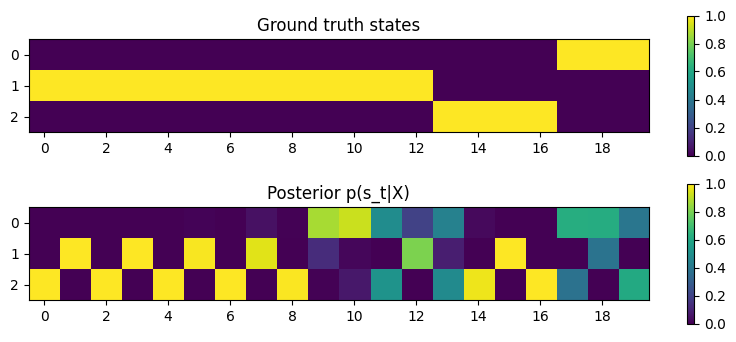

In [49]:
# First 20 timesteps. Probability of discrete states

latent_path = "../../../vol/bitbucket/am9923/datasets/latent_variables/states_test_N_500_T_200_dim_latent_2_dim_obs_2_state_3_sparsity_0.0_net_cosine_seed_24.npy"
latents_dataset = TensorDataset(torch.from_numpy(np.load(latent_path)))
latent_loader = DataLoader(latents_dataset, batch_size=50, shuffle=False)
latent_states = next(iter(latent_loader))[0]



with torch.inference_mode():
    obs = next(iter(test_dataloader))[0]
    gamma = model.gamma(obs[:,:].float().to(device))

plot_discrete_states(gamma,latent_states)

# Plot p(s_t|X)

In [9]:
# First 20 timesteps. Probability of discrete states

latent_path = "../../../vol/bitbucket/am9923/datasets/latent_variables/states_test_N_500_T_200_dim_latent_2_dim_obs_2_state_3_sparsity_0.0_net_cosine_seed_24.npy"
latents_dataset = TensorDataset(torch.from_numpy(np.load(latent_path)))
latent_loader = DataLoader(latents_dataset, batch_size=50, shuffle=False)
latents_states = next(iter(latent_loader))[0]
obs = next(iter(test_dataloader))[0]

# ELBO
model = VariationalSNLDS(2, 2, 64, 3, encoder_type='recurent', device=device, annealing=False, inference='alpha', beta=0).to(device)
PATH = 'snlds_coord_elbo.pth'
model.transitions = torch.nn.ModuleList([MLP(dim_latent, dim_latent, 16, 'cos') for _ in range(num_states)]).to(device).float()
model.load_state_dict(torch.load(PATH))
with torch.inference_mode():
    gamma_elbo = model.gamma(obs[:,:].float().to(device))
# IWAE
model = VariationalSNLDS(2, 2, 64, 3, encoder_type='recurent', device=device, annealing=False, inference='alpha', beta=0).to(device)
PATH = 'snlds_coord_iwae.pth'
model.transitions = torch.nn.ModuleList([MLP(dim_latent, dim_latent, 16, 'cos') for _ in range(num_states)]).to(device).float()
model.load_state_dict(torch.load(PATH))
with torch.inference_mode():
    gamma_iwae = model.gamma(obs[:,:].float().to(device))
# FIVO
model = VariationalSNLDS(2, 2, 64, 3, encoder_type='recurent', device=device, annealing=False, inference='alpha', beta=0).to(device)
PATH = 'snlds_coord_fivo.pth'
model.transitions = torch.nn.ModuleList([MLP(dim_latent, dim_latent, 16, 'cos') for _ in range(num_states)]).to(device).float()
model.load_state_dict(torch.load(PATH))
with torch.inference_mode():
    gamma_fivo = model.gamma(obs[:,:].float().to(device))


/tmp/ipykernel_2239500/3453969437.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[3].set_xticklabels([f'{int(label)}' for label in new_labels])


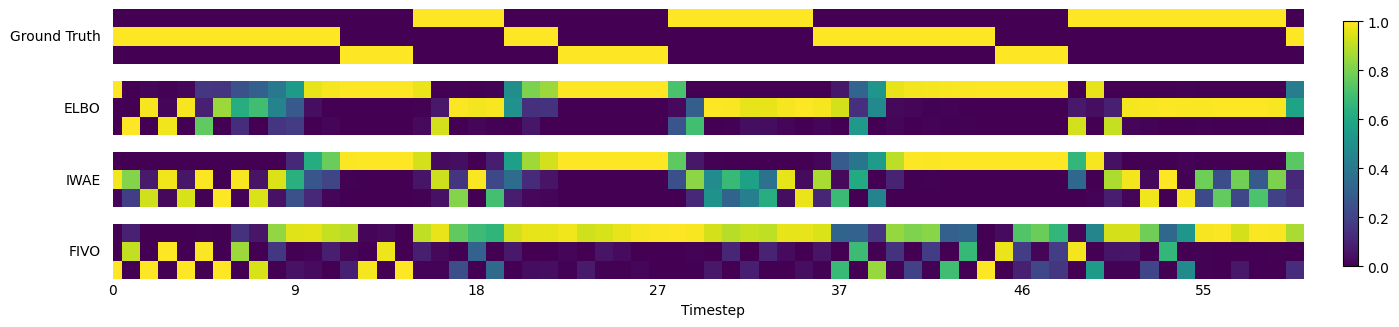

/tmp/ipykernel_2239500/3453969437.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[3].set_xticklabels([f'{int(label)}' for label in new_labels])


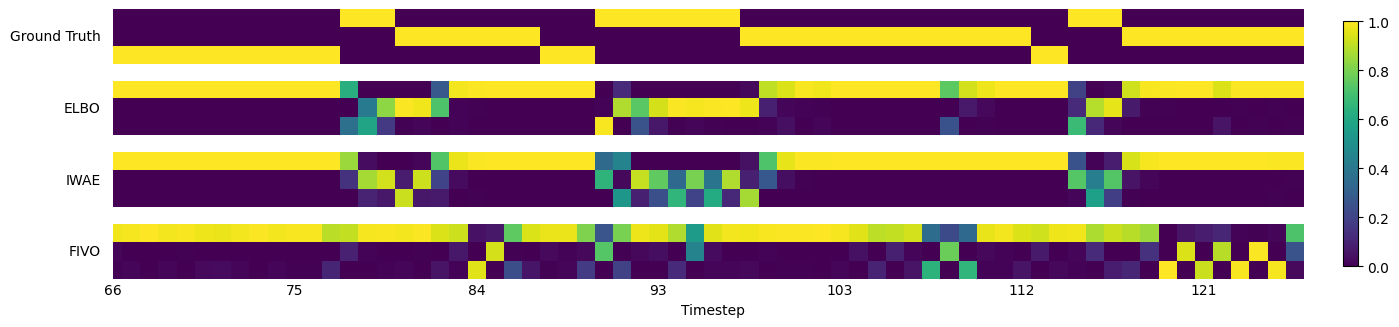

/tmp/ipykernel_2239500/3453969437.py:80: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[3].set_xticklabels([f'{int(label)}' for label in new_labels])


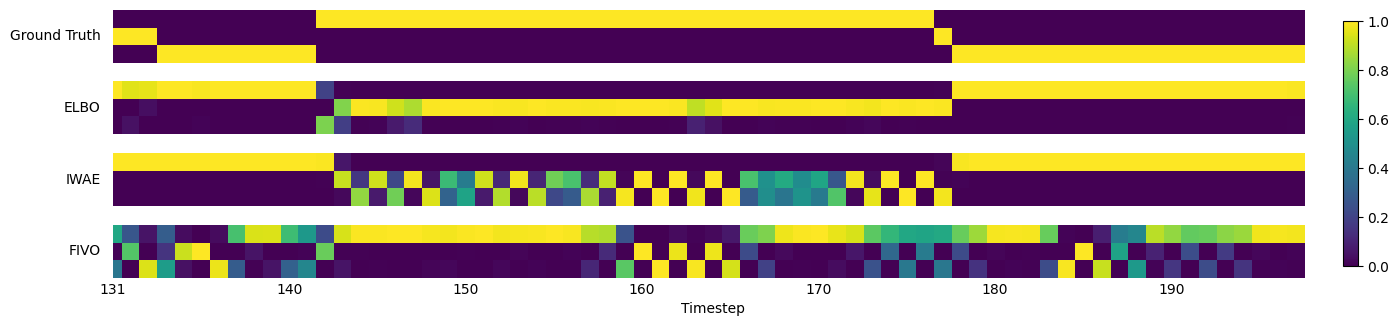

In [10]:
plot_models(gamma_elbo[:,:66], gamma_iwae[:,:66], gamma_fivo[:,:66], latents_states[:,:66], [0,65])
plot_models(gamma_elbo[:,66:132], gamma_iwae[:,66:132], gamma_fivo[:,66:132], latents_states[:,66:132], [66,131])
plot_models(gamma_elbo[:,132:], gamma_iwae[:,132:], gamma_fivo[:,132:], latents_states[:,132:], [131,200])

In [12]:
latents_states = latents_states.cpu().numpy()
gamma_elbo = gamma_elbo.cpu().numpy()
gamma_iwae = gamma_iwae.cpu().numpy()
gamma_fivo = gamma_fivo.cpu().numpy()

In [13]:
print(f"ELBO:{best_f1_score(latents_states, gamma_elbo):.2f}")
print(f"IWAE:{best_f1_score(latents_states, gamma_iwae):.2f}")
print(f"FIVO:{best_f1_score(latents_states, gamma_fivo):.2f}")

ELBO:0.54
IWAE:0.48
FIVO:0.37


In [14]:
print(f"ELBO:{best_cross_entropy_loss(latents_states, gamma_elbo):.2f}")
print(f"IWAE:{best_cross_entropy_loss(latents_states, gamma_iwae):.2f}")
print(f"FIVO:{best_cross_entropy_loss(latents_states, gamma_fivo):.2f}")

ELBO:2.86
IWAE:3.17
FIVO:3.69
